<a href="https://colab.research.google.com/github/albertometelli/rl-phd-2022/blob/main/02_gym_environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Gym Environment

This notebook is inspired to the Stable Baselines3 tutorial available at [https://github.com/araffin/rl-tutorial-jnrr19](https://github.com/araffin/rl-tutorial-jnrr19).


## Introduction

In this notebook, we will learn how to build a customized environment with **Open AI Gym**.

### Links

Open AI Gym Github: [https://github.com/openai/gym](https://github.com/openai/gym)

Open AI Gym Documentation: [https://www.gymlibrary.ml](https://www.gymlibrary.ml)

Stable Baselines 3 Github:[https://github.com/DLR-RM/stable-baselines3](https://github.com/DLR-RM/stable-baselines3)

Stable Baseline 3 Documentation: [https://stable-baselines3.readthedocs.io/en/master/](https://stable-baselines3.readthedocs.io/en/master/)

## Install Dependencies and Stable Baselines3 Using Pip

In [13]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Reason for being yanked: re-release with new wheels
  Using cached atari-py-0.2.6.tar.gz (790 kB)
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-1ubdoa4i
       cwd: /tmp/pip-install-6bu0gfxa/atari-py/
  Complete output (502 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.8
  creating build/lib.linux-x86_64-3.8/atari_py
  copying atari_py/ale_python_interfa

Failed to build atari-py
    Running setup.py install for atari-py ... error
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-u4uyi084/install-record.txt --single-version-externally-managed --user --prefix= --compile --install-headers /home/alberto/.local/include/python3.8/atari-py
         cwd: /tmp/pip-install-6bu0gfxa/atari-py/
    Complete output (504 lines):
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-3.8
    creating build/lib.linux-x86_64-3.8/atari_py
    copying atari_py/ale_python_interface.py -> build/lib.linux-x86

ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-u4uyi084/install-record.txt --single-version-externally-managed --user --prefix= --compile --install-headers /home/alberto/.local/include/python3.8/atari-py Check the logs for full command output.


In [74]:
import stable_baselines3
stable_baselines3.__version__

'1.4.0'

## Evaluation

A helper function to evaluate policies.

In [75]:
def evaluate(env, policy, gamma=1., num_episodes=100):
    """
    Evaluate a RL agent
    :param env: (Env object) the Gym environment
    :param policy: (BasePolicy object) the policy in stable_baselines3
    :param gamma: (float) the discount factor
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    discounter = 1.
    all_episode_rewards = []
    for i in range(num_episodes): # iterate over the episodes
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done: # iterate over the steps until termination
            action, _ = policy.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward * discounter) # compute discounted reward
            discounter *= gamma

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)
    print("Mean reward:", mean_episode_reward, 
          "Std reward:", std_episode_reward,
          "Num episodes:", num_episodes)

    return mean_episode_reward, std_episode_reward

## Plotting

A helper function to plot the learning curves.

In [76]:
import matplotlib.pyplot as plt


def plot_results(results):
    plt.figure()
    
    for k in results.keys():
        data = np.load(results[k] + '/evaluations.npz')
        ts = data['timesteps']
        res = data['results']
        _mean, _std = res.mean(axis=1), res.std(axis=1)

        plt.plot(ts, _mean, label=k)
        plt.fill_between(ts, _mean-_std, _mean+_std, alpha=.2)
        
    plt.xlabel('Timesteps')
    plt.ylabel('Average return')
    plt.legend(loc='lower right')
    
    plt.show()

## The Minigolf Environment

The `Minigolf` environment models a simple problem in which the agent has to hit a ball using a putter in order to make it reach a hole in the minimum amount of moves. The green is characterized by a **friction** $f$ that is selected at the beginning of each episode in the interval $[0.02, 0.5]$ and does not change within the episode. The problem is modeled as a unidimensional **position** $x_t$ that is initialized in the interval $[1,20]$. The observation is made of the pair $s_t = (x_t,f)$. The **action** $a_t$ is represented by the force applied to the putter and has to be bounded in the interval $[1e-5,2]$. The next position $x_{t+1}$ is computed according to the following equations:

\begin{align*}
    & u_t = \text{clip}(a_t+\epsilon, 1e-5, 2) \qquad \text{where} \qquad \epsilon \sim \mathcal{N}(0,\sigma^2)\\
    & d = \frac{5}{7} f g \\
    & l_t = \frac{u_t}{d}\\
    & x_{t+1} = x_t - u_t l_t + \frac{1}{2} d l_t^2
\end{align*}

where $\sigma^2=0.1$ and $g = 9.81$.


**References**

Castelletti, A., Stefano Galelli, Marcello Restelli, and Rodolfo Soncini‐Sessa. "Tree‐based reinforcement learning for optimal water reservoir operation." Water Resources Research 46, no. 9 (2010).


Parisi, Simone, Matteo Pirotta, Nicola Smacchia, Luca Bascetta, and Marcello Restelli. "Policy gradient approaches for multi-objective sequential decision making." In 2014 International Joint Conference on Neural Networks (IJCNN), pp. 2323-2330. IEEE, 2014.


Tirinzoni, Andrea, Andrea Sessa, Matteo Pirotta, and Marcello Restelli. "Importance weighted transfer of samples in reinforcement learning." In International Conference on Machine Learning, pp. 4936-4945. PMLR, 2018.

In [111]:
import gym
import numpy as np
from gym.spaces import Box

class Minigolf(gym.Env):
    """
    The Minigolf problem.
    
    """

    def __init__(self, alpha = 0.5, beta = 0.5):
        super(Minigolf, self).__init__()
        
        # Constants
        self.min_pos, self.max_pos = 1.0, 20.0
        self.min_action, self.max_action = 1e-5, 5.0
        self.min_friction, self.max_friction = 0.065, 0.196
        self.putter_length = 1.0
        self.hole_size = 0.10
        self.sigma_noise = 0.1
        self.ball_radius = 0.02135
        

        # Instance the spaces
        low = np.array([self.min_pos, self.min_friction])
        high = np.array([self.max_pos, self.max_friction])
        
        self.action_space = Box(low=self.min_action,
                                high=self.max_action,
                                shape=(1,), 
                                dtype=np.float32)
        
        self.observation_space = Box(low=low, 
                                     high=high, 
                                     shape(2,),
                                     dtype=np.float32)
                                                    
            
    def step(self, action):
        
        #Retrieve the state components
        x, friction = self.state

        # Clip the action within the allowed range
        action = np.clip(action, self.min_action, self.max_action)

        # Add noise to the action
        noisy_action = action + np.random.randn() * self.sigma_noise

        # Compute the speed
        v = noisy_action * self.putter_length
        v = np.asscalar(v)

        # Compute the speed limits
        v_min = np.sqrt(10 / 7 * self.friction * 9.81 * self.xn)
        v_max = np.sqrt((2 * self.hole_size - self.ball_radius) ** 2 \
                        * (9.81 / (2 * self.ball_radius)) + v_min ** 2)

        # Compute the deceleration
        deceleration = 5 / 7 * self.friction * 9.81

        # Compute the time interval
        t = v / deceleration
        
        # Update the state and clip
        x = x - v * t + 0.5 * deceleration * t ** 2
        x = np.clip(x, self.min_pos, self.max_pos)

        # Compute the reward and episode termination
        reward = 0.
        done = True

        if v < v_min:
            reward = -1.
            done = False
        elif v > v_max:
            reward = -100.
            
        self.state = np.array([x, friction]).astype(np.float32)

        return self.state, reward, done, {}


    def reset(self):

        # Random generation of initial position and friction
        x, friction = np.random.uniform(low=[self.min_pos, self.min_friction],
                                        high=[self.max_pos, self.max_friction])
        
        self.state = np.array([x, friction]).astype(np.float32)
        
        return self.state

To be able to instance the environment with `gym.make`, we need to register the environment

In [106]:
from gym.envs.registration import register

# Just in case you re-run the code
if "Minigolf-v1" in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs["Minigolf-v1"]

register(
    id="Minigolf-v1",
    entry_point="__main__:Minigolf",
    max_episode_steps=20,
    reward_threshold=0,
)

### Validate the environment

Stable Baselines3 provides a [helper](https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html) to check that our environment complies with the Gym interface.

In [107]:
from stable_baselines3.common.env_checker import check_env

env = Minigolf()

# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

<ipython-input-105-de2656fed74a>:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  u = np.asscalar(u)


## Evaluate some simple Policies

* **Do-nothing policy**: a policy plays the zero action.

$$
\pi(s) = 0
$$


* **Max-action policy**: a policy that plays the maximum available actions.

$$
\pi(s) = +\infty
$$


* **Zero-mean Gaussian policy**: a policy that selects the action sampled from a Gaussian policy with zero mean and variance $\sigma^2=1$

$$
\pi(a|s) = \mathcal{N}(0,\sigma^2)
$$

In [108]:
class DoNothingPolicy():
    
    def predict(self, obs):
        return 0, obs


class MaxActionPolicy():
    
    def predict(self, obs):
        return np.inf, obs
    

class ZeroMeanGaussianPolicy():
    
    def predict(self, obs):
        return np.random.randn(), obs

In [109]:
env = gym.make("Minigolf-v1")

do_nothing_policy = DoNothingPolicy()

max_action_policy = MaxActionPolicy()

gauss_policy = ZeroMeanGaussianPolicy()


do_nothing_mean, do_nothing_std = evaluate(env, do_nothing_policy)
max_action_mean, max_action_std = evaluate(env, max_action_policy)
gauss_policy_mean, gauss_policy_std = evaluate(env, gauss_policy)

Mean reward: -20.0 Std reward: 0.0 Num episodes: 100
Mean reward: -80.45 Std reward: 4.033029665503129 Num episodes: 100
Mean reward: -18.23 Std reward: 0.3938555854907002 Num episodes: 100


<ipython-input-105-de2656fed74a>:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  u = np.asscalar(u)


## Train PPO, DDPG, and SAC

We now train three algorithms suitable for environments with continuous actions: [Proximal Policy Optimization](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html), [Deep Deterministic Policy Gradient](https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html), and [Soft Actor Critic](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html).

In [110]:
from stable_baselines3 import PPO, DDPG, SAC


# Separate evaluation env
eval_env = gym.make('Minigolf-v1')

ppo = PPO("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[32]))
ddpg = DDPG("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[32]))
sac = SAC("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[32]))

print('PPO')
ppo.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/dam/ppo', eval_freq=2048, log_interval=4)

print('DDPG')
ddpg.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/dam/ddpg', eval_freq=2048, log_interval=1024)

print('SAC')
sac.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/dam/sac', eval_freq=2048, log_interval=2048)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


<ipython-input-105-de2656fed74a>:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  u = np.asscalar(u)


Eval num_timesteps=2048, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -20      |
| time/              |          |
|    total_timesteps | 2048     |
---------------------------------
New best mean reward!
Eval num_timesteps=4096, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 20            |
|    mean_reward          | -20           |
| time/                   |               |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00024760616 |
|    clip_fraction        | 0.000928      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.43         |
|    explained_variance   | -0.00131      |
|    learning_rate        | 0.0003    

Eval num_timesteps=22528, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | -20         |
| time/                   |             |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.011382274 |
|    clip_fraction        | 0.0697      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.148       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.6        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00602    |
|    std                  | 0.994       |
|    value_loss           | 124         |
-----------------------------------------
Eval num_timesteps=24576, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
--------------------------

New best mean reward!
Eval num_timesteps=40960, episode_reward=-10.00 +/- 7.72
Episode length: 10.80 +/- 7.47
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 10.8        |
|    mean_reward          | -10         |
| time/                   |             |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.009491556 |
|    clip_fraction        | 0.0254      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0.00862     |
|    learning_rate        | 0.0003      |
|    loss                 | 106         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00141    |
|    std                  | 0.801       |
|    value_loss           | 202         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.12     |
|    ep_rew_mean     | -45.9    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 1760     |
|    time_elapsed    | 0        |
|    total_timesteps | 100      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.94     |
|    ep_rew_mean     | -43.6    |
| time/              |          |
|    episodes        | 36       |
|    fps             | 1238     |
|    time_elapsed    | 0        |
|    total_timesteps | 106      |
| train/             |          |
|    actor_loss      | -0.211   |
|    critic_loss     | 900      |
|    learning_rate   | 0.001    |
|    n_updates       | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.8      |
|    ep_rew_mean     | -46.8    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.81     |
|    ep_rew_mean     | -51.9    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 274      |
|    time_elapsed    | 1        |
|    total_timesteps | 381      |
| train/             |          |
|    actor_loss      | 7.36     |
|    critic_loss     | 1.28e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 261      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.45     |
|    ep_rew_mean     | -51.6    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 261      |
|    time_elapsed    | 1        |
|    total_timesteps | 461      |
| train/             |          |
|    actor_loss      | 8.06     |
|    critic_loss     | 888      |
|    learning_rate   | 0.001    |
|    n_updates       | 341      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.9     |
|    ep_rew_mean     | -26.7    |
| time/              |          |
|    episodes        | 168      |
|    fps             | 220      |
|    time_elapsed    | 7        |
|    total_timesteps | 1741     |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 146      |
|    learning_rate   | 0.001    |
|    n_updates       | 1621     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.7     |
|    ep_rew_mean     | -24.5    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 220      |
|    time_elapsed    | 8        |
|    total_timesteps | 1821     |
| train/             |          |
|    actor_loss      | 12.5     |
|    critic_loss     | 168      |
|    learning_rate   | 0.001    |
|    n_updates       | 1701     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 232      |
|    fps             | 214      |
|    time_elapsed    | 14       |
|    total_timesteps | 3021     |
| train/             |          |
|    actor_loss      | 17.3     |
|    critic_loss     | 67.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 2901     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 236      |
|    fps             | 214      |
|    time_elapsed    | 14       |
|    total_timesteps | 3101     |
| train/             |          |
|    actor_loss      | 17.3     |
|    critic_loss     | 72.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 2981     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 296      |
|    fps             | 212      |
|    time_elapsed    | 20       |
|    total_timesteps | 4301     |
| train/             |          |
|    actor_loss      | 21.6     |
|    critic_loss     | 33.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 4181     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 300      |
|    fps             | 212      |
|    time_elapsed    | 20       |
|    total_timesteps | 4381     |
| train/             |          |
|    actor_loss      | 21.7     |
|    critic_loss     | 49.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 4261     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 364      |
|    fps             | 214      |
|    time_elapsed    | 26       |
|    total_timesteps | 5661     |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 31.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 5541     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 368      |
|    fps             | 213      |
|    time_elapsed    | 26       |
|    total_timesteps | 5741     |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 32.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 5621     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 428      |
|    fps             | 191      |
|    time_elapsed    | 36       |
|    total_timesteps | 6941     |
| train/             |          |
|    actor_loss      | 17.5     |
|    critic_loss     | 23.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 6821     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 432      |
|    fps             | 191      |
|    time_elapsed    | 36       |
|    total_timesteps | 7021     |
| train/             |          |
|    actor_loss      | 17.9     |
|    critic_loss     | 30.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 6901     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 492      |
|    fps             | 194      |
|    time_elapsed    | 42       |
|    total_timesteps | 8221     |
| train/             |          |
|    actor_loss      | 22       |
|    critic_loss     | 11       |
|    learning_rate   | 0.001    |
|    n_updates       | 8101     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 496      |
|    fps             | 194      |
|    time_elapsed    | 42       |
|    total_timesteps | 8301     |
| train/             |          |
|    actor_loss      | 22.3     |
|    critic_loss     | 15.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 8181     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | -18.5    |
| time/              |          |
|    episodes        | 560      |
|    fps             | 197      |
|    time_elapsed    | 47       |
|    total_timesteps | 9447     |
| train/             |          |
|    actor_loss      | 25.7     |
|    critic_loss     | 20       |
|    learning_rate   | 0.001    |
|    n_updates       | 9327     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -18.4    |
| time/              |          |
|    episodes        | 564      |
|    fps             | 198      |
|    time_elapsed    | 48       |
|    total_timesteps | 9516     |
| train/             |          |
|    actor_loss      | 25.9     |
|    critic_loss     | 16.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 9396     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.4     |
|    ep_rew_mean     | -16.1    |
| time/              |          |
|    episodes        | 624      |
|    fps             | 201      |
|    time_elapsed    | 51       |
|    total_timesteps | 10440    |
| train/             |          |
|    actor_loss      | 26.6     |
|    critic_loss     | 10.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 10339    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | -15.9    |
| time/              |          |
|    episodes        | 628      |
|    fps             | 202      |
|    time_elapsed    | 51       |
|    total_timesteps | 10504    |
| train/             |          |
|    actor_loss      | 26.6     |
|    critic_loss     | 19.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 10400    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 692      |
|    fps             | 203      |
|    time_elapsed    | 55       |
|    total_timesteps | 11222    |
| train/             |          |
|    actor_loss      | 27.3     |
|    critic_loss     | 16.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 11102    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 696      |
|    fps             | 203      |
|    time_elapsed    | 55       |
|    total_timesteps | 11273    |
| train/             |          |
|    actor_loss      | 27.2     |
|    critic_loss     | 40.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 11167    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.95     |
|    ep_rew_mean     | -8.27    |
| time/              |          |
|    episodes        | 760      |
|    fps             | 204      |
|    time_elapsed    | 57       |
|    total_timesteps | 11762    |
| train/             |          |
|    actor_loss      | 26.7     |
|    critic_loss     | 4.43     |
|    learning_rate   | 0.001    |
|    n_updates       | 11642    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.99     |
|    ep_rew_mean     | -8.31    |
| time/              |          |
|    episodes        | 764      |
|    fps             | 204      |
|    time_elapsed    | 57       |
|    total_timesteps | 11774    |
| train/             |          |
|    actor_loss      | 26.5     |
|    critic_loss     | 20.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 11673    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.45     |
|    ep_rew_mean     | -6.67    |
| time/              |          |
|    episodes        | 828      |
|    fps             | 205      |
|    time_elapsed    | 59       |
|    total_timesteps | 12228    |
| train/             |          |
|    actor_loss      | 26.1     |
|    critic_loss     | 17.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 12108    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.47     |
|    ep_rew_mean     | -6.69    |
| time/              |          |
|    episodes        | 832      |
|    fps             | 205      |
|    time_elapsed    | 59       |
|    total_timesteps | 12257    |
| train/             |          |
|    actor_loss      | 25.8     |
|    critic_loss     | 18.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 12154    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.64     |
|    ep_rew_mean     | -4.78    |
| time/              |          |
|    episodes        | 892      |
|    fps             | 205      |
|    time_elapsed    | 61       |
|    total_timesteps | 12577    |
| train/             |          |
|    actor_loss      | 25       |
|    critic_loss     | 3.69     |
|    learning_rate   | 0.001    |
|    n_updates       | 12475    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.9      |
|    ep_rew_mean     | -5.06    |
| time/              |          |
|    episodes        | 896      |
|    fps             | 205      |
|    time_elapsed    | 61       |
|    total_timesteps | 12621    |
| train/             |          |
|    actor_loss      | 24.7     |
|    critic_loss     | 14.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 12519    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.66     |
|    ep_rew_mean     | -4.77    |
| time/              |          |
|    episodes        | 960      |
|    fps             | 206      |
|    time_elapsed    | 63       |
|    total_timesteps | 12993    |
| train/             |          |
|    actor_loss      | 23.3     |
|    critic_loss     | 24.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 12890    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.39     |
|    ep_rew_mean     | -4.49    |
| time/              |          |
|    episodes        | 964      |
|    fps             | 206      |
|    time_elapsed    | 63       |
|    total_timesteps | 13000    |
| train/             |          |
|    actor_loss      | 23.4     |
|    critic_loss     | 11.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 12899    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.77     |
|    ep_rew_mean     | -4.91    |
| time/              |          |
|    episodes        | 1028     |
|    fps             | 207      |
|    time_elapsed    | 64       |
|    total_timesteps | 13410    |
| train/             |          |
|    actor_loss      | 22.5     |
|    critic_loss     | 20.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 13290    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.58     |
|    ep_rew_mean     | -4.71    |
| time/              |          |
|    episodes        | 1032     |
|    fps             | 206      |
|    time_elapsed    | 64       |
|    total_timesteps | 13419    |
| train/             |          |
|    actor_loss      | 22.4     |
|    critic_loss     | 102      |
|    learning_rate   | 0.001    |
|    n_updates       | 13317    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.24     |
|    ep_rew_mean     | -4.32    |
| time/              |          |
|    episodes        | 1096     |
|    fps             | 206      |
|    time_elapsed    | 66       |
|    total_timesteps | 13761    |
| train/             |          |
|    actor_loss      | 20.8     |
|    critic_loss     | 30.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 13653    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.14     |
|    ep_rew_mean     | -4.21    |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 206      |
|    time_elapsed    | 66       |
|    total_timesteps | 13783    |
| train/             |          |
|    actor_loss      | 20.5     |
|    critic_loss     | 18.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 13679    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.54     |
|    ep_rew_mean     | -3.56    |
| time/              |          |
|    episodes        | 1164     |
|    fps             | 206      |
|    time_elapsed    | 67       |
|    total_timesteps | 14047    |
| train/             |          |
|    actor_loss      | 19.8     |
|    critic_loss     | 20.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 13942    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.43     |
|    ep_rew_mean     | -3.45    |
| time/              |          |
|    episodes        | 1168     |
|    fps             | 206      |
|    time_elapsed    | 68       |
|    total_timesteps | 14061    |
| train/             |          |
|    actor_loss      | 19.9     |
|    critic_loss     | 17       |
|    learning_rate   | 0.001    |
|    n_updates       | 13960    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.48     |
|    ep_rew_mean     | -2.49    |
| time/              |          |
|    episodes        | 1232     |
|    fps             | 206      |
|    time_elapsed    | 68       |
|    total_timesteps | 14268    |
| train/             |          |
|    actor_loss      | 18.6     |
|    critic_loss     | 17.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 14163    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.48     |
|    ep_rew_mean     | -2.49    |
| time/              |          |
|    episodes        | 1236     |
|    fps             | 206      |
|    time_elapsed    | 69       |
|    total_timesteps | 14284    |
| train/             |          |
|    actor_loss      | 18.5     |
|    critic_loss     | 13.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 14178    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.33     |
|    ep_rew_mean     | -2.34    |
| time/              |          |
|    episodes        | 1296     |
|    fps             | 206      |
|    time_elapsed    | 69       |
|    total_timesteps | 14468    |
| train/             |          |
|    actor_loss      | 17.7     |
|    critic_loss     | 12       |
|    learning_rate   | 0.001    |
|    n_updates       | 14365    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.24     |
|    ep_rew_mean     | -2.25    |
| time/              |          |
|    episodes        | 1300     |
|    fps             | 206      |
|    time_elapsed    | 69       |
|    total_timesteps | 14472    |
| train/             |          |
|    actor_loss      | 17.7     |
|    critic_loss     | 24.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 14371    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.24     |
|    ep_rew_mean     | -2.24    |
| time/              |          |
|    episodes        | 1364     |
|    fps             | 206      |
|    time_elapsed    | 71       |
|    total_timesteps | 14697    |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 16.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 14592    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.3      |
|    ep_rew_mean     | -2.3     |
| time/              |          |
|    episodes        | 1368     |
|    fps             | 206      |
|    time_elapsed    | 71       |
|    total_timesteps | 14710    |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 28.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 14609    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.18     |
|    ep_rew_mean     | -2.18    |
| time/              |          |
|    episodes        | 1432     |
|    fps             | 206      |
|    time_elapsed    | 72       |
|    total_timesteps | 14908    |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 19.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 14807    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 1436     |
|    fps             | 206      |
|    time_elapsed    | 72       |
|    total_timesteps | 14925    |
| train/             |          |
|    actor_loss      | 15.2     |
|    critic_loss     | 20.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 14821    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.82     |
|    ep_rew_mean     | -1.82    |
| time/              |          |
|    episodes        | 1500     |
|    fps             | 206      |
|    time_elapsed    | 73       |
|    total_timesteps | 15081    |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 22.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 14980    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.72     |
|    ep_rew_mean     | -1.72    |
| time/              |          |
|    episodes        | 1504     |
|    fps             | 206      |
|    time_elapsed    | 73       |
|    total_timesteps | 15087    |
| train/             |          |
|    actor_loss      | 14.4     |
|    critic_loss     | 10.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 14985    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.87     |
|    ep_rew_mean     | -1.87    |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 206      |
|    time_elapsed    | 73       |
|    total_timesteps | 15286    |
| train/             |          |
|    actor_loss      | 13.3     |
|    critic_loss     | 17.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 15184    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.87     |
|    ep_rew_mean     | -1.87    |
| time/              |          |
|    episodes        | 1572     |
|    fps             | 206      |
|    time_elapsed    | 74       |
|    total_timesteps | 15298    |
| train/             |          |
|    actor_loss      | 13.5     |
|    critic_loss     | 12.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 15195    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.74     |
|    ep_rew_mean     | -1.74    |
| time/              |          |
|    episodes        | 1636     |
|    fps             | 206      |
|    time_elapsed    | 74       |
|    total_timesteps | 15479    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 22.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 15377    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.78     |
|    ep_rew_mean     | -1.78    |
| time/              |          |
|    episodes        | 1640     |
|    fps             | 206      |
|    time_elapsed    | 74       |
|    total_timesteps | 15490    |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 30.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 15388    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.87     |
|    ep_rew_mean     | -1.87    |
| time/              |          |
|    episodes        | 1704     |
|    fps             | 206      |
|    time_elapsed    | 75       |
|    total_timesteps | 15677    |
| train/             |          |
|    actor_loss      | 10.9     |
|    critic_loss     | 16.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 15575    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.89     |
|    ep_rew_mean     | -1.89    |
| time/              |          |
|    episodes        | 1708     |
|    fps             | 206      |
|    time_elapsed    | 75       |
|    total_timesteps | 15690    |
| train/             |          |
|    actor_loss      | 11       |
|    critic_loss     | 13.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 15587    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.81     |
|    ep_rew_mean     | -1.81    |
| time/              |          |
|    episodes        | 1772     |
|    fps             | 206      |
|    time_elapsed    | 76       |
|    total_timesteps | 15859    |
| train/             |          |
|    actor_loss      | 10.3     |
|    critic_loss     | 26.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 15754    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.76     |
|    ep_rew_mean     | -1.76    |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 206      |
|    time_elapsed    | 76       |
|    total_timesteps | 15871    |
| train/             |          |
|    actor_loss      | 10       |
|    critic_loss     | 7.47     |
|    learning_rate   | 0.001    |
|    n_updates       | 15769    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.84     |
|    ep_rew_mean     | -1.84    |
| time/              |          |
|    episodes        | 1840     |
|    fps             | 206      |
|    time_elapsed    | 77       |
|    total_timesteps | 16055    |
| train/             |          |
|    actor_loss      | 8.96     |
|    critic_loss     | 27.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 15951    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 1844     |
|    fps             | 206      |
|    time_elapsed    | 77       |
|    total_timesteps | 16061    |
| train/             |          |
|    actor_loss      | 8.8      |
|    critic_loss     | 6.46     |
|    learning_rate   | 0.001    |
|    n_updates       | 15959    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.96     |
|    ep_rew_mean     | -1.96    |
| time/              |          |
|    episodes        | 1908     |
|    fps             | 206      |
|    time_elapsed    | 78       |
|    total_timesteps | 16245    |
| train/             |          |
|    actor_loss      | 8.12     |
|    critic_loss     | 22.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 16140    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.87     |
|    ep_rew_mean     | -1.87    |
| time/              |          |
|    episodes        | 1912     |
|    fps             | 206      |
|    time_elapsed    | 78       |
|    total_timesteps | 16256    |
| train/             |          |
|    actor_loss      | 8.14     |
|    critic_loss     | 16.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 16153    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.88     |
|    ep_rew_mean     | -1.88    |
| time/              |          |
|    episodes        | 1972     |
|    fps             | 206      |
|    time_elapsed    | 79       |
|    total_timesteps | 16432    |
| train/             |          |
|    actor_loss      | 7.58     |
|    critic_loss     | 4.17     |
|    learning_rate   | 0.001    |
|    n_updates       | 16331    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.85     |
|    ep_rew_mean     | -1.85    |
| time/              |          |
|    episodes        | 1976     |
|    fps             | 206      |
|    time_elapsed    | 79       |
|    total_timesteps | 16439    |
| train/             |          |
|    actor_loss      | 7.33     |
|    critic_loss     | 4.58     |
|    learning_rate   | 0.001    |
|    n_updates       | 16337    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.62     |
|    ep_rew_mean     | -2.62    |
| time/              |          |
|    episodes        | 2040     |
|    fps             | 206      |
|    time_elapsed    | 80       |
|    total_timesteps | 16602    |
| train/             |          |
|    actor_loss      | 6.78     |
|    critic_loss     | 17.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 16501    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.56     |
|    ep_rew_mean     | -2.56    |
| time/              |          |
|    episodes        | 2044     |
|    fps             | 206      |
|    time_elapsed    | 80       |
|    total_timesteps | 16612    |
| train/             |          |
|    actor_loss      | 6.79     |
|    critic_loss     | 21.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 16510    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52     |
|    ep_rew_mean     | -2.52    |
| time/              |          |
|    episodes        | 2108     |
|    fps             | 206      |
|    time_elapsed    | 81       |
|    total_timesteps | 16775    |
| train/             |          |
|    actor_loss      | 5.96     |
|    critic_loss     | 13.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 16671    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.51     |
|    ep_rew_mean     | -2.51    |
| time/              |          |
|    episodes        | 2112     |
|    fps             | 206      |
|    time_elapsed    | 81       |
|    total_timesteps | 16785    |
| train/             |          |
|    actor_loss      | 6.22     |
|    critic_loss     | 25.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 16681    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.6      |
|    ep_rew_mean     | -2.6     |
| time/              |          |
|    episodes        | 2176     |
|    fps             | 206      |
|    time_elapsed    | 82       |
|    total_timesteps | 16951    |
| train/             |          |
|    actor_loss      | 5.44     |
|    critic_loss     | 8.13     |
|    learning_rate   | 0.001    |
|    n_updates       | 16849    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.58     |
|    ep_rew_mean     | -2.58    |
| time/              |          |
|    episodes        | 2180     |
|    fps             | 206      |
|    time_elapsed    | 82       |
|    total_timesteps | 16962    |
| train/             |          |
|    actor_loss      | 5.55     |
|    critic_loss     | 16.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 16859    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5      |
|    ep_rew_mean     | -1.5     |
| time/              |          |
|    episodes        | 2244     |
|    fps             | 206      |
|    time_elapsed    | 83       |
|    total_timesteps | 17125    |
| train/             |          |
|    actor_loss      | 4.98     |
|    critic_loss     | 1.93     |
|    learning_rate   | 0.001    |
|    n_updates       | 17023    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -1.49    |
| time/              |          |
|    episodes        | 2248     |
|    fps             | 206      |
|    time_elapsed    | 83       |
|    total_timesteps | 17137    |
| train/             |          |
|    actor_loss      | 4.98     |
|    critic_loss     | 2.25     |
|    learning_rate   | 0.001    |
|    n_updates       | 17034    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    episodes        | 2312     |
|    fps             | 206      |
|    time_elapsed    | 83       |
|    total_timesteps | 17301    |
| train/             |          |
|    actor_loss      | 4.85     |
|    critic_loss     | 3.98     |
|    learning_rate   | 0.001    |
|    n_updates       | 17200    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.61     |
|    ep_rew_mean     | -1.61    |
| time/              |          |
|    episodes        | 2316     |
|    fps             | 206      |
|    time_elapsed    | 84       |
|    total_timesteps | 17311    |
| train/             |          |
|    actor_loss      | 4.66     |
|    critic_loss     | 11.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 17209    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.51     |
|    ep_rew_mean     | -1.51    |
| time/              |          |
|    episodes        | 2380     |
|    fps             | 205      |
|    time_elapsed    | 84       |
|    total_timesteps | 17461    |
| train/             |          |
|    actor_loss      | 4.21     |
|    critic_loss     | 5.58     |
|    learning_rate   | 0.001    |
|    n_updates       | 17359    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -1.49    |
| time/              |          |
|    episodes        | 2384     |
|    fps             | 205      |
|    time_elapsed    | 84       |
|    total_timesteps | 17473    |
| train/             |          |
|    actor_loss      | 4.23     |
|    critic_loss     | 1.72     |
|    learning_rate   | 0.001    |
|    n_updates       | 17370    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -2.57    |
| time/              |          |
|    episodes        | 2448     |
|    fps             | 205      |
|    time_elapsed    | 85       |
|    total_timesteps | 17639    |
| train/             |          |
|    actor_loss      | 4.1      |
|    critic_loss     | 5.95     |
|    learning_rate   | 0.001    |
|    n_updates       | 17538    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.56     |
|    ep_rew_mean     | -2.56    |
| time/              |          |
|    episodes        | 2452     |
|    fps             | 205      |
|    time_elapsed    | 85       |
|    total_timesteps | 17648    |
| train/             |          |
|    actor_loss      | 4.25     |
|    critic_loss     | 25       |
|    learning_rate   | 0.001    |
|    n_updates       | 17545    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.9      |
|    ep_rew_mean     | -1.9     |
| time/              |          |
|    episodes        | 2516     |
|    fps             | 206      |
|    time_elapsed    | 86       |
|    total_timesteps | 17850    |
| train/             |          |
|    actor_loss      | 3.88     |
|    critic_loss     | 25.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 17748    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.92     |
|    ep_rew_mean     | -1.92    |
| time/              |          |
|    episodes        | 2520     |
|    fps             | 205      |
|    time_elapsed    | 86       |
|    total_timesteps | 17857    |
| train/             |          |
|    actor_loss      | 3.99     |
|    critic_loss     | 13.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 17755    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.06     |
|    ep_rew_mean     | -2.06    |
| time/              |          |
|    episodes        | 2584     |
|    fps             | 205      |
|    time_elapsed    | 87       |
|    total_timesteps | 18049    |
| train/             |          |
|    actor_loss      | 3.34     |
|    critic_loss     | 1.35     |
|    learning_rate   | 0.001    |
|    n_updates       | 17948    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.14     |
|    ep_rew_mean     | -2.14    |
| time/              |          |
|    episodes        | 2588     |
|    fps             | 206      |
|    time_elapsed    | 87       |
|    total_timesteps | 18068    |
| train/             |          |
|    actor_loss      | 3.35     |
|    critic_loss     | 17.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 17960    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.04     |
|    ep_rew_mean     | -2.04    |
| time/              |          |
|    episodes        | 2652     |
|    fps             | 206      |
|    time_elapsed    | 88       |
|    total_timesteps | 18247    |
| train/             |          |
|    actor_loss      | 3.12     |
|    critic_loss     | 6.67     |
|    learning_rate   | 0.001    |
|    n_updates       | 18143    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.93     |
|    ep_rew_mean     | -1.93    |
| time/              |          |
|    episodes        | 2656     |
|    fps             | 206      |
|    time_elapsed    | 88       |
|    total_timesteps | 18254    |
| train/             |          |
|    actor_loss      | 3.34     |
|    critic_loss     | 19.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 18152    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.12     |
|    ep_rew_mean     | -2.12    |
| time/              |          |
|    episodes        | 2716     |
|    fps             | 205      |
|    time_elapsed    | 89       |
|    total_timesteps | 18451    |
| train/             |          |
|    actor_loss      | 3.32     |
|    critic_loss     | 14.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 18350    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.12     |
|    ep_rew_mean     | -2.12    |
| time/              |          |
|    episodes        | 2720     |
|    fps             | 205      |
|    time_elapsed    | 89       |
|    total_timesteps | 18462    |
| train/             |          |
|    actor_loss      | 3.25     |
|    critic_loss     | 22.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 18359    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.89     |
|    ep_rew_mean     | -1.89    |
| time/              |          |
|    episodes        | 2784     |
|    fps             | 205      |
|    time_elapsed    | 90       |
|    total_timesteps | 18635    |
| train/             |          |
|    actor_loss      | 2.71     |
|    critic_loss     | 1.12     |
|    learning_rate   | 0.001    |
|    n_updates       | 18532    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.92     |
|    ep_rew_mean     | -1.92    |
| time/              |          |
|    episodes        | 2788     |
|    fps             | 205      |
|    time_elapsed    | 90       |
|    total_timesteps | 18646    |
| train/             |          |
|    actor_loss      | 2.87     |
|    critic_loss     | 63.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 18543    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.11     |
|    ep_rew_mean     | -2.11    |
| time/              |          |
|    episodes        | 2852     |
|    fps             | 205      |
|    time_elapsed    | 91       |
|    total_timesteps | 18865    |
| train/             |          |
|    actor_loss      | 2.89     |
|    critic_loss     | 9.29     |
|    learning_rate   | 0.001    |
|    n_updates       | 18763    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.08     |
|    ep_rew_mean     | -2.08    |
| time/              |          |
|    episodes        | 2856     |
|    fps             | 205      |
|    time_elapsed    | 91       |
|    total_timesteps | 18874    |
| train/             |          |
|    actor_loss      | 2.9      |
|    critic_loss     | 37.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 18770    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.18     |
|    ep_rew_mean     | -2.18    |
| time/              |          |
|    episodes        | 2920     |
|    fps             | 205      |
|    time_elapsed    | 92       |
|    total_timesteps | 19075    |
| train/             |          |
|    actor_loss      | 2.76     |
|    critic_loss     | 7.75     |
|    learning_rate   | 0.001    |
|    n_updates       | 18973    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.07     |
|    ep_rew_mean     | -2.07    |
| time/              |          |
|    episodes        | 2924     |
|    fps             | 205      |
|    time_elapsed    | 92       |
|    total_timesteps | 19080    |
| train/             |          |
|    actor_loss      | 2.89     |
|    critic_loss     | 0.864    |
|    learning_rate   | 0.001    |
|    n_updates       | 18979    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.94     |
|    ep_rew_mean     | -1.94    |
| time/              |          |
|    episodes        | 2988     |
|    fps             | 206      |
|    time_elapsed    | 93       |
|    total_timesteps | 19270    |
| train/             |          |
|    actor_loss      | 2.57     |
|    critic_loss     | 18       |
|    learning_rate   | 0.001    |
|    n_updates       | 19164    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.97     |
|    ep_rew_mean     | -1.97    |
| time/              |          |
|    episodes        | 2992     |
|    fps             | 206      |
|    time_elapsed    | 93       |
|    total_timesteps | 19285    |
| train/             |          |
|    actor_loss      | 2.78     |
|    critic_loss     | 32       |
|    learning_rate   | 0.001    |
|    n_updates       | 19181    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.97     |
|    ep_rew_mean     | -1.97    |
| time/              |          |
|    episodes        | 3056     |
|    fps             | 206      |
|    time_elapsed    | 94       |
|    total_timesteps | 19477    |
| train/             |          |
|    actor_loss      | 2.52     |
|    critic_loss     | 13       |
|    learning_rate   | 0.001    |
|    n_updates       | 19373    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.95     |
|    ep_rew_mean     | -1.95    |
| time/              |          |
|    episodes        | 3060     |
|    fps             | 206      |
|    time_elapsed    | 94       |
|    total_timesteps | 19490    |
| train/             |          |
|    actor_loss      | 2.31     |
|    critic_loss     | 0.735    |
|    learning_rate   | 0.001    |
|    n_updates       | 19385    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.79     |
|    ep_rew_mean     | -2.79    |
| time/              |          |
|    episodes        | 3124     |
|    fps             | 206      |
|    time_elapsed    | 95       |
|    total_timesteps | 19665    |
| train/             |          |
|    actor_loss      | 2.43     |
|    critic_loss     | 25.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 19563    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.79     |
|    ep_rew_mean     | -2.79    |
| time/              |          |
|    episodes        | 3128     |
|    fps             | 206      |
|    time_elapsed    | 95       |
|    total_timesteps | 19676    |
| train/             |          |
|    actor_loss      | 2.56     |
|    critic_loss     | 0.747    |
|    learning_rate   | 0.001    |
|    n_updates       | 19572    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.94     |
|    ep_rew_mean     | -2.94    |
| time/              |          |
|    episodes        | 3192     |
|    fps             | 206      |
|    time_elapsed    | 96       |
|    total_timesteps | 19873    |
| train/             |          |
|    actor_loss      | 2.36     |
|    critic_loss     | 6.12     |
|    learning_rate   | 0.001    |
|    n_updates       | 19768    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.92     |
|    ep_rew_mean     | -2.92    |
| time/              |          |
|    episodes        | 3196     |
|    fps             | 206      |
|    time_elapsed    | 96       |
|    total_timesteps | 19883    |
| train/             |          |
|    actor_loss      | 2.36     |
|    critic_loss     | 0.726    |
|    learning_rate   | 0.001    |
|    n_updates       | 19778    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.97     |
|    ep_rew_mean     | -1.97    |
| time/              |          |
|    episodes        | 3260     |
|    fps             | 206      |
|    time_elapsed    | 97       |
|    total_timesteps | 20064    |
| train/             |          |
|    actor_loss      | 2.16     |
|    critic_loss     | 0.77     |
|    learning_rate   | 0.001    |
|    n_updates       | 19962    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.94     |
|    ep_rew_mean     | -1.94    |
| time/              |          |
|    episodes        | 3264     |
|    fps             | 206      |
|    time_elapsed    | 97       |
|    total_timesteps | 20077    |
| train/             |          |
|    actor_loss      | 2.24     |
|    critic_loss     | 0.726    |
|    learning_rate   | 0.001    |
|    n_updates       | 19972    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.8      |
|    ep_rew_mean     | -1.8     |
| time/              |          |
|    episodes        | 3328     |
|    fps             | 206      |
|    time_elapsed    | 98       |
|    total_timesteps | 20264    |
| train/             |          |
|    actor_loss      | 2.28     |
|    critic_loss     | 3.17     |
|    learning_rate   | 0.001    |
|    n_updates       | 20161    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.83     |
|    ep_rew_mean     | -1.83    |
| time/              |          |
|    episodes        | 3332     |
|    fps             | 206      |
|    time_elapsed    | 98       |
|    total_timesteps | 20277    |
| train/             |          |
|    actor_loss      | 2.14     |
|    critic_loss     | 22.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 20173    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 3396     |
|    fps             | 206      |
|    time_elapsed    | 99       |
|    total_timesteps | 20447    |
| train/             |          |
|    actor_loss      | 2.08     |
|    critic_loss     | 7.05     |
|    learning_rate   | 0.001    |
|    n_updates       | 20344    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.83     |
|    ep_rew_mean     | -1.83    |
| time/              |          |
|    episodes        | 3400     |
|    fps             | 206      |
|    time_elapsed    | 99       |
|    total_timesteps | 20465    |
| train/             |          |
|    actor_loss      | 2.08     |
|    critic_loss     | 0.714    |
|    learning_rate   | 0.001    |
|    n_updates       | 20361    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.86     |
|    ep_rew_mean     | -2.86    |
| time/              |          |
|    episodes        | 3460     |
|    fps             | 206      |
|    time_elapsed    | 100      |
|    total_timesteps | 20644    |
| train/             |          |
|    actor_loss      | 2.36     |
|    critic_loss     | 14.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 20538    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.91     |
|    ep_rew_mean     | -2.91    |
| time/              |          |
|    episodes        | 3464     |
|    fps             | 206      |
|    time_elapsed    | 100      |
|    total_timesteps | 20655    |
| train/             |          |
|    actor_loss      | 2.29     |
|    critic_loss     | 13.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 20554    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.84     |
|    ep_rew_mean     | -2.84    |
| time/              |          |
|    episodes        | 3528     |
|    fps             | 206      |
|    time_elapsed    | 101      |
|    total_timesteps | 20832    |
| train/             |          |
|    actor_loss      | 2.13     |
|    critic_loss     | 17.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 20731    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.82     |
|    ep_rew_mean     | -2.82    |
| time/              |          |
|    episodes        | 3532     |
|    fps             | 206      |
|    time_elapsed    | 101      |
|    total_timesteps | 20840    |
| train/             |          |
|    actor_loss      | 2.08     |
|    critic_loss     | 5.11     |
|    learning_rate   | 0.001    |
|    n_updates       | 20737    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.71     |
|    ep_rew_mean     | -2.71    |
| time/              |          |
|    episodes        | 3596     |
|    fps             | 206      |
|    time_elapsed    | 101      |
|    total_timesteps | 21005    |
| train/             |          |
|    actor_loss      | 2.3      |
|    critic_loss     | 51       |
|    learning_rate   | 0.001    |
|    n_updates       | 20904    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.72     |
|    ep_rew_mean     | -2.72    |
| time/              |          |
|    episodes        | 3600     |
|    fps             | 206      |
|    time_elapsed    | 101      |
|    total_timesteps | 21016    |
| train/             |          |
|    actor_loss      | 2.62     |
|    critic_loss     | 0.697    |
|    learning_rate   | 0.001    |
|    n_updates       | 20915    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.01     |
|    ep_rew_mean     | -3.01    |
| time/              |          |
|    episodes        | 3664     |
|    fps             | 206      |
|    time_elapsed    | 102      |
|    total_timesteps | 21219    |
| train/             |          |
|    actor_loss      | 2.32     |
|    critic_loss     | 18.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 21118    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.04     |
|    ep_rew_mean     | -3.04    |
| time/              |          |
|    episodes        | 3668     |
|    fps             | 206      |
|    time_elapsed    | 103      |
|    total_timesteps | 21233    |
| train/             |          |
|    actor_loss      | 2.14     |
|    critic_loss     | 7.76     |
|    learning_rate   | 0.001    |
|    n_updates       | 21130    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.1      |
|    ep_rew_mean     | -3.1     |
| time/              |          |
|    episodes        | 3732     |
|    fps             | 205      |
|    time_elapsed    | 103      |
|    total_timesteps | 21422    |
| train/             |          |
|    actor_loss      | 1.97     |
|    critic_loss     | 0.541    |
|    learning_rate   | 0.001    |
|    n_updates       | 21319    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.05     |
|    ep_rew_mean     | -3.05    |
| time/              |          |
|    episodes        | 3736     |
|    fps             | 205      |
|    time_elapsed    | 104      |
|    total_timesteps | 21431    |
| train/             |          |
|    actor_loss      | 2.04     |
|    critic_loss     | 15.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 21329    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.76     |
|    ep_rew_mean     | -3.76    |
| time/              |          |
|    episodes        | 3800     |
|    fps             | 205      |
|    time_elapsed    | 104      |
|    total_timesteps | 21611    |
| train/             |          |
|    actor_loss      | 2.3      |
|    critic_loss     | 0.498    |
|    learning_rate   | 0.001    |
|    n_updates       | 21510    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.81     |
|    ep_rew_mean     | -3.81    |
| time/              |          |
|    episodes        | 3804     |
|    fps             | 205      |
|    time_elapsed    | 105      |
|    total_timesteps | 21625    |
| train/             |          |
|    actor_loss      | 1.97     |
|    critic_loss     | 42.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 21522    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.82     |
|    ep_rew_mean     | -1.82    |
| time/              |          |
|    episodes        | 3868     |
|    fps             | 205      |
|    time_elapsed    | 105      |
|    total_timesteps | 21803    |
| train/             |          |
|    actor_loss      | 2.09     |
|    critic_loss     | 24.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 21702    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.82     |
|    ep_rew_mean     | -1.82    |
| time/              |          |
|    episodes        | 3872     |
|    fps             | 205      |
|    time_elapsed    | 106      |
|    total_timesteps | 21816    |
| train/             |          |
|    actor_loss      | 2.19     |
|    critic_loss     | 12.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 21710    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.88     |
|    ep_rew_mean     | -3.88    |
| time/              |          |
|    episodes        | 3936     |
|    fps             | 205      |
|    time_elapsed    | 107      |
|    total_timesteps | 22002    |
| train/             |          |
|    actor_loss      | 1.84     |
|    critic_loss     | 0.424    |
|    learning_rate   | 0.001    |
|    n_updates       | 21901    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.82     |
|    ep_rew_mean     | -4.82    |
| time/              |          |
|    episodes        | 3940     |
|    fps             | 205      |
|    time_elapsed    | 107      |
|    total_timesteps | 22009    |
| train/             |          |
|    actor_loss      | 1.95     |
|    critic_loss     | 9.58     |
|    learning_rate   | 0.001    |
|    n_updates       | 21908    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.58     |
|    ep_rew_mean     | -4.58    |
| time/              |          |
|    episodes        | 4004     |
|    fps             | 205      |
|    time_elapsed    | 108      |
|    total_timesteps | 22178    |
| train/             |          |
|    actor_loss      | 1.77     |
|    critic_loss     | 0.682    |
|    learning_rate   | 0.001    |
|    n_updates       | 22077    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.59     |
|    ep_rew_mean     | -4.59    |
| time/              |          |
|    episodes        | 4008     |
|    fps             | 205      |
|    time_elapsed    | 108      |
|    total_timesteps | 22192    |
| train/             |          |
|    actor_loss      | 1.79     |
|    critic_loss     | 1.55     |
|    learning_rate   | 0.001    |
|    n_updates       | 22091    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 4072     |
|    fps             | 205      |
|    time_elapsed    | 109      |
|    total_timesteps | 22368    |
| train/             |          |
|    actor_loss      | 1.93     |
|    critic_loss     | 1.62     |
|    learning_rate   | 0.001    |
|    n_updates       | 22266    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.81     |
|    ep_rew_mean     | -1.81    |
| time/              |          |
|    episodes        | 4076     |
|    fps             | 205      |
|    time_elapsed    | 109      |
|    total_timesteps | 22379    |
| train/             |          |
|    actor_loss      | 2.03     |
|    critic_loss     | 37.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 22278    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.78     |
|    ep_rew_mean     | -2.78    |
| time/              |          |
|    episodes        | 4136     |
|    fps             | 204      |
|    time_elapsed    | 110      |
|    total_timesteps | 22548    |
| train/             |          |
|    actor_loss      | 2.12     |
|    critic_loss     | 4.71     |
|    learning_rate   | 0.001    |
|    n_updates       | 22447    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.78     |
|    ep_rew_mean     | -2.78    |
| time/              |          |
|    episodes        | 4140     |
|    fps             | 204      |
|    time_elapsed    | 110      |
|    total_timesteps | 22558    |
| train/             |          |
|    actor_loss      | 2.24     |
|    critic_loss     | 0.669    |
|    learning_rate   | 0.001    |
|    n_updates       | 22455    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.74     |
|    ep_rew_mean     | -2.74    |
| time/              |          |
|    episodes        | 4204     |
|    fps             | 204      |
|    time_elapsed    | 111      |
|    total_timesteps | 22731    |
| train/             |          |
|    actor_loss      | 1.92     |
|    critic_loss     | 26.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 22630    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.71     |
|    ep_rew_mean     | -2.71    |
| time/              |          |
|    episodes        | 4208     |
|    fps             | 204      |
|    time_elapsed    | 111      |
|    total_timesteps | 22738    |
| train/             |          |
|    actor_loss      | 1.87     |
|    critic_loss     | 18.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 22636    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.63     |
|    ep_rew_mean     | -3.63    |
| time/              |          |
|    episodes        | 4272     |
|    fps             | 204      |
|    time_elapsed    | 112      |
|    total_timesteps | 22910    |
| train/             |          |
|    actor_loss      | 2.14     |
|    critic_loss     | 0.523    |
|    learning_rate   | 0.001    |
|    n_updates       | 22808    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.67     |
|    ep_rew_mean     | -3.67    |
| time/              |          |
|    episodes        | 4276     |
|    fps             | 204      |
|    time_elapsed    | 112      |
|    total_timesteps | 22923    |
| train/             |          |
|    actor_loss      | 2.32     |
|    critic_loss     | 35.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 22820    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.75     |
|    ep_rew_mean     | -2.75    |
| time/              |          |
|    episodes        | 4340     |
|    fps             | 203      |
|    time_elapsed    | 113      |
|    total_timesteps | 23096    |
| train/             |          |
|    actor_loss      | 2.35     |
|    critic_loss     | 0.484    |
|    learning_rate   | 0.001    |
|    n_updates       | 22992    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.76     |
|    ep_rew_mean     | -2.76    |
| time/              |          |
|    episodes        | 4344     |
|    fps             | 203      |
|    time_elapsed    | 113      |
|    total_timesteps | 23109    |
| train/             |          |
|    actor_loss      | 2.36     |
|    critic_loss     | 13.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 23005    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.68     |
|    ep_rew_mean     | -1.68    |
| time/              |          |
|    episodes        | 4408     |
|    fps             | 203      |
|    time_elapsed    | 114      |
|    total_timesteps | 23286    |
| train/             |          |
|    actor_loss      | 1.9      |
|    critic_loss     | 17.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 23183    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.64     |
|    ep_rew_mean     | -1.64    |
| time/              |          |
|    episodes        | 4412     |
|    fps             | 203      |
|    time_elapsed    | 114      |
|    total_timesteps | 23294    |
| train/             |          |
|    actor_loss      | 1.81     |
|    critic_loss     | 9.8      |
|    learning_rate   | 0.001    |
|    n_updates       | 23191    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.44     |
|    ep_rew_mean     | -1.44    |
| time/              |          |
|    episodes        | 4476     |
|    fps             | 203      |
|    time_elapsed    | 115      |
|    total_timesteps | 23443    |
| train/             |          |
|    actor_loss      | 1.87     |
|    critic_loss     | 0.462    |
|    learning_rate   | 0.001    |
|    n_updates       | 23340    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 4480     |
|    fps             | 203      |
|    time_elapsed    | 115      |
|    total_timesteps | 23455    |
| train/             |          |
|    actor_loss      | 1.86     |
|    critic_loss     | 40.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 23351    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -3.57    |
| time/              |          |
|    episodes        | 4544     |
|    fps             | 203      |
|    time_elapsed    | 116      |
|    total_timesteps | 23626    |
| train/             |          |
|    actor_loss      | 1.96     |
|    critic_loss     | 0.735    |
|    learning_rate   | 0.001    |
|    n_updates       | 23525    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.62     |
|    ep_rew_mean     | -3.62    |
| time/              |          |
|    episodes        | 4548     |
|    fps             | 203      |
|    time_elapsed    | 116      |
|    total_timesteps | 23637    |
| train/             |          |
|    actor_loss      | 1.86     |
|    critic_loss     | 0.473    |
|    learning_rate   | 0.001    |
|    n_updates       | 23535    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.85     |
|    ep_rew_mean     | -3.85    |
| time/              |          |
|    episodes        | 4612     |
|    fps             | 202      |
|    time_elapsed    | 117      |
|    total_timesteps | 23826    |
| train/             |          |
|    actor_loss      | 1.76     |
|    critic_loss     | 22.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 23722    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.83     |
|    ep_rew_mean     | -3.83    |
| time/              |          |
|    episodes        | 4616     |
|    fps             | 202      |
|    time_elapsed    | 117      |
|    total_timesteps | 23834    |
| train/             |          |
|    actor_loss      | 1.73     |
|    critic_loss     | 0.513    |
|    learning_rate   | 0.001    |
|    n_updates       | 23732    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.85     |
|    ep_rew_mean     | -2.85    |
| time/              |          |
|    episodes        | 4680     |
|    fps             | 202      |
|    time_elapsed    | 118      |
|    total_timesteps | 24021    |
| train/             |          |
|    actor_loss      | 1.75     |
|    critic_loss     | 16.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 23918    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.86     |
|    ep_rew_mean     | -2.86    |
| time/              |          |
|    episodes        | 4684     |
|    fps             | 202      |
|    time_elapsed    | 118      |
|    total_timesteps | 24033    |
| train/             |          |
|    actor_loss      | 1.87     |
|    critic_loss     | 49.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 23931    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.68     |
|    ep_rew_mean     | -1.68    |
| time/              |          |
|    episodes        | 4748     |
|    fps             | 202      |
|    time_elapsed    | 119      |
|    total_timesteps | 24203    |
| train/             |          |
|    actor_loss      | 1.53     |
|    critic_loss     | 39.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 24101    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.69     |
|    ep_rew_mean     | -1.69    |
| time/              |          |
|    episodes        | 4752     |
|    fps             | 202      |
|    time_elapsed    | 119      |
|    total_timesteps | 24215    |
| train/             |          |
|    actor_loss      | 1.54     |
|    critic_loss     | 24.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 24113    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.87     |
|    ep_rew_mean     | -1.87    |
| time/              |          |
|    episodes        | 4816     |
|    fps             | 202      |
|    time_elapsed    | 120      |
|    total_timesteps | 24400    |
| train/             |          |
|    actor_loss      | 2.27     |
|    critic_loss     | 15.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 24297    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.81     |
|    ep_rew_mean     | -1.81    |
| time/              |          |
|    episodes        | 4820     |
|    fps             | 202      |
|    time_elapsed    | 120      |
|    total_timesteps | 24415    |
| train/             |          |
|    actor_loss      | 1.69     |
|    critic_loss     | 2.9      |
|    learning_rate   | 0.001    |
|    n_updates       | 24311    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.03     |
|    ep_rew_mean     | -2.03    |
| time/              |          |
|    episodes        | 4880     |
|    fps             | 202      |
|    time_elapsed    | 121      |
|    total_timesteps | 24604    |
| train/             |          |
|    actor_loss      | 1.75     |
|    critic_loss     | 0.607    |
|    learning_rate   | 0.001    |
|    n_updates       | 24501    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.04     |
|    ep_rew_mean     | -2.04    |
| time/              |          |
|    episodes        | 4884     |
|    fps             | 202      |
|    time_elapsed    | 121      |
|    total_timesteps | 24617    |
| train/             |          |
|    actor_loss      | 1.61     |
|    critic_loss     | 0.542    |
|    learning_rate   | 0.001    |
|    n_updates       | 24514    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.61     |
|    ep_rew_mean     | -1.61    |
| time/              |          |
|    episodes        | 4948     |
|    fps             | 202      |
|    time_elapsed    | 122      |
|    total_timesteps | 24767    |
| train/             |          |
|    actor_loss      | 1.47     |
|    critic_loss     | 0.401    |
|    learning_rate   | 0.001    |
|    n_updates       | 24666    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.61     |
|    ep_rew_mean     | -1.61    |
| time/              |          |
|    episodes        | 4952     |
|    fps             | 202      |
|    time_elapsed    | 122      |
|    total_timesteps | 24779    |
| train/             |          |
|    actor_loss      | 1.69     |
|    critic_loss     | 5.1      |
|    learning_rate   | 0.001    |
|    n_updates       | 24675    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.71     |
|    ep_rew_mean     | -1.71    |
| time/              |          |
|    episodes        | 5016     |
|    fps             | 202      |
|    time_elapsed    | 123      |
|    total_timesteps | 24965    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 0.578    |
|    learning_rate   | 0.001    |
|    n_updates       | 24861    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.74     |
|    ep_rew_mean     | -1.74    |
| time/              |          |
|    episodes        | 5020     |
|    fps             | 202      |
|    time_elapsed    | 123      |
|    total_timesteps | 24976    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 0.45     |
|    learning_rate   | 0.001    |
|    n_updates       | 24874    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.01     |
|    ep_rew_mean     | -2.01    |
| time/              |          |
|    episodes        | 5084     |
|    fps             | 202      |
|    time_elapsed    | 124      |
|    total_timesteps | 25171    |
| train/             |          |
|    actor_loss      | 1.52     |
|    critic_loss     | 35.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 25066    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.05     |
|    ep_rew_mean     | -2.05    |
| time/              |          |
|    episodes        | 5088     |
|    fps             | 202      |
|    time_elapsed    | 124      |
|    total_timesteps | 25184    |
| train/             |          |
|    actor_loss      | 1.75     |
|    critic_loss     | 0.322    |
|    learning_rate   | 0.001    |
|    n_updates       | 25082    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.93     |
|    ep_rew_mean     | -1.93    |
| time/              |          |
|    episodes        | 5152     |
|    fps             | 202      |
|    time_elapsed    | 125      |
|    total_timesteps | 25357    |
| train/             |          |
|    actor_loss      | 1.57     |
|    critic_loss     | 61.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 25254    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.96     |
|    ep_rew_mean     | -1.96    |
| time/              |          |
|    episodes        | 5156     |
|    fps             | 202      |
|    time_elapsed    | 125      |
|    total_timesteps | 25373    |
| train/             |          |
|    actor_loss      | 1.88     |
|    critic_loss     | 28.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 25267    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.88     |
|    ep_rew_mean     | -1.88    |
| time/              |          |
|    episodes        | 5220     |
|    fps             | 202      |
|    time_elapsed    | 126      |
|    total_timesteps | 25559    |
| train/             |          |
|    actor_loss      | 1.7      |
|    critic_loss     | 11.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 25454    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.92     |
|    ep_rew_mean     | -1.92    |
| time/              |          |
|    episodes        | 5224     |
|    fps             | 202      |
|    time_elapsed    | 126      |
|    total_timesteps | 25573    |
| train/             |          |
|    actor_loss      | 1.56     |
|    critic_loss     | 19.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 25468    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.85     |
|    ep_rew_mean     | -1.85    |
| time/              |          |
|    episodes        | 5288     |
|    fps             | 202      |
|    time_elapsed    | 127      |
|    total_timesteps | 25754    |
| train/             |          |
|    actor_loss      | 1.34     |
|    critic_loss     | 4.68     |
|    learning_rate   | 0.001    |
|    n_updates       | 25652    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.86     |
|    ep_rew_mean     | -1.86    |
| time/              |          |
|    episodes        | 5292     |
|    fps             | 202      |
|    time_elapsed    | 127      |
|    total_timesteps | 25766    |
| train/             |          |
|    actor_loss      | 1.48     |
|    critic_loss     | 0.447    |
|    learning_rate   | 0.001    |
|    n_updates       | 25662    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.67     |
|    ep_rew_mean     | -1.67    |
| time/              |          |
|    episodes        | 5356     |
|    fps             | 202      |
|    time_elapsed    | 128      |
|    total_timesteps | 25929    |
| train/             |          |
|    actor_loss      | 1.43     |
|    critic_loss     | 19.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 25827    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.69     |
|    ep_rew_mean     | -1.69    |
| time/              |          |
|    episodes        | 5360     |
|    fps             | 202      |
|    time_elapsed    | 128      |
|    total_timesteps | 25940    |
| train/             |          |
|    actor_loss      | 1.61     |
|    critic_loss     | 0.383    |
|    learning_rate   | 0.001    |
|    n_updates       | 25838    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.55     |
|    ep_rew_mean     | -1.55    |
| time/              |          |
|    episodes        | 5424     |
|    fps             | 202      |
|    time_elapsed    | 129      |
|    total_timesteps | 26101    |
| train/             |          |
|    actor_loss      | 1.57     |
|    critic_loss     | 0.695    |
|    learning_rate   | 0.001    |
|    n_updates       | 26000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -1.49    |
| time/              |          |
|    episodes        | 5428     |
|    fps             | 202      |
|    time_elapsed    | 129      |
|    total_timesteps | 26108    |
| train/             |          |
|    actor_loss      | 1.84     |
|    critic_loss     | 5.59     |
|    learning_rate   | 0.001    |
|    n_updates       | 26007    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.59     |
|    ep_rew_mean     | -1.59    |
| time/              |          |
|    episodes        | 5492     |
|    fps             | 202      |
|    time_elapsed    | 129      |
|    total_timesteps | 26281    |
| train/             |          |
|    actor_loss      | 1.29     |
|    critic_loss     | 0.293    |
|    learning_rate   | 0.001    |
|    n_updates       | 26178    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.59     |
|    ep_rew_mean     | -1.59    |
| time/              |          |
|    episodes        | 5496     |
|    fps             | 202      |
|    time_elapsed    | 130      |
|    total_timesteps | 26292    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 2.01     |
|    learning_rate   | 0.001    |
|    n_updates       | 26189    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.69     |
|    ep_rew_mean     | -1.69    |
| time/              |          |
|    episodes        | 5560     |
|    fps             | 202      |
|    time_elapsed    | 130      |
|    total_timesteps | 26473    |
| train/             |          |
|    actor_loss      | 1.79     |
|    critic_loss     | 0.585    |
|    learning_rate   | 0.001    |
|    n_updates       | 26369    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.72     |
|    ep_rew_mean     | -1.72    |
| time/              |          |
|    episodes        | 5564     |
|    fps             | 202      |
|    time_elapsed    | 130      |
|    total_timesteps | 26485    |
| train/             |          |
|    actor_loss      | 1.51     |
|    critic_loss     | 23.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 26382    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.75     |
|    ep_rew_mean     | -1.75    |
| time/              |          |
|    episodes        | 5624     |
|    fps             | 202      |
|    time_elapsed    | 131      |
|    total_timesteps | 26638    |
| train/             |          |
|    actor_loss      | 1.58     |
|    critic_loss     | 52       |
|    learning_rate   | 0.001    |
|    n_updates       | 26533    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.75     |
|    ep_rew_mean     | -1.75    |
| time/              |          |
|    episodes        | 5628     |
|    fps             | 202      |
|    time_elapsed    | 131      |
|    total_timesteps | 26651    |
| train/             |          |
|    actor_loss      | 1.97     |
|    critic_loss     | 0.798    |
|    learning_rate   | 0.001    |
|    n_updates       | 26550    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.7      |
|    ep_rew_mean     | -1.7     |
| time/              |          |
|    episodes        | 5692     |
|    fps             | 202      |
|    time_elapsed    | 132      |
|    total_timesteps | 26832    |
| train/             |          |
|    actor_loss      | 1.5      |
|    critic_loss     | 9.18     |
|    learning_rate   | 0.001    |
|    n_updates       | 26728    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.74     |
|    ep_rew_mean     | -1.74    |
| time/              |          |
|    episodes        | 5696     |
|    fps             | 202      |
|    time_elapsed    | 132      |
|    total_timesteps | 26847    |
| train/             |          |
|    actor_loss      | 1.54     |
|    critic_loss     | 4.3      |
|    learning_rate   | 0.001    |
|    n_updates       | 26744    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 5760     |
|    fps             | 202      |
|    time_elapsed    | 133      |
|    total_timesteps | 27016    |
| train/             |          |
|    actor_loss      | 1.57     |
|    critic_loss     | 0.489    |
|    learning_rate   | 0.001    |
|    n_updates       | 26914    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 5764     |
|    fps             | 202      |
|    time_elapsed    | 133      |
|    total_timesteps | 27029    |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 0.521    |
|    learning_rate   | 0.001    |
|    n_updates       | 26926    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 5828     |
|    fps             | 202      |
|    time_elapsed    | 134      |
|    total_timesteps | 27207    |
| train/             |          |
|    actor_loss      | 1.5      |
|    critic_loss     | 20.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 27102    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.8      |
|    ep_rew_mean     | -1.8     |
| time/              |          |
|    episodes        | 5832     |
|    fps             | 202      |
|    time_elapsed    | 134      |
|    total_timesteps | 27221    |
| train/             |          |
|    actor_loss      | 1.3      |
|    critic_loss     | 0.403    |
|    learning_rate   | 0.001    |
|    n_updates       | 27119    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.71     |
|    ep_rew_mean     | -1.71    |
| time/              |          |
|    episodes        | 5896     |
|    fps             | 202      |
|    time_elapsed    | 135      |
|    total_timesteps | 27391    |
| train/             |          |
|    actor_loss      | 1.5      |
|    critic_loss     | 25.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 27289    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.7      |
|    ep_rew_mean     | -1.7     |
| time/              |          |
|    episodes        | 5900     |
|    fps             | 202      |
|    time_elapsed    | 135      |
|    total_timesteps | 27402    |
| train/             |          |
|    actor_loss      | 1.58     |
|    critic_loss     | 11.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 27299    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.73     |
|    ep_rew_mean     | -1.73    |
| time/              |          |
|    episodes        | 5964     |
|    fps             | 202      |
|    time_elapsed    | 136      |
|    total_timesteps | 27573    |
| train/             |          |
|    actor_loss      | 1.71     |
|    critic_loss     | 24.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 27472    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 5968     |
|    fps             | 202      |
|    time_elapsed    | 136      |
|    total_timesteps | 27584    |
| train/             |          |
|    actor_loss      | 1.64     |
|    critic_loss     | 3.77     |
|    learning_rate   | 0.001    |
|    n_updates       | 27482    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.69     |
|    ep_rew_mean     | -1.69    |
| time/              |          |
|    episodes        | 6032     |
|    fps             | 202      |
|    time_elapsed    | 137      |
|    total_timesteps | 27764    |
| train/             |          |
|    actor_loss      | 1.4      |
|    critic_loss     | 4.81     |
|    learning_rate   | 0.001    |
|    n_updates       | 27662    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.67     |
|    ep_rew_mean     | -1.67    |
| time/              |          |
|    episodes        | 6036     |
|    fps             | 202      |
|    time_elapsed    | 137      |
|    total_timesteps | 27773    |
| train/             |          |
|    actor_loss      | 1.34     |
|    critic_loss     | 76.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 27672    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.78     |
|    ep_rew_mean     | -1.78    |
| time/              |          |
|    episodes        | 6100     |
|    fps             | 201      |
|    time_elapsed    | 138      |
|    total_timesteps | 27952    |
| train/             |          |
|    actor_loss      | 1.45     |
|    critic_loss     | 0.3      |
|    learning_rate   | 0.001    |
|    n_updates       | 27849    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.76     |
|    ep_rew_mean     | -1.76    |
| time/              |          |
|    episodes        | 6104     |
|    fps             | 201      |
|    time_elapsed    | 138      |
|    total_timesteps | 27960    |
| train/             |          |
|    actor_loss      | 1.23     |
|    critic_loss     | 12       |
|    learning_rate   | 0.001    |
|    n_updates       | 27859    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.76     |
|    ep_rew_mean     | -2.76    |
| time/              |          |
|    episodes        | 6168     |
|    fps             | 200      |
|    time_elapsed    | 140      |
|    total_timesteps | 28145    |
| train/             |          |
|    actor_loss      | 1.66     |
|    critic_loss     | 32.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 28042    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.74     |
|    ep_rew_mean     | -2.74    |
| time/              |          |
|    episodes        | 6172     |
|    fps             | 200      |
|    time_elapsed    | 140      |
|    total_timesteps | 28152    |
| train/             |          |
|    actor_loss      | 1.61     |
|    critic_loss     | 5.36     |
|    learning_rate   | 0.001    |
|    n_updates       | 28051    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.02     |
|    ep_rew_mean     | -3.02    |
| time/              |          |
|    episodes        | 6236     |
|    fps             | 200      |
|    time_elapsed    | 141      |
|    total_timesteps | 28349    |
| train/             |          |
|    actor_loss      | 1.62     |
|    critic_loss     | 24.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 28245    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.98     |
|    ep_rew_mean     | -2.98    |
| time/              |          |
|    episodes        | 6240     |
|    fps             | 200      |
|    time_elapsed    | 141      |
|    total_timesteps | 28359    |
| train/             |          |
|    actor_loss      | 1.59     |
|    critic_loss     | 12.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 28257    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    episodes        | 6304     |
|    fps             | 200      |
|    time_elapsed    | 142      |
|    total_timesteps | 28514    |
| train/             |          |
|    actor_loss      | 1.29     |
|    critic_loss     | 61.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 28412    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.53     |
|    ep_rew_mean     | -1.53    |
| time/              |          |
|    episodes        | 6308     |
|    fps             | 200      |
|    time_elapsed    | 142      |
|    total_timesteps | 28522    |
| train/             |          |
|    actor_loss      | 1.5      |
|    critic_loss     | 0.331    |
|    learning_rate   | 0.001    |
|    n_updates       | 28419    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.68     |
|    ep_rew_mean     | -1.68    |
| time/              |          |
|    episodes        | 6368     |
|    fps             | 200      |
|    time_elapsed    | 143      |
|    total_timesteps | 28688    |
| train/             |          |
|    actor_loss      | 1.58     |
|    critic_loss     | 4.6      |
|    learning_rate   | 0.001    |
|    n_updates       | 28584    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.71     |
|    ep_rew_mean     | -1.71    |
| time/              |          |
|    episodes        | 6372     |
|    fps             | 200      |
|    time_elapsed    | 143      |
|    total_timesteps | 28699    |
| train/             |          |
|    actor_loss      | 1.51     |
|    critic_loss     | 0.516    |
|    learning_rate   | 0.001    |
|    n_updates       | 28597    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    episodes        | 6436     |
|    fps             | 199      |
|    time_elapsed    | 144      |
|    total_timesteps | 28858    |
| train/             |          |
|    actor_loss      | 1.61     |
|    critic_loss     | 7.96     |
|    learning_rate   | 0.001    |
|    n_updates       | 28757    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.63     |
|    ep_rew_mean     | -1.63    |
| time/              |          |
|    episodes        | 6440     |
|    fps             | 199      |
|    time_elapsed    | 144      |
|    total_timesteps | 28873    |
| train/             |          |
|    actor_loss      | 1.32     |
|    critic_loss     | 23.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 28769    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.69     |
|    ep_rew_mean     | -1.69    |
| time/              |          |
|    episodes        | 6504     |
|    fps             | 199      |
|    time_elapsed    | 145      |
|    total_timesteps | 29039    |
| train/             |          |
|    actor_loss      | 1.46     |
|    critic_loss     | 0.796    |
|    learning_rate   | 0.001    |
|    n_updates       | 28937    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.68     |
|    ep_rew_mean     | -1.68    |
| time/              |          |
|    episodes        | 6508     |
|    fps             | 199      |
|    time_elapsed    | 145      |
|    total_timesteps | 29048    |
| train/             |          |
|    actor_loss      | 1.49     |
|    critic_loss     | 0.46     |
|    learning_rate   | 0.001    |
|    n_updates       | 28944    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.54     |
|    ep_rew_mean     | -1.54    |
| time/              |          |
|    episodes        | 6572     |
|    fps             | 198      |
|    time_elapsed    | 146      |
|    total_timesteps | 29212    |
| train/             |          |
|    actor_loss      | 1.33     |
|    critic_loss     | 15.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 29109    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -1.49    |
| time/              |          |
|    episodes        | 6576     |
|    fps             | 198      |
|    time_elapsed    | 147      |
|    total_timesteps | 29221    |
| train/             |          |
|    actor_loss      | 1.37     |
|    critic_loss     | 0.401    |
|    learning_rate   | 0.001    |
|    n_updates       | 29118    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.55     |
|    ep_rew_mean     | -1.55    |
| time/              |          |
|    episodes        | 6640     |
|    fps             | 198      |
|    time_elapsed    | 148      |
|    total_timesteps | 29386    |
| train/             |          |
|    actor_loss      | 1.42     |
|    critic_loss     | 20.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 29283    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.58     |
|    ep_rew_mean     | -1.58    |
| time/              |          |
|    episodes        | 6644     |
|    fps             | 198      |
|    time_elapsed    | 148      |
|    total_timesteps | 29398    |
| train/             |          |
|    actor_loss      | 1.56     |
|    critic_loss     | 3.88     |
|    learning_rate   | 0.001    |
|    n_updates       | 29294    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    episodes        | 6708     |
|    fps             | 198      |
|    time_elapsed    | 149      |
|    total_timesteps | 29564    |
| train/             |          |
|    actor_loss      | 1.39     |
|    critic_loss     | 12.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 29463    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.55     |
|    ep_rew_mean     | -1.55    |
| time/              |          |
|    episodes        | 6712     |
|    fps             | 198      |
|    time_elapsed    | 149      |
|    total_timesteps | 29572    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 0.318    |
|    learning_rate   | 0.001    |
|    n_updates       | 29469    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.46     |
|    ep_rew_mean     | -1.46    |
| time/              |          |
|    episodes        | 6776     |
|    fps             | 197      |
|    time_elapsed    | 150      |
|    total_timesteps | 29724    |
| train/             |          |
|    actor_loss      | 1.51     |
|    critic_loss     | 4.99     |
|    learning_rate   | 0.001    |
|    n_updates       | 29622    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 6780     |
|    fps             | 197      |
|    time_elapsed    | 150      |
|    total_timesteps | 29734    |
| train/             |          |
|    actor_loss      | 1.28     |
|    critic_loss     | 0.492    |
|    learning_rate   | 0.001    |
|    n_updates       | 29631    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.33     |
|    ep_rew_mean     | -1.33    |
| time/              |          |
|    episodes        | 6844     |
|    fps             | 197      |
|    time_elapsed    | 151      |
|    total_timesteps | 29879    |
| train/             |          |
|    actor_loss      | 1.36     |
|    critic_loss     | 0.37     |
|    learning_rate   | 0.001    |
|    n_updates       | 29777    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 6848     |
|    fps             | 197      |
|    time_elapsed    | 151      |
|    total_timesteps | 29886    |
| train/             |          |
|    actor_loss      | 1.29     |
|    critic_loss     | 0.358    |
|    learning_rate   | 0.001    |
|    n_updates       | 29784    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.51     |
|    ep_rew_mean     | -1.51    |
| time/              |          |
|    episodes        | 6912     |
|    fps             | 197      |
|    time_elapsed    | 152      |
|    total_timesteps | 30051    |
| train/             |          |
|    actor_loss      | 1.27     |
|    critic_loss     | 2.24     |
|    learning_rate   | 0.001    |
|    n_updates       | 29946    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -1.49    |
| time/              |          |
|    episodes        | 6916     |
|    fps             | 197      |
|    time_elapsed    | 152      |
|    total_timesteps | 30060    |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 28.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 29958    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.37     |
|    ep_rew_mean     | -2.37    |
| time/              |          |
|    episodes        | 6980     |
|    fps             | 197      |
|    time_elapsed    | 153      |
|    total_timesteps | 30208    |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 0.226    |
|    learning_rate   | 0.001    |
|    n_updates       | 30106    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -2.35    |
| time/              |          |
|    episodes        | 6984     |
|    fps             | 197      |
|    time_elapsed    | 153      |
|    total_timesteps | 30217    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 32.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 30114    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.32     |
|    ep_rew_mean     | -2.32    |
| time/              |          |
|    episodes        | 7048     |
|    fps             | 197      |
|    time_elapsed    | 154      |
|    total_timesteps | 30379    |
| train/             |          |
|    actor_loss      | 1.14     |
|    critic_loss     | 0.402    |
|    learning_rate   | 0.001    |
|    n_updates       | 30277    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.33     |
|    ep_rew_mean     | -2.33    |
| time/              |          |
|    episodes        | 7052     |
|    fps             | 197      |
|    time_elapsed    | 154      |
|    total_timesteps | 30387    |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 0.398    |
|    learning_rate   | 0.001    |
|    n_updates       | 30285    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.39     |
|    ep_rew_mean     | -1.39    |
| time/              |          |
|    episodes        | 7116     |
|    fps             | 197      |
|    time_elapsed    | 154      |
|    total_timesteps | 30537    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 0.507    |
|    learning_rate   | 0.001    |
|    n_updates       | 30436    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.42     |
|    ep_rew_mean     | -1.42    |
| time/              |          |
|    episodes        | 7120     |
|    fps             | 197      |
|    time_elapsed    | 155      |
|    total_timesteps | 30550    |
| train/             |          |
|    actor_loss      | 1.39     |
|    critic_loss     | 1.43     |
|    learning_rate   | 0.001    |
|    n_updates       | 30448    |
--------------

Eval num_timesteps=30720, episode_reward=-1.60 +/- 1.02
Episode length: 2.60 +/- 1.02
---------------------------------
| eval/              |          |
|    mean_ep_length  | 2.6      |
|    mean_reward     | -1.6     |
| time/              |          |
|    total_timesteps | 30720    |
| train/             |          |
|    actor_loss      | 1.57     |
|    critic_loss     | 19.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 30619    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.68     |
|    ep_rew_mean     | -1.68    |
| time/              |          |
|    episodes        | 7184     |
|    fps             | 197      |
|    time_elapsed    | 155      |
|    total_timesteps | 30731    |
| train/             |          |
|    actor_loss      | 1.66     |
|    critic_loss     | 2.62     |
|    learning_rate   | 0.001    |
|    n_updates       | 30629    |
------------------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 7248     |
|    fps             | 197      |
|    time_elapsed    | 156      |
|    total_timesteps | 30910    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 1.72     |
|    learning_rate   | 0.001    |
|    n_updates       | 30807    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.74     |
|    ep_rew_mean     | -1.74    |
| time/              |          |
|    episodes        | 7252     |
|    fps             | 197      |
|    time_elapsed    | 156      |
|    total_timesteps | 30918    |
| train/             |          |
|    actor_loss      | 1.23     |
|    critic_loss     | 10.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 30817    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.71     |
|    ep_rew_mean     | -1.71    |
| time/              |          |
|    episodes        | 7316     |
|    fps             | 197      |
|    time_elapsed    | 157      |
|    total_timesteps | 31085    |
| train/             |          |
|    actor_loss      | 1.45     |
|    critic_loss     | 4.66     |
|    learning_rate   | 0.001    |
|    n_updates       | 30984    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.69     |
|    ep_rew_mean     | -1.69    |
| time/              |          |
|    episodes        | 7320     |
|    fps             | 197      |
|    time_elapsed    | 157      |
|    total_timesteps | 31098    |
| train/             |          |
|    actor_loss      | 1.62     |
|    critic_loss     | 0.907    |
|    learning_rate   | 0.001    |
|    n_updates       | 30993    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.66     |
|    ep_rew_mean     | -1.66    |
| time/              |          |
|    episodes        | 7384     |
|    fps             | 197      |
|    time_elapsed    | 158      |
|    total_timesteps | 31276    |
| train/             |          |
|    actor_loss      | 1.17     |
|    critic_loss     | 7.14     |
|    learning_rate   | 0.001    |
|    n_updates       | 31173    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.65     |
|    ep_rew_mean     | -1.65    |
| time/              |          |
|    episodes        | 7388     |
|    fps             | 197      |
|    time_elapsed    | 158      |
|    total_timesteps | 31287    |
| train/             |          |
|    actor_loss      | 1.15     |
|    critic_loss     | 0.328    |
|    learning_rate   | 0.001    |
|    n_updates       | 31184    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.56     |
|    ep_rew_mean     | -1.56    |
| time/              |          |
|    episodes        | 7452     |
|    fps             | 197      |
|    time_elapsed    | 159      |
|    total_timesteps | 31446    |
| train/             |          |
|    actor_loss      | 1.43     |
|    critic_loss     | 4.23     |
|    learning_rate   | 0.001    |
|    n_updates       | 31344    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.51     |
|    ep_rew_mean     | -1.51    |
| time/              |          |
|    episodes        | 7456     |
|    fps             | 197      |
|    time_elapsed    | 159      |
|    total_timesteps | 31454    |
| train/             |          |
|    actor_loss      | 1.25     |
|    critic_loss     | 0.548    |
|    learning_rate   | 0.001    |
|    n_updates       | 31351    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.62     |
|    ep_rew_mean     | -1.62    |
| time/              |          |
|    episodes        | 7520     |
|    fps             | 197      |
|    time_elapsed    | 160      |
|    total_timesteps | 31617    |
| train/             |          |
|    actor_loss      | 1.27     |
|    critic_loss     | 0.384    |
|    learning_rate   | 0.001    |
|    n_updates       | 31513    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.61     |
|    ep_rew_mean     | -1.61    |
| time/              |          |
|    episodes        | 7524     |
|    fps             | 197      |
|    time_elapsed    | 160      |
|    total_timesteps | 31626    |
| train/             |          |
|    actor_loss      | 1.15     |
|    critic_loss     | 11.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 31523    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    episodes        | 7588     |
|    fps             | 197      |
|    time_elapsed    | 161      |
|    total_timesteps | 31793    |
| train/             |          |
|    actor_loss      | 1.43     |
|    critic_loss     | 0.405    |
|    learning_rate   | 0.001    |
|    n_updates       | 31692    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    episodes        | 7592     |
|    fps             | 197      |
|    time_elapsed    | 161      |
|    total_timesteps | 31805    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 0.209    |
|    learning_rate   | 0.001    |
|    n_updates       | 31702    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.31     |
|    ep_rew_mean     | -1.31    |
| time/              |          |
|    episodes        | 7656     |
|    fps             | 197      |
|    time_elapsed    | 161      |
|    total_timesteps | 31948    |
| train/             |          |
|    actor_loss      | 1.36     |
|    critic_loss     | 4.18     |
|    learning_rate   | 0.001    |
|    n_updates       | 31846    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.33     |
|    ep_rew_mean     | -1.33    |
| time/              |          |
|    episodes        | 7660     |
|    fps             | 197      |
|    time_elapsed    | 161      |
|    total_timesteps | 31959    |
| train/             |          |
|    actor_loss      | 1.41     |
|    critic_loss     | 0.43     |
|    learning_rate   | 0.001    |
|    n_updates       | 31857    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.44     |
|    ep_rew_mean     | -1.44    |
| time/              |          |
|    episodes        | 7724     |
|    fps             | 197      |
|    time_elapsed    | 162      |
|    total_timesteps | 32122    |
| train/             |          |
|    actor_loss      | 1.3      |
|    critic_loss     | 35.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 32018    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.42     |
|    ep_rew_mean     | -1.42    |
| time/              |          |
|    episodes        | 7728     |
|    fps             | 197      |
|    time_elapsed    | 162      |
|    total_timesteps | 32128    |
| train/             |          |
|    actor_loss      | 1.36     |
|    critic_loss     | 46.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 32027    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.44     |
|    ep_rew_mean     | -1.44    |
| time/              |          |
|    episodes        | 7792     |
|    fps             | 197      |
|    time_elapsed    | 163      |
|    total_timesteps | 32291    |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 46.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 32189    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.39     |
|    ep_rew_mean     | -1.39    |
| time/              |          |
|    episodes        | 7796     |
|    fps             | 197      |
|    time_elapsed    | 163      |
|    total_timesteps | 32300    |
| train/             |          |
|    actor_loss      | 1.23     |
|    critic_loss     | 0.374    |
|    learning_rate   | 0.001    |
|    n_updates       | 32197    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.61     |
|    ep_rew_mean     | -1.61    |
| time/              |          |
|    episodes        | 7860     |
|    fps             | 197      |
|    time_elapsed    | 164      |
|    total_timesteps | 32469    |
| train/             |          |
|    actor_loss      | 1.23     |
|    critic_loss     | 14.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 32367    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.64     |
|    ep_rew_mean     | -1.64    |
| time/              |          |
|    episodes        | 7864     |
|    fps             | 197      |
|    time_elapsed    | 164      |
|    total_timesteps | 32482    |
| train/             |          |
|    actor_loss      | 1.49     |
|    critic_loss     | 0.353    |
|    learning_rate   | 0.001    |
|    n_updates       | 32379    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5      |
|    ep_rew_mean     | -1.5     |
| time/              |          |
|    episodes        | 7928     |
|    fps             | 197      |
|    time_elapsed    | 165      |
|    total_timesteps | 32636    |
| train/             |          |
|    actor_loss      | 1.33     |
|    critic_loss     | 4.31     |
|    learning_rate   | 0.001    |
|    n_updates       | 32534    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.54     |
|    ep_rew_mean     | -1.54    |
| time/              |          |
|    episodes        | 7932     |
|    fps             | 197      |
|    time_elapsed    | 165      |
|    total_timesteps | 32647    |
| train/             |          |
|    actor_loss      | 1.51     |
|    critic_loss     | 0.434    |
|    learning_rate   | 0.001    |
|    n_updates       | 32544    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.4      |
|    ep_rew_mean     | -1.4     |
| time/              |          |
|    episodes        | 7992     |
|    fps             | 197      |
|    time_elapsed    | 165      |
|    total_timesteps | 32780    |
| train/             |          |
|    actor_loss      | 1.3      |
|    critic_loss     | 12.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 32678    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.37     |
|    ep_rew_mean     | -1.37    |
| time/              |          |
|    episodes        | 7996     |
|    fps             | 197      |
|    time_elapsed    | 165      |
|    total_timesteps | 32790    |
| train/             |          |
|    actor_loss      | 1.39     |
|    critic_loss     | 1.57     |
|    learning_rate   | 0.001    |
|    n_updates       | 32689    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.43     |
|    ep_rew_mean     | -1.43    |
| time/              |          |
|    episodes        | 8060     |
|    fps             | 197      |
|    time_elapsed    | 166      |
|    total_timesteps | 32956    |
| train/             |          |
|    actor_loss      | 1.24     |
|    critic_loss     | 5.72     |
|    learning_rate   | 0.001    |
|    n_updates       | 32855    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.46     |
|    ep_rew_mean     | -1.46    |
| time/              |          |
|    episodes        | 8064     |
|    fps             | 197      |
|    time_elapsed    | 166      |
|    total_timesteps | 32967    |
| train/             |          |
|    actor_loss      | 1.33     |
|    critic_loss     | 0.363    |
|    learning_rate   | 0.001    |
|    n_updates       | 32865    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.66     |
|    ep_rew_mean     | -1.66    |
| time/              |          |
|    episodes        | 8128     |
|    fps             | 197      |
|    time_elapsed    | 167      |
|    total_timesteps | 33136    |
| train/             |          |
|    actor_loss      | 1.28     |
|    critic_loss     | 47.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 33035    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.68     |
|    ep_rew_mean     | -1.68    |
| time/              |          |
|    episodes        | 8132     |
|    fps             | 197      |
|    time_elapsed    | 167      |
|    total_timesteps | 33147    |
| train/             |          |
|    actor_loss      | 1.51     |
|    critic_loss     | 9.44     |
|    learning_rate   | 0.001    |
|    n_updates       | 33046    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52     |
|    ep_rew_mean     | -1.52    |
| time/              |          |
|    episodes        | 8196     |
|    fps             | 197      |
|    time_elapsed    | 168      |
|    total_timesteps | 33307    |
| train/             |          |
|    actor_loss      | 1.13     |
|    critic_loss     | 0.392    |
|    learning_rate   | 0.001    |
|    n_updates       | 33206    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.53     |
|    ep_rew_mean     | -1.53    |
| time/              |          |
|    episodes        | 8200     |
|    fps             | 197      |
|    time_elapsed    | 168      |
|    total_timesteps | 33315    |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 27.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 33214    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 8264     |
|    fps             | 197      |
|    time_elapsed    | 169      |
|    total_timesteps | 33474    |
| train/             |          |
|    actor_loss      | 1.37     |
|    critic_loss     | 0.295    |
|    learning_rate   | 0.001    |
|    n_updates       | 33372    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 8268     |
|    fps             | 197      |
|    time_elapsed    | 169      |
|    total_timesteps | 33483    |
| train/             |          |
|    actor_loss      | 1.34     |
|    critic_loss     | 3.19     |
|    learning_rate   | 0.001    |
|    n_updates       | 33382    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.47     |
|    ep_rew_mean     | -1.47    |
| time/              |          |
|    episodes        | 8332     |
|    fps             | 197      |
|    time_elapsed    | 170      |
|    total_timesteps | 33644    |
| train/             |          |
|    actor_loss      | 1.1      |
|    critic_loss     | 0.23     |
|    learning_rate   | 0.001    |
|    n_updates       | 33540    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.46     |
|    ep_rew_mean     | -1.46    |
| time/              |          |
|    episodes        | 8336     |
|    fps             | 197      |
|    time_elapsed    | 170      |
|    total_timesteps | 33654    |
| train/             |          |
|    actor_loss      | 1.13     |
|    critic_loss     | 13.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 33551    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52     |
|    ep_rew_mean     | -1.52    |
| time/              |          |
|    episodes        | 8400     |
|    fps             | 197      |
|    time_elapsed    | 170      |
|    total_timesteps | 33815    |
| train/             |          |
|    actor_loss      | 1.54     |
|    critic_loss     | 5        |
|    learning_rate   | 0.001    |
|    n_updates       | 33714    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.55     |
|    ep_rew_mean     | -1.55    |
| time/              |          |
|    episodes        | 8404     |
|    fps             | 197      |
|    time_elapsed    | 171      |
|    total_timesteps | 33827    |
| train/             |          |
|    actor_loss      | 1.35     |
|    critic_loss     | 5.62     |
|    learning_rate   | 0.001    |
|    n_updates       | 33723    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.82     |
|    ep_rew_mean     | -1.82    |
| time/              |          |
|    episodes        | 8468     |
|    fps             | 197      |
|    time_elapsed    | 171      |
|    total_timesteps | 34009    |
| train/             |          |
|    actor_loss      | 1.06     |
|    critic_loss     | 0.338    |
|    learning_rate   | 0.001    |
|    n_updates       | 33907    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.77     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    episodes        | 8472     |
|    fps             | 197      |
|    time_elapsed    | 171      |
|    total_timesteps | 34017    |
| train/             |          |
|    actor_loss      | 1.13     |
|    critic_loss     | 0.331    |
|    learning_rate   | 0.001    |
|    n_updates       | 33916    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.64     |
|    ep_rew_mean     | -1.64    |
| time/              |          |
|    episodes        | 8536     |
|    fps             | 197      |
|    time_elapsed    | 172      |
|    total_timesteps | 34174    |
| train/             |          |
|    actor_loss      | 1.13     |
|    critic_loss     | 20.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 34071    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.6      |
|    ep_rew_mean     | -1.6     |
| time/              |          |
|    episodes        | 8540     |
|    fps             | 197      |
|    time_elapsed    | 172      |
|    total_timesteps | 34182    |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 0.335    |
|    learning_rate   | 0.001    |
|    n_updates       | 34080    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.36     |
|    ep_rew_mean     | -1.36    |
| time/              |          |
|    episodes        | 8604     |
|    fps             | 197      |
|    time_elapsed    | 173      |
|    total_timesteps | 34328    |
| train/             |          |
|    actor_loss      | 1.3      |
|    critic_loss     | 0.346    |
|    learning_rate   | 0.001    |
|    n_updates       | 34225    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.32     |
|    ep_rew_mean     | -1.32    |
| time/              |          |
|    episodes        | 8608     |
|    fps             | 197      |
|    time_elapsed    | 173      |
|    total_timesteps | 34333    |
| train/             |          |
|    actor_loss      | 1.32     |
|    critic_loss     | 66.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 34232    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.21     |
|    ep_rew_mean     | -1.21    |
| time/              |          |
|    episodes        | 8672     |
|    fps             | 197      |
|    time_elapsed    | 174      |
|    total_timesteps | 34478    |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 2.57     |
|    learning_rate   | 0.001    |
|    n_updates       | 34377    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.22     |
|    ep_rew_mean     | -1.22    |
| time/              |          |
|    episodes        | 8676     |
|    fps             | 197      |
|    time_elapsed    | 174      |
|    total_timesteps | 34489    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 0.316    |
|    learning_rate   | 0.001    |
|    n_updates       | 34387    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.4      |
|    ep_rew_mean     | -1.4     |
| time/              |          |
|    episodes        | 8740     |
|    fps             | 197      |
|    time_elapsed    | 175      |
|    total_timesteps | 34650    |
| train/             |          |
|    actor_loss      | 1.29     |
|    critic_loss     | 6.75     |
|    learning_rate   | 0.001    |
|    n_updates       | 34547    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.43     |
|    ep_rew_mean     | -1.43    |
| time/              |          |
|    episodes        | 8744     |
|    fps             | 197      |
|    time_elapsed    | 175      |
|    total_timesteps | 34660    |
| train/             |          |
|    actor_loss      | 1.22     |
|    critic_loss     | 38.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 34557    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.4      |
|    ep_rew_mean     | -1.4     |
| time/              |          |
|    episodes        | 8808     |
|    fps             | 197      |
|    time_elapsed    | 175      |
|    total_timesteps | 34808    |
| train/             |          |
|    actor_loss      | 1.43     |
|    critic_loss     | 0.604    |
|    learning_rate   | 0.001    |
|    n_updates       | 34704    |
---------------------------------
Eval num_timesteps=34816, episode_reward=-1.60 +/- 1.62
Episode length: 2.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 2.6      |
|    mean_reward     | -1.6     |
| time/              |          |
|    total_timesteps | 34816    |
| train/             |          |
|    actor_loss      | 1.41     |
|    critic_loss     | 28.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 34713    |
------------------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.51     |
|    ep_rew_mean     | -1.51    |
| time/              |          |
|    episodes        | 8872     |
|    fps             | 197      |
|    time_elapsed    | 176      |
|    total_timesteps | 34975    |
| train/             |          |
|    actor_loss      | 1.11     |
|    critic_loss     | 1.46     |
|    learning_rate   | 0.001    |
|    n_updates       | 34874    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52     |
|    ep_rew_mean     | -1.52    |
| time/              |          |
|    episodes        | 8876     |
|    fps             | 197      |
|    time_elapsed    | 176      |
|    total_timesteps | 34986    |
| train/             |          |
|    actor_loss      | 1.24     |
|    critic_loss     | 23.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 34884    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.42     |
|    ep_rew_mean     | -1.42    |
| time/              |          |
|    episodes        | 8940     |
|    fps             | 197      |
|    time_elapsed    | 177      |
|    total_timesteps | 35138    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 0.356    |
|    learning_rate   | 0.001    |
|    n_updates       | 35036    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.43     |
|    ep_rew_mean     | -1.43    |
| time/              |          |
|    episodes        | 8944     |
|    fps             | 197      |
|    time_elapsed    | 177      |
|    total_timesteps | 35146    |
| train/             |          |
|    actor_loss      | 1.33     |
|    critic_loss     | 0.17     |
|    learning_rate   | 0.001    |
|    n_updates       | 35044    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -1.35    |
| time/              |          |
|    episodes        | 9008     |
|    fps             | 197      |
|    time_elapsed    | 178      |
|    total_timesteps | 35298    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 0.47     |
|    learning_rate   | 0.001    |
|    n_updates       | 35196    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -1.35    |
| time/              |          |
|    episodes        | 9012     |
|    fps             | 197      |
|    time_elapsed    | 178      |
|    total_timesteps | 35307    |
| train/             |          |
|    actor_loss      | 1.14     |
|    critic_loss     | 0.331    |
|    learning_rate   | 0.001    |
|    n_updates       | 35206    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.46     |
|    ep_rew_mean     | -1.46    |
| time/              |          |
|    episodes        | 9076     |
|    fps             | 197      |
|    time_elapsed    | 179      |
|    total_timesteps | 35460    |
| train/             |          |
|    actor_loss      | 1.21     |
|    critic_loss     | 0.456    |
|    learning_rate   | 0.001    |
|    n_updates       | 35359    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.46     |
|    ep_rew_mean     | -1.46    |
| time/              |          |
|    episodes        | 9080     |
|    fps             | 197      |
|    time_elapsed    | 179      |
|    total_timesteps | 35470    |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 23.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 35369    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5      |
|    ep_rew_mean     | -1.5     |
| time/              |          |
|    episodes        | 9144     |
|    fps             | 197      |
|    time_elapsed    | 180      |
|    total_timesteps | 35630    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 46.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 35528    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52     |
|    ep_rew_mean     | -1.52    |
| time/              |          |
|    episodes        | 9148     |
|    fps             | 197      |
|    time_elapsed    | 180      |
|    total_timesteps | 35643    |
| train/             |          |
|    actor_loss      | 1.11     |
|    critic_loss     | 1.99     |
|    learning_rate   | 0.001    |
|    n_updates       | 35541    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.48     |
|    ep_rew_mean     | -1.48    |
| time/              |          |
|    episodes        | 9212     |
|    fps             | 197      |
|    time_elapsed    | 180      |
|    total_timesteps | 35807    |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 0.245    |
|    learning_rate   | 0.001    |
|    n_updates       | 35704    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.51     |
|    ep_rew_mean     | -1.51    |
| time/              |          |
|    episodes        | 9216     |
|    fps             | 197      |
|    time_elapsed    | 180      |
|    total_timesteps | 35815    |
| train/             |          |
|    actor_loss      | 1.08     |
|    critic_loss     | 0.274    |
|    learning_rate   | 0.001    |
|    n_updates       | 35712    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.58     |
|    ep_rew_mean     | -1.58    |
| time/              |          |
|    episodes        | 9280     |
|    fps             | 197      |
|    time_elapsed    | 181      |
|    total_timesteps | 35970    |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 0.481    |
|    learning_rate   | 0.001    |
|    n_updates       | 35866    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.56     |
|    ep_rew_mean     | -1.56    |
| time/              |          |
|    episodes        | 9284     |
|    fps             | 197      |
|    time_elapsed    | 181      |
|    total_timesteps | 35980    |
| train/             |          |
|    actor_loss      | 1.08     |
|    critic_loss     | 0.355    |
|    learning_rate   | 0.001    |
|    n_updates       | 35877    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.64     |
|    ep_rew_mean     | -1.64    |
| time/              |          |
|    episodes        | 9348     |
|    fps             | 198      |
|    time_elapsed    | 182      |
|    total_timesteps | 36153    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 10.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 36052    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.67     |
|    ep_rew_mean     | -1.67    |
| time/              |          |
|    episodes        | 9352     |
|    fps             | 198      |
|    time_elapsed    | 182      |
|    total_timesteps | 36162    |
| train/             |          |
|    actor_loss      | 1.32     |
|    critic_loss     | 57       |
|    learning_rate   | 0.001    |
|    n_updates       | 36058    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.16     |
|    ep_rew_mean     | -1.16    |
| time/              |          |
|    episodes        | 9416     |
|    fps             | 198      |
|    time_elapsed    | 183      |
|    total_timesteps | 36288    |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 16       |
|    learning_rate   | 0.001    |
|    n_updates       | 36184    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.12     |
|    ep_rew_mean     | -1.12    |
| time/              |          |
|    episodes        | 9420     |
|    fps             | 198      |
|    time_elapsed    | 183      |
|    total_timesteps | 36298    |
| train/             |          |
|    actor_loss      | 1.25     |
|    critic_loss     | 0.359    |
|    learning_rate   | 0.001    |
|    n_updates       | 36194    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.37     |
|    ep_rew_mean     | -1.37    |
| time/              |          |
|    episodes        | 9484     |
|    fps             | 197      |
|    time_elapsed    | 184      |
|    total_timesteps | 36461    |
| train/             |          |
|    actor_loss      | 1.44     |
|    critic_loss     | 1.86     |
|    learning_rate   | 0.001    |
|    n_updates       | 36359    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 9488     |
|    fps             | 197      |
|    time_elapsed    | 184      |
|    total_timesteps | 36475    |
| train/             |          |
|    actor_loss      | 1.37     |
|    critic_loss     | 11.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 36372    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.64     |
|    ep_rew_mean     | -1.64    |
| time/              |          |
|    episodes        | 9552     |
|    fps             | 198      |
|    time_elapsed    | 185      |
|    total_timesteps | 36644    |
| train/             |          |
|    actor_loss      | 1.35     |
|    critic_loss     | 10.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 36542    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.63     |
|    ep_rew_mean     | -1.63    |
| time/              |          |
|    episodes        | 9556     |
|    fps             | 198      |
|    time_elapsed    | 185      |
|    total_timesteps | 36652    |
| train/             |          |
|    actor_loss      | 1.36     |
|    critic_loss     | 0.273    |
|    learning_rate   | 0.001    |
|    n_updates       | 36551    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 9620     |
|    fps             | 198      |
|    time_elapsed    | 185      |
|    total_timesteps | 36801    |
| train/             |          |
|    actor_loss      | 1.02     |
|    critic_loss     | 0.315    |
|    learning_rate   | 0.001    |
|    n_updates       | 36698    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -2.49    |
| time/              |          |
|    episodes        | 9624     |
|    fps             | 198      |
|    time_elapsed    | 185      |
|    total_timesteps | 36810    |
| train/             |          |
|    actor_loss      | 1.12     |
|    critic_loss     | 0.279    |
|    learning_rate   | 0.001    |
|    n_updates       | 36707    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -2.41    |
| time/              |          |
|    episodes        | 9684     |
|    fps             | 198      |
|    time_elapsed    | 186      |
|    total_timesteps | 36958    |
| train/             |          |
|    actor_loss      | 1.55     |
|    critic_loss     | 0.558    |
|    learning_rate   | 0.001    |
|    n_updates       | 36855    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.44     |
|    ep_rew_mean     | -2.44    |
| time/              |          |
|    episodes        | 9688     |
|    fps             | 197      |
|    time_elapsed    | 186      |
|    total_timesteps | 36969    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 8.55     |
|    learning_rate   | 0.001    |
|    n_updates       | 36868    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.59     |
|    ep_rew_mean     | -1.59    |
| time/              |          |
|    episodes        | 9752     |
|    fps             | 198      |
|    time_elapsed    | 187      |
|    total_timesteps | 37136    |
| train/             |          |
|    actor_loss      | 1.57     |
|    critic_loss     | 5.81     |
|    learning_rate   | 0.001    |
|    n_updates       | 37031    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.57     |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    episodes        | 9756     |
|    fps             | 198      |
|    time_elapsed    | 187      |
|    total_timesteps | 37143    |
| train/             |          |
|    actor_loss      | 1.43     |
|    critic_loss     | 0.8      |
|    learning_rate   | 0.001    |
|    n_updates       | 37042    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 9820     |
|    fps             | 197      |
|    time_elapsed    | 188      |
|    total_timesteps | 37290    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 0.261    |
|    learning_rate   | 0.001    |
|    n_updates       | 37188    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 9824     |
|    fps             | 197      |
|    time_elapsed    | 188      |
|    total_timesteps | 37296    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 3.48     |
|    learning_rate   | 0.001    |
|    n_updates       | 37195    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.32     |
|    ep_rew_mean     | -1.32    |
| time/              |          |
|    episodes        | 9888     |
|    fps             | 197      |
|    time_elapsed    | 189      |
|    total_timesteps | 37451    |
| train/             |          |
|    actor_loss      | 1.07     |
|    critic_loss     | 0.44     |
|    learning_rate   | 0.001    |
|    n_updates       | 37347    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 9892     |
|    fps             | 197      |
|    time_elapsed    | 189      |
|    total_timesteps | 37459    |
| train/             |          |
|    actor_loss      | 1.08     |
|    critic_loss     | 28.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 37357    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 9956     |
|    fps             | 197      |
|    time_elapsed    | 189      |
|    total_timesteps | 37605    |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 94       |
|    learning_rate   | 0.001    |
|    n_updates       | 37504    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.37     |
|    ep_rew_mean     | -1.37    |
| time/              |          |
|    episodes        | 9960     |
|    fps             | 197      |
|    time_elapsed    | 190      |
|    total_timesteps | 37615    |
| train/             |          |
|    actor_loss      | 1.35     |
|    critic_loss     | 8.55     |
|    learning_rate   | 0.001    |
|    n_updates       | 37514    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.15     |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    episodes        | 10024    |
|    fps             | 197      |
|    time_elapsed    | 190      |
|    total_timesteps | 37752    |
| train/             |          |
|    actor_loss      | 1.39     |
|    critic_loss     | 0.313    |
|    learning_rate   | 0.001    |
|    n_updates       | 37649    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.11     |
|    ep_rew_mean     | -1.11    |
| time/              |          |
|    episodes        | 10028    |
|    fps             | 197      |
|    time_elapsed    | 190      |
|    total_timesteps | 37759    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 0.221    |
|    learning_rate   | 0.001    |
|    n_updates       | 37655    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.31     |
|    ep_rew_mean     | -1.31    |
| time/              |          |
|    episodes        | 10092    |
|    fps             | 197      |
|    time_elapsed    | 191      |
|    total_timesteps | 37921    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 0.25     |
|    learning_rate   | 0.001    |
|    n_updates       | 37816    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.31     |
|    ep_rew_mean     | -1.31    |
| time/              |          |
|    episodes        | 10096    |
|    fps             | 197      |
|    time_elapsed    | 191      |
|    total_timesteps | 37929    |
| train/             |          |
|    actor_loss      | 1        |
|    critic_loss     | 0.551    |
|    learning_rate   | 0.001    |
|    n_updates       | 37825    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.39     |
|    ep_rew_mean     | -1.39    |
| time/              |          |
|    episodes        | 10160    |
|    fps             | 197      |
|    time_elapsed    | 192      |
|    total_timesteps | 38071    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 0.169    |
|    learning_rate   | 0.001    |
|    n_updates       | 37970    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.37     |
|    ep_rew_mean     | -1.37    |
| time/              |          |
|    episodes        | 10164    |
|    fps             | 197      |
|    time_elapsed    | 192      |
|    total_timesteps | 38080    |
| train/             |          |
|    actor_loss      | 1.36     |
|    critic_loss     | 1.71     |
|    learning_rate   | 0.001    |
|    n_updates       | 37979    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.15     |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    episodes        | 10228    |
|    fps             | 197      |
|    time_elapsed    | 193      |
|    total_timesteps | 38212    |
| train/             |          |
|    actor_loss      | 1.63     |
|    critic_loss     | 21.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 38110    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.15     |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    episodes        | 10232    |
|    fps             | 197      |
|    time_elapsed    | 193      |
|    total_timesteps | 38223    |
| train/             |          |
|    actor_loss      | 1.33     |
|    critic_loss     | 0.43     |
|    learning_rate   | 0.001    |
|    n_updates       | 38119    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.21     |
|    ep_rew_mean     | -1.21    |
| time/              |          |
|    episodes        | 10296    |
|    fps             | 197      |
|    time_elapsed    | 193      |
|    total_timesteps | 38367    |
| train/             |          |
|    actor_loss      | 1.35     |
|    critic_loss     | 21.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 38265    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.24     |
|    ep_rew_mean     | -1.24    |
| time/              |          |
|    episodes        | 10300    |
|    fps             | 197      |
|    time_elapsed    | 193      |
|    total_timesteps | 38379    |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 4.04     |
|    learning_rate   | 0.001    |
|    n_updates       | 38276    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.13     |
|    ep_rew_mean     | -1.13    |
| time/              |          |
|    episodes        | 10364    |
|    fps             | 197      |
|    time_elapsed    | 194      |
|    total_timesteps | 38517    |
| train/             |          |
|    actor_loss      | 1.12     |
|    critic_loss     | 0.253    |
|    learning_rate   | 0.001    |
|    n_updates       | 38414    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.2      |
|    ep_rew_mean     | -1.2     |
| time/              |          |
|    episodes        | 10368    |
|    fps             | 197      |
|    time_elapsed    | 194      |
|    total_timesteps | 38531    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 2.6      |
|    learning_rate   | 0.001    |
|    n_updates       | 38427    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 10432    |
|    fps             | 197      |
|    time_elapsed    | 195      |
|    total_timesteps | 38682    |
| train/             |          |
|    actor_loss      | 1.21     |
|    critic_loss     | 3.89     |
|    learning_rate   | 0.001    |
|    n_updates       | 38579    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.28     |
|    ep_rew_mean     | -1.28    |
| time/              |          |
|    episodes        | 10436    |
|    fps             | 197      |
|    time_elapsed    | 195      |
|    total_timesteps | 38690    |
| train/             |          |
|    actor_loss      | 1.3      |
|    critic_loss     | 4.92     |
|    learning_rate   | 0.001    |
|    n_updates       | 38589    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.13     |
|    ep_rew_mean     | -1.13    |
| time/              |          |
|    episodes        | 10500    |
|    fps             | 197      |
|    time_elapsed    | 196      |
|    total_timesteps | 38825    |
| train/             |          |
|    actor_loss      | 1.04     |
|    critic_loss     | 33.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 38722    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.15     |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    episodes        | 10504    |
|    fps             | 197      |
|    time_elapsed    | 196      |
|    total_timesteps | 38835    |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 2.24     |
|    learning_rate   | 0.001    |
|    n_updates       | 38733    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.42     |
|    ep_rew_mean     | -1.42    |
| time/              |          |
|    episodes        | 10564    |
|    fps             | 197      |
|    time_elapsed    | 197      |
|    total_timesteps | 38987    |
| train/             |          |
|    actor_loss      | 1.22     |
|    critic_loss     | 3.21     |
|    learning_rate   | 0.001    |
|    n_updates       | 38886    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 10568    |
|    fps             | 197      |
|    time_elapsed    | 197      |
|    total_timesteps | 38997    |
| train/             |          |
|    actor_loss      | 1.25     |
|    critic_loss     | 0.296    |
|    learning_rate   | 0.001    |
|    n_updates       | 38892    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 10632    |
|    fps             | 197      |
|    time_elapsed    | 197      |
|    total_timesteps | 39140    |
| train/             |          |
|    actor_loss      | 1.4      |
|    critic_loss     | 0.517    |
|    learning_rate   | 0.001    |
|    n_updates       | 39037    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.31     |
|    ep_rew_mean     | -1.31    |
| time/              |          |
|    episodes        | 10636    |
|    fps             | 197      |
|    time_elapsed    | 197      |
|    total_timesteps | 39150    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 0.961    |
|    learning_rate   | 0.001    |
|    n_updates       | 39048    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 10700    |
|    fps             | 197      |
|    time_elapsed    | 198      |
|    total_timesteps | 39301    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 0.282    |
|    learning_rate   | 0.001    |
|    n_updates       | 39200    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 10704    |
|    fps             | 197      |
|    time_elapsed    | 198      |
|    total_timesteps | 39311    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 0.472    |
|    learning_rate   | 0.001    |
|    n_updates       | 39207    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 10768    |
|    fps             | 197      |
|    time_elapsed    | 199      |
|    total_timesteps | 39465    |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 0.895    |
|    learning_rate   | 0.001    |
|    n_updates       | 39364    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.36     |
|    ep_rew_mean     | -1.36    |
| time/              |          |
|    episodes        | 10772    |
|    fps             | 197      |
|    time_elapsed    | 199      |
|    total_timesteps | 39474    |
| train/             |          |
|    actor_loss      | 1.4      |
|    critic_loss     | 0.872    |
|    learning_rate   | 0.001    |
|    n_updates       | 39372    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.25     |
|    ep_rew_mean     | -1.25    |
| time/              |          |
|    episodes        | 10836    |
|    fps             | 197      |
|    time_elapsed    | 200      |
|    total_timesteps | 39617    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 13.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 39514    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.28     |
|    ep_rew_mean     | -1.28    |
| time/              |          |
|    episodes        | 10840    |
|    fps             | 197      |
|    time_elapsed    | 200      |
|    total_timesteps | 39630    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 0.298    |
|    learning_rate   | 0.001    |
|    n_updates       | 39527    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.22     |
|    ep_rew_mean     | -1.22    |
| time/              |          |
|    episodes        | 10904    |
|    fps             | 197      |
|    time_elapsed    | 201      |
|    total_timesteps | 39765    |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 5.5      |
|    learning_rate   | 0.001    |
|    n_updates       | 39664    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.22     |
|    ep_rew_mean     | -1.22    |
| time/              |          |
|    episodes        | 10908    |
|    fps             | 197      |
|    time_elapsed    | 201      |
|    total_timesteps | 39775    |
| train/             |          |
|    actor_loss      | 1.4      |
|    critic_loss     | 32.4     |
|    learning_rate   | 0.001    |
|    n_updates       | 39674    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.16     |
|    ep_rew_mean     | -1.16    |
| time/              |          |
|    episodes        | 10972    |
|    fps             | 197      |
|    time_elapsed    | 201      |
|    total_timesteps | 39917    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 0.268    |
|    learning_rate   | 0.001    |
|    n_updates       | 39813    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.18     |
|    ep_rew_mean     | -1.18    |
| time/              |          |
|    episodes        | 10976    |
|    fps             | 197      |
|    time_elapsed    | 201      |
|    total_timesteps | 39928    |
| train/             |          |
|    actor_loss      | 1.11     |
|    critic_loss     | 8.97     |
|    learning_rate   | 0.001    |
|    n_updates       | 39826    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.24     |
|    ep_rew_mean     | -1.24    |
| time/              |          |
|    episodes        | 11040    |
|    fps             | 197      |
|    time_elapsed    | 202      |
|    total_timesteps | 40064    |
| train/             |          |
|    actor_loss      | 1.17     |
|    critic_loss     | 12.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 39960    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 11044    |
|    fps             | 197      |
|    time_elapsed    | 202      |
|    total_timesteps | 40077    |
| train/             |          |
|    actor_loss      | 1.6      |
|    critic_loss     | 0.531    |
|    learning_rate   | 0.001    |
|    n_updates       | 39973    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 11108    |
|    fps             | 197      |
|    time_elapsed    | 203      |
|    total_timesteps | 40240    |
| train/             |          |
|    actor_loss      | 1.05     |
|    critic_loss     | 0.259    |
|    learning_rate   | 0.001    |
|    n_updates       | 40136    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.46     |
|    ep_rew_mean     | -1.46    |
| time/              |          |
|    episodes        | 11112    |
|    fps             | 197      |
|    time_elapsed    | 203      |
|    total_timesteps | 40249    |
| train/             |          |
|    actor_loss      | 1.24     |
|    critic_loss     | 32.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 40145    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.68     |
|    ep_rew_mean     | -1.68    |
| time/              |          |
|    episodes        | 11176    |
|    fps             | 197      |
|    time_elapsed    | 204      |
|    total_timesteps | 40424    |
| train/             |          |
|    actor_loss      | 1.15     |
|    critic_loss     | 0.241    |
|    learning_rate   | 0.001    |
|    n_updates       | 40322    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.62     |
|    ep_rew_mean     | -1.62    |
| time/              |          |
|    episodes        | 11180    |
|    fps             | 197      |
|    time_elapsed    | 204      |
|    total_timesteps | 40431    |
| train/             |          |
|    actor_loss      | 1.15     |
|    critic_loss     | 11.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 40330    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.48     |
|    ep_rew_mean     | -1.48    |
| time/              |          |
|    episodes        | 11244    |
|    fps             | 197      |
|    time_elapsed    | 205      |
|    total_timesteps | 40589    |
| train/             |          |
|    actor_loss      | 1.08     |
|    critic_loss     | 0.323    |
|    learning_rate   | 0.001    |
|    n_updates       | 40486    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52     |
|    ep_rew_mean     | -1.52    |
| time/              |          |
|    episodes        | 11248    |
|    fps             | 197      |
|    time_elapsed    | 205      |
|    total_timesteps | 40603    |
| train/             |          |
|    actor_loss      | 1.46     |
|    critic_loss     | 0.454    |
|    learning_rate   | 0.001    |
|    n_updates       | 40499    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.66     |
|    ep_rew_mean     | -1.66    |
| time/              |          |
|    episodes        | 11312    |
|    fps             | 197      |
|    time_elapsed    | 206      |
|    total_timesteps | 40768    |
| train/             |          |
|    actor_loss      | 1.25     |
|    critic_loss     | 22.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 40666    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.65     |
|    ep_rew_mean     | -1.65    |
| time/              |          |
|    episodes        | 11316    |
|    fps             | 197      |
|    time_elapsed    | 206      |
|    total_timesteps | 40776    |
| train/             |          |
|    actor_loss      | 1.05     |
|    critic_loss     | 0.257    |
|    learning_rate   | 0.001    |
|    n_updates       | 40674    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -1.49    |
| time/              |          |
|    episodes        | 11380    |
|    fps             | 197      |
|    time_elapsed    | 207      |
|    total_timesteps | 40929    |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 4.3      |
|    learning_rate   | 0.001    |
|    n_updates       | 40825    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -1.49    |
| time/              |          |
|    episodes        | 11384    |
|    fps             | 197      |
|    time_elapsed    | 207      |
|    total_timesteps | 40936    |
| train/             |          |
|    actor_loss      | 1.07     |
|    critic_loss     | 6.45     |
|    learning_rate   | 0.001    |
|    n_updates       | 40833    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.48     |
|    ep_rew_mean     | -1.48    |
| time/              |          |
|    episodes        | 11444    |
|    fps             | 197      |
|    time_elapsed    | 207      |
|    total_timesteps | 41089    |
| train/             |          |
|    actor_loss      | 1        |
|    critic_loss     | 0.532    |
|    learning_rate   | 0.001    |
|    n_updates       | 40987    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 11448    |
|    fps             | 197      |
|    time_elapsed    | 208      |
|    total_timesteps | 41096    |
| train/             |          |
|    actor_loss      | 0.96     |
|    critic_loss     | 0.264    |
|    learning_rate   | 0.001    |
|    n_updates       | 40993    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.25     |
|    ep_rew_mean     | -1.25    |
| time/              |          |
|    episodes        | 11512    |
|    fps             | 197      |
|    time_elapsed    | 208      |
|    total_timesteps | 41233    |
| train/             |          |
|    actor_loss      | 1.3      |
|    critic_loss     | 0.271    |
|    learning_rate   | 0.001    |
|    n_updates       | 41130    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.26     |
|    ep_rew_mean     | -1.26    |
| time/              |          |
|    episodes        | 11516    |
|    fps             | 197      |
|    time_elapsed    | 208      |
|    total_timesteps | 41241    |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 0.546    |
|    learning_rate   | 0.001    |
|    n_updates       | 41139    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.19     |
|    ep_rew_mean     | -1.19    |
| time/              |          |
|    episodes        | 11580    |
|    fps             | 197      |
|    time_elapsed    | 209      |
|    total_timesteps | 41389    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 0.41     |
|    learning_rate   | 0.001    |
|    n_updates       | 41287    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.26     |
|    ep_rew_mean     | -1.26    |
| time/              |          |
|    episodes        | 11584    |
|    fps             | 197      |
|    time_elapsed    | 209      |
|    total_timesteps | 41403    |
| train/             |          |
|    actor_loss      | 1.25     |
|    critic_loss     | 0.427    |
|    learning_rate   | 0.001    |
|    n_updates       | 41299    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 11648    |
|    fps             | 197      |
|    time_elapsed    | 210      |
|    total_timesteps | 41553    |
| train/             |          |
|    actor_loss      | 1.09     |
|    critic_loss     | 0.247    |
|    learning_rate   | 0.001    |
|    n_updates       | 41449    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -1.35    |
| time/              |          |
|    episodes        | 11652    |
|    fps             | 197      |
|    time_elapsed    | 210      |
|    total_timesteps | 41563    |
| train/             |          |
|    actor_loss      | 1.13     |
|    critic_loss     | 38.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 41461    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 11716    |
|    fps             | 197      |
|    time_elapsed    | 211      |
|    total_timesteps | 41719    |
| train/             |          |
|    actor_loss      | 1.12     |
|    critic_loss     | 0.261    |
|    learning_rate   | 0.001    |
|    n_updates       | 41618    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.4      |
|    ep_rew_mean     | -1.4     |
| time/              |          |
|    episodes        | 11720    |
|    fps             | 197      |
|    time_elapsed    | 211      |
|    total_timesteps | 41726    |
| train/             |          |
|    actor_loss      | 1.17     |
|    critic_loss     | 14.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 41625    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 11784    |
|    fps             | 197      |
|    time_elapsed    | 212      |
|    total_timesteps | 41876    |
| train/             |          |
|    actor_loss      | 1.17     |
|    critic_loss     | 24.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 41773    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 11788    |
|    fps             | 197      |
|    time_elapsed    | 212      |
|    total_timesteps | 41890    |
| train/             |          |
|    actor_loss      | 1.25     |
|    critic_loss     | 3.14     |
|    learning_rate   | 0.001    |
|    n_updates       | 41787    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.44     |
|    ep_rew_mean     | -1.44    |
| time/              |          |
|    episodes        | 11852    |
|    fps             | 197      |
|    time_elapsed    | 212      |
|    total_timesteps | 42045    |
| train/             |          |
|    actor_loss      | 1.17     |
|    critic_loss     | 5.27     |
|    learning_rate   | 0.001    |
|    n_updates       | 41943    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.38     |
|    ep_rew_mean     | -1.38    |
| time/              |          |
|    episodes        | 11856    |
|    fps             | 197      |
|    time_elapsed    | 212      |
|    total_timesteps | 42052    |
| train/             |          |
|    actor_loss      | 1.15     |
|    critic_loss     | 44.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 41949    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.56     |
|    ep_rew_mean     | -1.56    |
| time/              |          |
|    episodes        | 11920    |
|    fps             | 197      |
|    time_elapsed    | 213      |
|    total_timesteps | 42225    |
| train/             |          |
|    actor_loss      | 1.25     |
|    critic_loss     | 0.426    |
|    learning_rate   | 0.001    |
|    n_updates       | 42121    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.62     |
|    ep_rew_mean     | -1.62    |
| time/              |          |
|    episodes        | 11924    |
|    fps             | 197      |
|    time_elapsed    | 213      |
|    total_timesteps | 42240    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 12.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 42136    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.63     |
|    ep_rew_mean     | -1.63    |
| time/              |          |
|    episodes        | 11988    |
|    fps             | 197      |
|    time_elapsed    | 214      |
|    total_timesteps | 42398    |
| train/             |          |
|    actor_loss      | 1.17     |
|    critic_loss     | 0.237    |
|    learning_rate   | 0.001    |
|    n_updates       | 42295    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.63     |
|    ep_rew_mean     | -1.63    |
| time/              |          |
|    episodes        | 11992    |
|    fps             | 197      |
|    time_elapsed    | 214      |
|    total_timesteps | 42410    |
| train/             |          |
|    actor_loss      | 1.07     |
|    critic_loss     | 6.36     |
|    learning_rate   | 0.001    |
|    n_updates       | 42307    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.28     |
|    ep_rew_mean     | -1.28    |
| time/              |          |
|    episodes        | 12056    |
|    fps             | 197      |
|    time_elapsed    | 215      |
|    total_timesteps | 42544    |
| train/             |          |
|    actor_loss      | 1.55     |
|    critic_loss     | 29.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 42442    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.31     |
|    ep_rew_mean     | -1.31    |
| time/              |          |
|    episodes        | 12060    |
|    fps             | 197      |
|    time_elapsed    | 215      |
|    total_timesteps | 42555    |
| train/             |          |
|    actor_loss      | 1.41     |
|    critic_loss     | 0.595    |
|    learning_rate   | 0.001    |
|    n_updates       | 42451    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.13     |
|    ep_rew_mean     | -1.13    |
| time/              |          |
|    episodes        | 12124    |
|    fps             | 197      |
|    time_elapsed    | 216      |
|    total_timesteps | 42690    |
| train/             |          |
|    actor_loss      | 1.32     |
|    critic_loss     | 0.734    |
|    learning_rate   | 0.001    |
|    n_updates       | 42589    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.09     |
|    ep_rew_mean     | -1.09    |
| time/              |          |
|    episodes        | 12128    |
|    fps             | 197      |
|    time_elapsed    | 216      |
|    total_timesteps | 42696    |
| train/             |          |
|    actor_loss      | 1.1      |
|    critic_loss     | 1.08     |
|    learning_rate   | 0.001    |
|    n_updates       | 42595    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.16     |
|    ep_rew_mean     | -1.16    |
| time/              |          |
|    episodes        | 12192    |
|    fps             | 197      |
|    time_elapsed    | 216      |
|    total_timesteps | 42840    |
| train/             |          |
|    actor_loss      | 1.22     |
|    critic_loss     | 0.412    |
|    learning_rate   | 0.001    |
|    n_updates       | 42739    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.13     |
|    ep_rew_mean     | -1.13    |
| time/              |          |
|    episodes        | 12196    |
|    fps             | 197      |
|    time_elapsed    | 217      |
|    total_timesteps | 42846    |
| train/             |          |
|    actor_loss      | 1.42     |
|    critic_loss     | 0.202    |
|    learning_rate   | 0.001    |
|    n_updates       | 42745    |
--------------

Eval num_timesteps=43008, episode_reward=-2.60 +/- 0.49
Episode length: 3.60 +/- 0.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 3.6      |
|    mean_reward     | -2.6     |
| time/              |          |
|    total_timesteps | 43008    |
| train/             |          |
|    actor_loss      | 1.22     |
|    critic_loss     | 0.392    |
|    learning_rate   | 0.001    |
|    n_updates       | 42907    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.38     |
|    ep_rew_mean     | -1.38    |
| time/              |          |
|    episodes        | 12260    |
|    fps             | 197      |
|    time_elapsed    | 217      |
|    total_timesteps | 43011    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.38     |
|    ep_rew_mean     | -1.38    |
| time/              |        

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.45     |
|    ep_rew_mean     | -1.45    |
| time/              |          |
|    episodes        | 12324    |
|    fps             | 197      |
|    time_elapsed    | 218      |
|    total_timesteps | 43166    |
| train/             |          |
|    actor_loss      | 1.22     |
|    critic_loss     | 0.466    |
|    learning_rate   | 0.001    |
|    n_updates       | 43063    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.47     |
|    ep_rew_mean     | -1.47    |
| time/              |          |
|    episodes        | 12328    |
|    fps             | 197      |
|    time_elapsed    | 218      |
|    total_timesteps | 43176    |
| train/             |          |
|    actor_loss      | 1.24     |
|    critic_loss     | 9.29     |
|    learning_rate   | 0.001    |
|    n_updates       | 43073    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.26     |
|    ep_rew_mean     | -1.26    |
| time/              |          |
|    episodes        | 12392    |
|    fps             | 197      |
|    time_elapsed    | 219      |
|    total_timesteps | 43319    |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 0.341    |
|    learning_rate   | 0.001    |
|    n_updates       | 43218    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.17     |
|    ep_rew_mean     | -1.17    |
| time/              |          |
|    episodes        | 12396    |
|    fps             | 197      |
|    time_elapsed    | 219      |
|    total_timesteps | 43325    |
| train/             |          |
|    actor_loss      | 1.36     |
|    critic_loss     | 96.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 43224    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.09     |
|    ep_rew_mean     | -1.09    |
| time/              |          |
|    episodes        | 12460    |
|    fps             | 197      |
|    time_elapsed    | 220      |
|    total_timesteps | 43467    |
| train/             |          |
|    actor_loss      | 1.1      |
|    critic_loss     | 3.68     |
|    learning_rate   | 0.001    |
|    n_updates       | 43366    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.15     |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    episodes        | 12464    |
|    fps             | 197      |
|    time_elapsed    | 220      |
|    total_timesteps | 43480    |
| train/             |          |
|    actor_loss      | 1.09     |
|    critic_loss     | 5.69     |
|    learning_rate   | 0.001    |
|    n_updates       | 43378    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 12528    |
|    fps             | 197      |
|    time_elapsed    | 221      |
|    total_timesteps | 43634    |
| train/             |          |
|    actor_loss      | 1.04     |
|    critic_loss     | 8.7      |
|    learning_rate   | 0.001    |
|    n_updates       | 43532    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -1.35    |
| time/              |          |
|    episodes        | 12532    |
|    fps             | 197      |
|    time_elapsed    | 221      |
|    total_timesteps | 43644    |
| train/             |          |
|    actor_loss      | 1.07     |
|    critic_loss     | 0.259    |
|    learning_rate   | 0.001    |
|    n_updates       | 43543    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.56     |
|    ep_rew_mean     | -1.56    |
| time/              |          |
|    episodes        | 12596    |
|    fps             | 197      |
|    time_elapsed    | 222      |
|    total_timesteps | 43806    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 0.447    |
|    learning_rate   | 0.001    |
|    n_updates       | 43704    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5      |
|    ep_rew_mean     | -1.5     |
| time/              |          |
|    episodes        | 12600    |
|    fps             | 197      |
|    time_elapsed    | 222      |
|    total_timesteps | 43814    |
| train/             |          |
|    actor_loss      | 1.09     |
|    critic_loss     | 0.459    |
|    learning_rate   | 0.001    |
|    n_updates       | 43711    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 12664    |
|    fps             | 197      |
|    time_elapsed    | 222      |
|    total_timesteps | 43960    |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 6.46     |
|    learning_rate   | 0.001    |
|    n_updates       | 43859    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.27     |
|    ep_rew_mean     | -1.27    |
| time/              |          |
|    episodes        | 12668    |
|    fps             | 197      |
|    time_elapsed    | 222      |
|    total_timesteps | 43969    |
| train/             |          |
|    actor_loss      | 1.09     |
|    critic_loss     | 0.35     |
|    learning_rate   | 0.001    |
|    n_updates       | 43865    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.14     |
|    ep_rew_mean     | -1.14    |
| time/              |          |
|    episodes        | 12732    |
|    fps             | 197      |
|    time_elapsed    | 223      |
|    total_timesteps | 44097    |
| train/             |          |
|    actor_loss      | 1.12     |
|    critic_loss     | 4.86     |
|    learning_rate   | 0.001    |
|    n_updates       | 43995    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.15     |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    episodes        | 12736    |
|    fps             | 197      |
|    time_elapsed    | 223      |
|    total_timesteps | 44106    |
| train/             |          |
|    actor_loss      | 0.941    |
|    critic_loss     | 0.222    |
|    learning_rate   | 0.001    |
|    n_updates       | 44003    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.12     |
|    ep_rew_mean     | -1.12    |
| time/              |          |
|    episodes        | 12800    |
|    fps             | 197      |
|    time_elapsed    | 224      |
|    total_timesteps | 44249    |
| train/             |          |
|    actor_loss      | 1.29     |
|    critic_loss     | 0.406    |
|    learning_rate   | 0.001    |
|    n_updates       | 44147    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.13     |
|    ep_rew_mean     | -1.13    |
| time/              |          |
|    episodes        | 12804    |
|    fps             | 197      |
|    time_elapsed    | 224      |
|    total_timesteps | 44261    |
| train/             |          |
|    actor_loss      | 1.09     |
|    critic_loss     | 3.21     |
|    learning_rate   | 0.001    |
|    n_updates       | 44159    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.14     |
|    ep_rew_mean     | -1.14    |
| time/              |          |
|    episodes        | 12868    |
|    fps             | 197      |
|    time_elapsed    | 225      |
|    total_timesteps | 44391    |
| train/             |          |
|    actor_loss      | 1.17     |
|    critic_loss     | 0.244    |
|    learning_rate   | 0.001    |
|    n_updates       | 44290    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.12     |
|    ep_rew_mean     | -1.12    |
| time/              |          |
|    episodes        | 12872    |
|    fps             | 197      |
|    time_elapsed    | 225      |
|    total_timesteps | 44397    |
| train/             |          |
|    actor_loss      | 1.21     |
|    critic_loss     | 0.296    |
|    learning_rate   | 0.001    |
|    n_updates       | 44295    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.47     |
|    ep_rew_mean     | -1.47    |
| time/              |          |
|    episodes        | 12936    |
|    fps             | 197      |
|    time_elapsed    | 226      |
|    total_timesteps | 44566    |
| train/             |          |
|    actor_loss      | 0.946    |
|    critic_loss     | 0.198    |
|    learning_rate   | 0.001    |
|    n_updates       | 44463    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | -1.49    |
| time/              |          |
|    episodes        | 12940    |
|    fps             | 197      |
|    time_elapsed    | 226      |
|    total_timesteps | 44577    |
| train/             |          |
|    actor_loss      | 0.848    |
|    critic_loss     | 0.32     |
|    learning_rate   | 0.001    |
|    n_updates       | 44475    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.59     |
|    ep_rew_mean     | -1.59    |
| time/              |          |
|    episodes        | 13004    |
|    fps             | 197      |
|    time_elapsed    | 227      |
|    total_timesteps | 44735    |
| train/             |          |
|    actor_loss      | 1.02     |
|    critic_loss     | 0.27     |
|    learning_rate   | 0.001    |
|    n_updates       | 44633    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.61     |
|    ep_rew_mean     | -1.61    |
| time/              |          |
|    episodes        | 13008    |
|    fps             | 197      |
|    time_elapsed    | 227      |
|    total_timesteps | 44747    |
| train/             |          |
|    actor_loss      | 1.09     |
|    critic_loss     | 0.314    |
|    learning_rate   | 0.001    |
|    n_updates       | 44643    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.63     |
|    ep_rew_mean     | -1.63    |
| time/              |          |
|    episodes        | 13072    |
|    fps             | 197      |
|    time_elapsed    | 227      |
|    total_timesteps | 44916    |
| train/             |          |
|    actor_loss      | 1.24     |
|    critic_loss     | 28.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 44813    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.6      |
|    ep_rew_mean     | -1.6     |
| time/              |          |
|    episodes        | 13076    |
|    fps             | 197      |
|    time_elapsed    | 228      |
|    total_timesteps | 44926    |
| train/             |          |
|    actor_loss      | 1.12     |
|    critic_loss     | 0.26     |
|    learning_rate   | 0.001    |
|    n_updates       | 44822    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.55     |
|    ep_rew_mean     | -1.55    |
| time/              |          |
|    episodes        | 13136    |
|    fps             | 196      |
|    time_elapsed    | 228      |
|    total_timesteps | 45078    |
| train/             |          |
|    actor_loss      | 0.939    |
|    critic_loss     | 9.85     |
|    learning_rate   | 0.001    |
|    n_updates       | 44976    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.59     |
|    ep_rew_mean     | -1.59    |
| time/              |          |
|    episodes        | 13140    |
|    fps             | 196      |
|    time_elapsed    | 228      |
|    total_timesteps | 45091    |
| train/             |          |
|    actor_loss      | 1.21     |
|    critic_loss     | 0.327    |
|    learning_rate   | 0.001    |
|    n_updates       | 44990    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.47     |
|    ep_rew_mean     | -1.47    |
| time/              |          |
|    episodes        | 13204    |
|    fps             | 197      |
|    time_elapsed    | 229      |
|    total_timesteps | 45242    |
| train/             |          |
|    actor_loss      | 1.15     |
|    critic_loss     | 0.77     |
|    learning_rate   | 0.001    |
|    n_updates       | 45139    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.51     |
|    ep_rew_mean     | -1.51    |
| time/              |          |
|    episodes        | 13208    |
|    fps             | 196      |
|    time_elapsed    | 229      |
|    total_timesteps | 45255    |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 0.256    |
|    learning_rate   | 0.001    |
|    n_updates       | 45150    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 13272    |
|    fps             | 196      |
|    time_elapsed    | 230      |
|    total_timesteps | 45407    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 22.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 45304    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 13276    |
|    fps             | 196      |
|    time_elapsed    | 230      |
|    total_timesteps | 45418    |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 11.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 45315    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.36     |
|    ep_rew_mean     | -1.36    |
| time/              |          |
|    episodes        | 13340    |
|    fps             | 196      |
|    time_elapsed    | 231      |
|    total_timesteps | 45566    |
| train/             |          |
|    actor_loss      | 1.05     |
|    critic_loss     | 0.319    |
|    learning_rate   | 0.001    |
|    n_updates       | 45465    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.37     |
|    ep_rew_mean     | -1.37    |
| time/              |          |
|    episodes        | 13344    |
|    fps             | 196      |
|    time_elapsed    | 231      |
|    total_timesteps | 45575    |
| train/             |          |
|    actor_loss      | 0.978    |
|    critic_loss     | 0.309    |
|    learning_rate   | 0.001    |
|    n_updates       | 45474    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.24     |
|    ep_rew_mean     | -1.24    |
| time/              |          |
|    episodes        | 13408    |
|    fps             | 196      |
|    time_elapsed    | 232      |
|    total_timesteps | 45721    |
| train/             |          |
|    actor_loss      | 1.1      |
|    critic_loss     | 32       |
|    learning_rate   | 0.001    |
|    n_updates       | 45618    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.26     |
|    ep_rew_mean     | -1.26    |
| time/              |          |
|    episodes        | 13412    |
|    fps             | 196      |
|    time_elapsed    | 232      |
|    total_timesteps | 45732    |
| train/             |          |
|    actor_loss      | 1.08     |
|    critic_loss     | 33.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 45630    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.44     |
|    ep_rew_mean     | -1.44    |
| time/              |          |
|    episodes        | 13476    |
|    fps             | 196      |
|    time_elapsed    | 233      |
|    total_timesteps | 45890    |
| train/             |          |
|    actor_loss      | 0.869    |
|    critic_loss     | 0.455    |
|    learning_rate   | 0.001    |
|    n_updates       | 45789    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.43     |
|    ep_rew_mean     | -1.43    |
| time/              |          |
|    episodes        | 13480    |
|    fps             | 196      |
|    time_elapsed    | 233      |
|    total_timesteps | 45900    |
| train/             |          |
|    actor_loss      | 0.929    |
|    critic_loss     | 6.28     |
|    learning_rate   | 0.001    |
|    n_updates       | 45797    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.18     |
|    ep_rew_mean     | -1.18    |
| time/              |          |
|    episodes        | 13544    |
|    fps             | 196      |
|    time_elapsed    | 233      |
|    total_timesteps | 46029    |
| train/             |          |
|    actor_loss      | 1.23     |
|    critic_loss     | 0.306    |
|    learning_rate   | 0.001    |
|    n_updates       | 45928    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.16     |
|    ep_rew_mean     | -1.16    |
| time/              |          |
|    episodes        | 13548    |
|    fps             | 196      |
|    time_elapsed    | 233      |
|    total_timesteps | 46037    |
| train/             |          |
|    actor_loss      | 1.29     |
|    critic_loss     | 0.377    |
|    learning_rate   | 0.001    |
|    n_updates       | 45936    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.19     |
|    ep_rew_mean     | -1.19    |
| time/              |          |
|    episodes        | 13612    |
|    fps             | 196      |
|    time_elapsed    | 234      |
|    total_timesteps | 46187    |
| train/             |          |
|    actor_loss      | 0.977    |
|    critic_loss     | 24.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 46084    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.17     |
|    ep_rew_mean     | -1.17    |
| time/              |          |
|    episodes        | 13616    |
|    fps             | 196      |
|    time_elapsed    | 234      |
|    total_timesteps | 46194    |
| train/             |          |
|    actor_loss      | 1.01     |
|    critic_loss     | 0.262    |
|    learning_rate   | 0.001    |
|    n_updates       | 46092    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.37     |
|    ep_rew_mean     | -1.37    |
| time/              |          |
|    episodes        | 13680    |
|    fps             | 196      |
|    time_elapsed    | 235      |
|    total_timesteps | 46346    |
| train/             |          |
|    actor_loss      | 0.893    |
|    critic_loss     | 0.434    |
|    learning_rate   | 0.001    |
|    n_updates       | 46245    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 13684    |
|    fps             | 196      |
|    time_elapsed    | 235      |
|    total_timesteps | 46354    |
| train/             |          |
|    actor_loss      | 0.929    |
|    critic_loss     | 48.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 46251    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.33     |
|    ep_rew_mean     | -1.33    |
| time/              |          |
|    episodes        | 13748    |
|    fps             | 196      |
|    time_elapsed    | 236      |
|    total_timesteps | 46505    |
| train/             |          |
|    actor_loss      | 0.989    |
|    critic_loss     | 0.25     |
|    learning_rate   | 0.001    |
|    n_updates       | 46404    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.31     |
|    ep_rew_mean     | -1.31    |
| time/              |          |
|    episodes        | 13752    |
|    fps             | 196      |
|    time_elapsed    | 236      |
|    total_timesteps | 46513    |
| train/             |          |
|    actor_loss      | 1.06     |
|    critic_loss     | 0.236    |
|    learning_rate   | 0.001    |
|    n_updates       | 46412    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.43     |
|    ep_rew_mean     | -1.43    |
| time/              |          |
|    episodes        | 13816    |
|    fps             | 196      |
|    time_elapsed    | 237      |
|    total_timesteps | 46668    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 9.97     |
|    learning_rate   | 0.001    |
|    n_updates       | 46567    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 13820    |
|    fps             | 196      |
|    time_elapsed    | 237      |
|    total_timesteps | 46676    |
| train/             |          |
|    actor_loss      | 1.04     |
|    critic_loss     | 14.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 46575    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 13884    |
|    fps             | 196      |
|    time_elapsed    | 237      |
|    total_timesteps | 46830    |
| train/             |          |
|    actor_loss      | 1.22     |
|    critic_loss     | 0.266    |
|    learning_rate   | 0.001    |
|    n_updates       | 46729    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.4      |
|    ep_rew_mean     | -1.4     |
| time/              |          |
|    episodes        | 13888    |
|    fps             | 196      |
|    time_elapsed    | 238      |
|    total_timesteps | 46839    |
| train/             |          |
|    actor_loss      | 0.958    |
|    critic_loss     | 0.697    |
|    learning_rate   | 0.001    |
|    n_updates       | 46737    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.46     |
|    ep_rew_mean     | -1.46    |
| time/              |          |
|    episodes        | 13952    |
|    fps             | 196      |
|    time_elapsed    | 238      |
|    total_timesteps | 46999    |
| train/             |          |
|    actor_loss      | 1.35     |
|    critic_loss     | 0.327    |
|    learning_rate   | 0.001    |
|    n_updates       | 46898    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.44     |
|    ep_rew_mean     | -1.44    |
| time/              |          |
|    episodes        | 13956    |
|    fps             | 196      |
|    time_elapsed    | 238      |
|    total_timesteps | 47006    |
| train/             |          |
|    actor_loss      | 1.29     |
|    critic_loss     | 0.205    |
|    learning_rate   | 0.001    |
|    n_updates       | 46904    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.33     |
|    ep_rew_mean     | -1.33    |
| time/              |          |
|    episodes        | 14016    |
|    fps             | 196      |
|    time_elapsed    | 239      |
|    total_timesteps | 47142    |
| train/             |          |
|    actor_loss      | 0.894    |
|    critic_loss     | 28.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 47040    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.36     |
|    ep_rew_mean     | -1.36    |
| time/              |          |
|    episodes        | 14020    |
|    fps             | 196      |
|    time_elapsed    | 239      |
|    total_timesteps | 47153    |
| train/             |          |
|    actor_loss      | 1.27     |
|    critic_loss     | 12.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 47050    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.34     |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 14084    |
|    fps             | 196      |
|    time_elapsed    | 240      |
|    total_timesteps | 47308    |
| train/             |          |
|    actor_loss      | 1.33     |
|    critic_loss     | 0.55     |
|    learning_rate   | 0.001    |
|    n_updates       | 47205    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.36     |
|    ep_rew_mean     | -1.36    |
| time/              |          |
|    episodes        | 14088    |
|    fps             | 196      |
|    time_elapsed    | 240      |
|    total_timesteps | 47316    |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 0.279    |
|    learning_rate   | 0.001    |
|    n_updates       | 47213    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 14152    |
|    fps             | 196      |
|    time_elapsed    | 241      |
|    total_timesteps | 47456    |
| train/             |          |
|    actor_loss      | 1.17     |
|    critic_loss     | 19.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 47353    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 14156    |
|    fps             | 196      |
|    time_elapsed    | 241      |
|    total_timesteps | 47465    |
| train/             |          |
|    actor_loss      | 1.11     |
|    critic_loss     | 0.263    |
|    learning_rate   | 0.001    |
|    n_updates       | 47363    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -2.35    |
| time/              |          |
|    episodes        | 14220    |
|    fps             | 196      |
|    time_elapsed    | 242      |
|    total_timesteps | 47617    |
| train/             |          |
|    actor_loss      | 1.07     |
|    critic_loss     | 9.53     |
|    learning_rate   | 0.001    |
|    n_updates       | 47516    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.38     |
|    ep_rew_mean     | -2.38    |
| time/              |          |
|    episodes        | 14224    |
|    fps             | 196      |
|    time_elapsed    | 242      |
|    total_timesteps | 47628    |
| train/             |          |
|    actor_loss      | 1.06     |
|    critic_loss     | 1.28     |
|    learning_rate   | 0.001    |
|    n_updates       | 47525    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.28     |
|    ep_rew_mean     | -1.28    |
| time/              |          |
|    episodes        | 14288    |
|    fps             | 196      |
|    time_elapsed    | 243      |
|    total_timesteps | 47773    |
| train/             |          |
|    actor_loss      | 0.959    |
|    critic_loss     | 12.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 47672    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.24     |
|    ep_rew_mean     | -1.24    |
| time/              |          |
|    episodes        | 14292    |
|    fps             | 196      |
|    time_elapsed    | 243      |
|    total_timesteps | 47782    |
| train/             |          |
|    actor_loss      | 1.08     |
|    critic_loss     | 0.205    |
|    learning_rate   | 0.001    |
|    n_updates       | 47679    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.25     |
|    ep_rew_mean     | -1.25    |
| time/              |          |
|    episodes        | 14356    |
|    fps             | 196      |
|    time_elapsed    | 244      |
|    total_timesteps | 47932    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 31.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 47829    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.23     |
|    ep_rew_mean     | -1.23    |
| time/              |          |
|    episodes        | 14360    |
|    fps             | 196      |
|    time_elapsed    | 244      |
|    total_timesteps | 47940    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 0.515    |
|    learning_rate   | 0.001    |
|    n_updates       | 47839    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.33     |
|    ep_rew_mean     | -2.33    |
| time/              |          |
|    episodes        | 14424    |
|    fps             | 196      |
|    time_elapsed    | 245      |
|    total_timesteps | 48090    |
| train/             |          |
|    actor_loss      | 1.09     |
|    critic_loss     | 0.301    |
|    learning_rate   | 0.001    |
|    n_updates       | 47989    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.36     |
|    ep_rew_mean     | -2.36    |
| time/              |          |
|    episodes        | 14428    |
|    fps             | 196      |
|    time_elapsed    | 245      |
|    total_timesteps | 48098    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 0.571    |
|    learning_rate   | 0.001    |
|    n_updates       | 47994    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -2.35    |
| time/              |          |
|    episodes        | 14492    |
|    fps             | 196      |
|    time_elapsed    | 245      |
|    total_timesteps | 48255    |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 0.875    |
|    learning_rate   | 0.001    |
|    n_updates       | 48154    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -1.35    |
| time/              |          |
|    episodes        | 14496    |
|    fps             | 196      |
|    time_elapsed    | 246      |
|    total_timesteps | 48262    |
| train/             |          |
|    actor_loss      | 1.16     |
|    critic_loss     | 1.22     |
|    learning_rate   | 0.001    |
|    n_updates       | 48161    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | -1.3     |
| time/              |          |
|    episodes        | 14560    |
|    fps             | 196      |
|    time_elapsed    | 246      |
|    total_timesteps | 48405    |
| train/             |          |
|    actor_loss      | 1.08     |
|    critic_loss     | 0.272    |
|    learning_rate   | 0.001    |
|    n_updates       | 48304    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.31     |
|    ep_rew_mean     | -1.31    |
| time/              |          |
|    episodes        | 14564    |
|    fps             | 196      |
|    time_elapsed    | 246      |
|    total_timesteps | 48417    |
| train/             |          |
|    actor_loss      | 0.969    |
|    critic_loss     | 0.175    |
|    learning_rate   | 0.001    |
|    n_updates       | 48314    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.27     |
|    ep_rew_mean     | -1.27    |
| time/              |          |
|    episodes        | 14628    |
|    fps             | 196      |
|    time_elapsed    | 247      |
|    total_timesteps | 48566    |
| train/             |          |
|    actor_loss      | 1.28     |
|    critic_loss     | 0.306    |
|    learning_rate   | 0.001    |
|    n_updates       | 48463    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.27     |
|    ep_rew_mean     | -1.27    |
| time/              |          |
|    episodes        | 14632    |
|    fps             | 195      |
|    time_elapsed    | 247      |
|    total_timesteps | 48576    |
| train/             |          |
|    actor_loss      | 1.23     |
|    critic_loss     | 32.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 48474    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 14696    |
|    fps             | 195      |
|    time_elapsed    | 248      |
|    total_timesteps | 48723    |
| train/             |          |
|    actor_loss      | 1.11     |
|    critic_loss     | 0.325    |
|    learning_rate   | 0.001    |
|    n_updates       | 48622    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 14700    |
|    fps             | 195      |
|    time_elapsed    | 248      |
|    total_timesteps | 48734    |
| train/             |          |
|    actor_loss      | 1        |
|    critic_loss     | 45.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 48632    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.46     |
|    ep_rew_mean     | -1.46    |
| time/              |          |
|    episodes        | 14764    |
|    fps             | 195      |
|    time_elapsed    | 249      |
|    total_timesteps | 48900    |
| train/             |          |
|    actor_loss      | 0.954    |
|    critic_loss     | 0.467    |
|    learning_rate   | 0.001    |
|    n_updates       | 48798    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.48     |
|    ep_rew_mean     | -1.48    |
| time/              |          |
|    episodes        | 14768    |
|    fps             | 195      |
|    time_elapsed    | 249      |
|    total_timesteps | 48909    |
| train/             |          |
|    actor_loss      | 0.894    |
|    critic_loss     | 0.289    |
|    learning_rate   | 0.001    |
|    n_updates       | 48807    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 14832    |
|    fps             | 195      |
|    time_elapsed    | 250      |
|    total_timesteps | 49057    |
| train/             |          |
|    actor_loss      | 0.864    |
|    critic_loss     | 10.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 48954    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.4      |
|    ep_rew_mean     | -1.4     |
| time/              |          |
|    episodes        | 14836    |
|    fps             | 195      |
|    time_elapsed    | 250      |
|    total_timesteps | 49068    |
| train/             |          |
|    actor_loss      | 1        |
|    critic_loss     | 0.294    |
|    learning_rate   | 0.001    |
|    n_updates       | 48964    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.36     |
|    ep_rew_mean     | -1.36    |
| time/              |          |
|    episodes        | 14896    |
|    fps             | 195      |
|    time_elapsed    | 251      |
|    total_timesteps | 49208    |
| train/             |          |
|    actor_loss      | 0.974    |
|    critic_loss     | 0.182    |
|    learning_rate   | 0.001    |
|    n_updates       | 49105    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.38     |
|    ep_rew_mean     | -1.38    |
| time/              |          |
|    episodes        | 14900    |
|    fps             | 195      |
|    time_elapsed    | 251      |
|    total_timesteps | 49216    |
| train/             |          |
|    actor_loss      | 1.03     |
|    critic_loss     | 24.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 49115    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.18     |
|    ep_rew_mean     | -1.18    |
| time/              |          |
|    episodes        | 14964    |
|    fps             | 195      |
|    time_elapsed    | 252      |
|    total_timesteps | 49350    |
| train/             |          |
|    actor_loss      | 0.95     |
|    critic_loss     | 0.225    |
|    learning_rate   | 0.001    |
|    n_updates       | 49247    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.19     |
|    ep_rew_mean     | -1.19    |
| time/              |          |
|    episodes        | 14968    |
|    fps             | 195      |
|    time_elapsed    | 252      |
|    total_timesteps | 49361    |
| train/             |          |
|    actor_loss      | 1.02     |
|    critic_loss     | 0.18     |
|    learning_rate   | 0.001    |
|    n_updates       | 49257    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.22     |
|    ep_rew_mean     | -2.22    |
| time/              |          |
|    episodes        | 15032    |
|    fps             | 195      |
|    time_elapsed    | 252      |
|    total_timesteps | 49505    |
| train/             |          |
|    actor_loss      | 1.3      |
|    critic_loss     | 14.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 49402    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.24     |
|    ep_rew_mean     | -2.24    |
| time/              |          |
|    episodes        | 15036    |
|    fps             | 195      |
|    time_elapsed    | 252      |
|    total_timesteps | 49516    |
| train/             |          |
|    actor_loss      | 1.24     |
|    critic_loss     | 0.322    |
|    learning_rate   | 0.001    |
|    n_updates       | 49412    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -2.41    |
| time/              |          |
|    episodes        | 15100    |
|    fps             | 195      |
|    time_elapsed    | 253      |
|    total_timesteps | 49675    |
| train/             |          |
|    actor_loss      | 1.04     |
|    critic_loss     | 3.84     |
|    learning_rate   | 0.001    |
|    n_updates       | 49573    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 15104    |
|    fps             | 195      |
|    time_elapsed    | 253      |
|    total_timesteps | 49682    |
| train/             |          |
|    actor_loss      | 1.11     |
|    critic_loss     | 0.285    |
|    learning_rate   | 0.001    |
|    n_updates       | 49580    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.37     |
|    ep_rew_mean     | -1.37    |
| time/              |          |
|    episodes        | 15168    |
|    fps             | 195      |
|    time_elapsed    | 254      |
|    total_timesteps | 49830    |
| train/             |          |
|    actor_loss      | 0.94     |
|    critic_loss     | 0.257    |
|    learning_rate   | 0.001    |
|    n_updates       | 49728    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.35     |
|    ep_rew_mean     | -1.35    |
| time/              |          |
|    episodes        | 15172    |
|    fps             | 195      |
|    time_elapsed    | 254      |
|    total_timesteps | 49843    |
| train/             |          |
|    actor_loss      | 0.836    |
|    critic_loss     | 0.341    |
|    learning_rate   | 0.001    |
|    n_updates       | 49741    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.4      |
|    ep_rew_mean     | -1.4     |
| time/              |          |
|    episodes        | 15236    |
|    fps             | 195      |
|    time_elapsed    | 255      |
|    total_timesteps | 49990    |
| train/             |          |
|    actor_loss      | 1.23     |
|    critic_loss     | 22.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 49887    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.39     |
|    ep_rew_mean     | -1.39    |
| time/              |          |
|    episodes        | 15240    |
|    fps             | 195      |
|    time_elapsed    | 255      |
|    total_timesteps | 49999    |
| train/             |          |
|    actor_loss      | 1.15     |
|    critic_loss     | 0.199    |
|    learning_rate   | 0.001    |
|    n_updates       | 49896    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.34     |
|    ep_rew_mean     | -54.8    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 173      |
|    time_elapsed    | 1        |
|    total_timesteps | 295      |
| train/             |          |
|    actor_loss      | 3.49     |
|    critic_loss     | 1.18e+03 |
|    ent_coef        | 0.929    |
|    ent_coef_loss   | -0.113   |
|    learning_rate   | 0.0003   |
|    n_updates       | 194      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.31     |
|    ep_rew_mean     | -53.3    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 170      |
|    time_elapsed    | 1        |
|    total_timesteps | 310      |
| train/             |          |
|    actor_loss      | 3.34     |
|    critic_loss     | 1.33e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.99     |
|    ep_rew_mean     | -56      |
| time/              |          |
|    episodes        | 128      |
|    fps             | 135      |
|    time_elapsed    | 4        |
|    total_timesteps | 584      |
| train/             |          |
|    actor_loss      | 5.09     |
|    critic_loss     | 1.11e+03 |
|    ent_coef        | 0.841    |
|    ent_coef_loss   | -0.262   |
|    learning_rate   | 0.0003   |
|    n_updates       | 483      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.1      |
|    ep_rew_mean     | -55.1    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 133      |
|    time_elapsed    | 4        |
|    total_timesteps | 611      |
| train/             |          |
|    actor_loss      | 5.43     |
|    critic_loss     | 993      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.81     |
|    ep_rew_mean     | -46.8    |
| time/              |          |
|    episodes        | 188      |
|    fps             | 124      |
|    time_elapsed    | 7        |
|    total_timesteps | 968      |
| train/             |          |
|    actor_loss      | 8.34     |
|    critic_loss     | 574      |
|    ent_coef        | 0.757    |
|    ent_coef_loss   | -0.335   |
|    learning_rate   | 0.0003   |
|    n_updates       | 867      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.04     |
|    ep_rew_mean     | -45.1    |
| time/              |          |
|    episodes        | 192      |
|    fps             | 125      |
|    time_elapsed    | 8        |
|    total_timesteps | 1008     |
| train/             |          |
|    actor_loss      | 7.53     |
|    critic_loss     | 956      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.7     |
|    ep_rew_mean     | -33.9    |
| time/              |          |
|    episodes        | 248      |
|    fps             | 132      |
|    time_elapsed    | 13       |
|    total_timesteps | 1768     |
| train/             |          |
|    actor_loss      | 10.9     |
|    critic_loss     | 380      |
|    ent_coef        | 0.635    |
|    ent_coef_loss   | -0.337   |
|    learning_rate   | 0.0003   |
|    n_updates       | 1667     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.2     |
|    ep_rew_mean     | -34.5    |
| time/              |          |
|    episodes        | 252      |
|    fps             | 132      |
|    time_elapsed    | 13       |
|    total_timesteps | 1846     |
| train/             |          |
|    actor_loss      | 10.9     |
|    critic_loss     | 445      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.7     |
|    ep_rew_mean     | -22.2    |
| time/              |          |
|    episodes        | 304      |
|    fps             | 135      |
|    time_elapsed    | 20       |
|    total_timesteps | 2783     |
| train/             |          |
|    actor_loss      | 14.6     |
|    critic_loss     | 247      |
|    ent_coef        | 0.514    |
|    ent_coef_loss   | -0.451   |
|    learning_rate   | 0.0003   |
|    n_updates       | 2682     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.9     |
|    ep_rew_mean     | -19.5    |
| time/              |          |
|    episodes        | 308      |
|    fps             | 136      |
|    time_elapsed    | 20       |
|    total_timesteps | 2849     |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 335      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | -18.8    |
| time/              |          |
|    episodes        | 364      |
|    fps             | 137      |
|    time_elapsed    | 28       |
|    total_timesteps | 3861     |
| train/             |          |
|    actor_loss      | 18.5     |
|    critic_loss     | 151      |
|    ent_coef        | 0.404    |
|    ent_coef_loss   | -0.515   |
|    learning_rate   | 0.0003   |
|    n_updates       | 3760     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -18.8    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 137      |
|    time_elapsed    | 28       |
|    total_timesteps | 3935     |
| train/             |          |
|    actor_loss      | 18.5     |
|    critic_loss     | 94.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -19.9    |
| time/              |          |
|    episodes        | 420      |
|    fps             | 139      |
|    time_elapsed    | 35       |
|    total_timesteps | 4961     |
| train/             |          |
|    actor_loss      | 21.5     |
|    critic_loss     | 141      |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -0.444   |
|    learning_rate   | 0.0003   |
|    n_updates       | 4860     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -19.9    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 139      |
|    time_elapsed    | 36       |
|    total_timesteps | 5041     |
| train/             |          |
|    actor_loss      | 21.4     |
|    critic_loss     | 94.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -19.4    |
| time/              |          |
|    episodes        | 480      |
|    fps             | 140      |
|    time_elapsed    | 43       |
|    total_timesteps | 6111     |
| train/             |          |
|    actor_loss      | 24.3     |
|    critic_loss     | 41.8     |
|    ent_coef        | 0.223    |
|    ent_coef_loss   | -0.847   |
|    learning_rate   | 0.0003   |
|    n_updates       | 6010     |
---------------------------------
Eval num_timesteps=6144, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -20      |
| time/              |          |
|    total_timesteps | 6144     |
| train/             |          |
|    actor_loss      | 24.1     |
|    critic_loss     | 61.4     |
|    ent_coef        | 0.221 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -18.8    |
| time/              |          |
|    episodes        | 536      |
|    fps             | 139      |
|    time_elapsed    | 51       |
|    total_timesteps | 7173     |
| train/             |          |
|    actor_loss      | 25.8     |
|    critic_loss     | 78.2     |
|    ent_coef        | 0.164    |
|    ent_coef_loss   | -0.943   |
|    learning_rate   | 0.0003   |
|    n_updates       | 7072     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.7     |
|    ep_rew_mean     | -18.6    |
| time/              |          |
|    episodes        | 540      |
|    fps             | 139      |
|    time_elapsed    | 51       |
|    total_timesteps | 7234     |
| train/             |          |
|    actor_loss      | 26       |
|    critic_loss     | 27       |
|    ent_coef 

Eval num_timesteps=8192, episode_reward=-16.00 +/- 8.00
Episode length: 16.20 +/- 7.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.2     |
|    mean_reward     | -16      |
| time/              |          |
|    total_timesteps | 8192     |
| train/             |          |
|    actor_loss      | 27.5     |
|    critic_loss     | 41.8     |
|    ent_coef        | 0.133    |
|    ent_coef_loss   | -0.113   |
|    learning_rate   | 0.0003   |
|    n_updates       | 8091     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | -18.1    |
| time/              |          |
|    episodes        | 596      |
|    fps             | 140      |
|    time_elapsed    | 58       |
|    total_timesteps | 8250     |
| train/             |          |
|    actor_loss      | 27.5     |
|    critic_loss     | 76.7     |
|    en

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -18.1    |
| time/              |          |
|    episodes        | 652      |
|    fps             | 140      |
|    time_elapsed    | 65       |
|    total_timesteps | 9184     |
| train/             |          |
|    actor_loss      | 28.6     |
|    critic_loss     | 80.1     |
|    ent_coef        | 0.139    |
|    ent_coef_loss   | 0.114    |
|    learning_rate   | 0.0003   |
|    n_updates       | 9083     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -18.1    |
| time/              |          |
|    episodes        | 656      |
|    fps             | 140      |
|    time_elapsed    | 65       |
|    total_timesteps | 9264     |
| train/             |          |
|    actor_loss      | 28.7     |
|    critic_loss     | 45       |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.9     |
|    ep_rew_mean     | -17.6    |
| time/              |          |
|    episodes        | 712      |
|    fps             | 140      |
|    time_elapsed    | 73       |
|    total_timesteps | 10239    |
| train/             |          |
|    actor_loss      | 30.5     |
|    critic_loss     | 30.2     |
|    ent_coef        | 0.153    |
|    ent_coef_loss   | -0.0241  |
|    learning_rate   | 0.0003   |
|    n_updates       | 10138    |
---------------------------------
Eval num_timesteps=10240, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -20      |
| time/              |          |
|    total_timesteps | 10240    |
| train/             |          |
|    actor_loss      | 30.5     |
|    critic_loss     | 27.1     |
|    ent_coef        | 0.153

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | -15.9    |
| time/              |          |
|    episodes        | 768      |
|    fps             | 137      |
|    time_elapsed    | 80       |
|    total_timesteps | 11084    |
| train/             |          |
|    actor_loss      | 31.2     |
|    critic_loss     | 67.3     |
|    ent_coef        | 0.148    |
|    ent_coef_loss   | -0.167   |
|    learning_rate   | 0.0003   |
|    n_updates       | 10983    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.7     |
|    ep_rew_mean     | -15.3    |
| time/              |          |
|    episodes        | 772      |
|    fps             | 136      |
|    time_elapsed    | 81       |
|    total_timesteps | 11110    |
| train/             |          |
|    actor_loss      | 31.3     |
|    critic_loss     | 69.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | -14.6    |
| time/              |          |
|    episodes        | 828      |
|    fps             | 135      |
|    time_elapsed    | 86       |
|    total_timesteps | 11797    |
| train/             |          |
|    actor_loss      | 30.9     |
|    critic_loss     | 62       |
|    ent_coef        | 0.151    |
|    ent_coef_loss   | 0.00577  |
|    learning_rate   | 0.0003   |
|    n_updates       | 11696    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | -14.7    |
| time/              |          |
|    episodes        | 832      |
|    fps             | 135      |
|    time_elapsed    | 87       |
|    total_timesteps | 11870    |
| train/             |          |
|    actor_loss      | 30.8     |
|    critic_loss     | 43.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.1     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 884      |
|    fps             | 134      |
|    time_elapsed    | 92       |
|    total_timesteps | 12471    |
| train/             |          |
|    actor_loss      | 30.2     |
|    critic_loss     | 14.1     |
|    ent_coef        | 0.159    |
|    ent_coef_loss   | 0.018    |
|    learning_rate   | 0.0003   |
|    n_updates       | 12370    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.7     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 888      |
|    fps             | 134      |
|    time_elapsed    | 93       |
|    total_timesteps | 12496    |
| train/             |          |
|    actor_loss      | 30.1     |
|    critic_loss     | 25.1     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.93     |
|    ep_rew_mean     | -9.23    |
| time/              |          |
|    episodes        | 944      |
|    fps             | 133      |
|    time_elapsed    | 97       |
|    total_timesteps | 13000    |
| train/             |          |
|    actor_loss      | 28.9     |
|    critic_loss     | 61       |
|    ent_coef        | 0.171    |
|    ent_coef_loss   | 0.229    |
|    learning_rate   | 0.0003   |
|    n_updates       | 12899    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.91     |
|    ep_rew_mean     | -9.21    |
| time/              |          |
|    episodes        | 948      |
|    fps             | 133      |
|    time_elapsed    | 97       |
|    total_timesteps | 13049    |
| train/             |          |
|    actor_loss      | 29       |
|    critic_loss     | 14.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.67     |
|    ep_rew_mean     | -7.87    |
| time/              |          |
|    episodes        | 1004     |
|    fps             | 133      |
|    time_elapsed    | 101      |
|    total_timesteps | 13532    |
| train/             |          |
|    actor_loss      | 27.8     |
|    critic_loss     | 60.7     |
|    ent_coef        | 0.17     |
|    ent_coef_loss   | 0.0285   |
|    learning_rate   | 0.0003   |
|    n_updates       | 13431    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.61     |
|    ep_rew_mean     | -7.82    |
| time/              |          |
|    episodes        | 1008     |
|    fps             | 133      |
|    time_elapsed    | 101      |
|    total_timesteps | 13562    |
| train/             |          |
|    actor_loss      | 27.7     |
|    critic_loss     | 34.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.52     |
|    ep_rew_mean     | -7.66    |
| time/              |          |
|    episodes        | 1064     |
|    fps             | 133      |
|    time_elapsed    | 104      |
|    total_timesteps | 13939    |
| train/             |          |
|    actor_loss      | 26.3     |
|    critic_loss     | 38.5     |
|    ent_coef        | 0.189    |
|    ent_coef_loss   | 0.195    |
|    learning_rate   | 0.0003   |
|    n_updates       | 13838    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.37     |
|    ep_rew_mean     | -7.51    |
| time/              |          |
|    episodes        | 1068     |
|    fps             | 133      |
|    time_elapsed    | 104      |
|    total_timesteps | 13966    |
| train/             |          |
|    actor_loss      | 26.3     |
|    critic_loss     | 19.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.57     |
|    ep_rew_mean     | -6.64    |
| time/              |          |
|    episodes        | 1124     |
|    fps             | 133      |
|    time_elapsed    | 106      |
|    total_timesteps | 14229    |
| train/             |          |
|    actor_loss      | 25.3     |
|    critic_loss     | 51.9     |
|    ent_coef        | 0.201    |
|    ent_coef_loss   | 0.134    |
|    learning_rate   | 0.0003   |
|    n_updates       | 14128    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.59     |
|    ep_rew_mean     | -6.67    |
| time/              |          |
|    episodes        | 1128     |
|    fps             | 133      |
|    time_elapsed    | 106      |
|    total_timesteps | 14256    |
| train/             |          |
|    actor_loss      | 25.6     |
|    critic_loss     | 31.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.83     |
|    ep_rew_mean     | -4.86    |
| time/              |          |
|    episodes        | 1180     |
|    fps             | 133      |
|    time_elapsed    | 108      |
|    total_timesteps | 14503    |
| train/             |          |
|    actor_loss      | 23.9     |
|    critic_loss     | 30.5     |
|    ent_coef        | 0.212    |
|    ent_coef_loss   | 0.126    |
|    learning_rate   | 0.0003   |
|    n_updates       | 14402    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.94     |
|    ep_rew_mean     | -4.97    |
| time/              |          |
|    episodes        | 1184     |
|    fps             | 133      |
|    time_elapsed    | 108      |
|    total_timesteps | 14526    |
| train/             |          |
|    actor_loss      | 24       |
|    critic_loss     | 44.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.6      |
|    ep_rew_mean     | -3.62    |
| time/              |          |
|    episodes        | 1240     |
|    fps             | 133      |
|    time_elapsed    | 110      |
|    total_timesteps | 14753    |
| train/             |          |
|    actor_loss      | 22.6     |
|    critic_loss     | 34.3     |
|    ent_coef        | 0.228    |
|    ent_coef_loss   | 0.0683   |
|    learning_rate   | 0.0003   |
|    n_updates       | 14652    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.55     |
|    ep_rew_mean     | -3.57    |
| time/              |          |
|    episodes        | 1244     |
|    fps             | 133      |
|    time_elapsed    | 110      |
|    total_timesteps | 14766    |
| train/             |          |
|    actor_loss      | 22.6     |
|    critic_loss     | 17.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.41     |
|    ep_rew_mean     | -2.41    |
| time/              |          |
|    episodes        | 1300     |
|    fps             | 133      |
|    time_elapsed    | 111      |
|    total_timesteps | 14949    |
| train/             |          |
|    actor_loss      | 21.7     |
|    critic_loss     | 15.5     |
|    ent_coef        | 0.241    |
|    ent_coef_loss   | -0.054   |
|    learning_rate   | 0.0003   |
|    n_updates       | 14848    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.46     |
|    ep_rew_mean     | -2.46    |
| time/              |          |
|    episodes        | 1304     |
|    fps             | 133      |
|    time_elapsed    | 111      |
|    total_timesteps | 14960    |
| train/             |          |
|    actor_loss      | 21.3     |
|    critic_loss     | 40.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.04     |
|    ep_rew_mean     | -2.04    |
| time/              |          |
|    episodes        | 1360     |
|    fps             | 133      |
|    time_elapsed    | 113      |
|    total_timesteps | 15144    |
| train/             |          |
|    actor_loss      | 20.2     |
|    critic_loss     | 39.6     |
|    ent_coef        | 0.26     |
|    ent_coef_loss   | 0.197    |
|    learning_rate   | 0.0003   |
|    n_updates       | 15043    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.14     |
|    ep_rew_mean     | -2.14    |
| time/              |          |
|    episodes        | 1364     |
|    fps             | 133      |
|    time_elapsed    | 113      |
|    total_timesteps | 15162    |
| train/             |          |
|    actor_loss      | 20.6     |
|    critic_loss     | 25.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.8      |
|    ep_rew_mean     | -3.8     |
| time/              |          |
|    episodes        | 1420     |
|    fps             | 133      |
|    time_elapsed    | 115      |
|    total_timesteps | 15381    |
| train/             |          |
|    actor_loss      | 19       |
|    critic_loss     | 27.3     |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | 0.234    |
|    learning_rate   | 0.0003   |
|    n_updates       | 15280    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.73     |
|    ep_rew_mean     | -3.73    |
| time/              |          |
|    episodes        | 1424     |
|    fps             | 133      |
|    time_elapsed    | 115      |
|    total_timesteps | 15399    |
| train/             |          |
|    actor_loss      | 18.8     |
|    critic_loss     | 45.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.67     |
|    ep_rew_mean     | -3.67    |
| time/              |          |
|    episodes        | 1480     |
|    fps             | 133      |
|    time_elapsed    | 117      |
|    total_timesteps | 15588    |
| train/             |          |
|    actor_loss      | 17.8     |
|    critic_loss     | 30       |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | 0.213    |
|    learning_rate   | 0.0003   |
|    n_updates       | 15487    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.7      |
|    ep_rew_mean     | -3.7     |
| time/              |          |
|    episodes        | 1484     |
|    fps             | 132      |
|    time_elapsed    | 117      |
|    total_timesteps | 15605    |
| train/             |          |
|    actor_loss      | 17.7     |
|    critic_loss     | 53.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.45     |
|    ep_rew_mean     | -2.45    |
| time/              |          |
|    episodes        | 1540     |
|    fps             | 132      |
|    time_elapsed    | 119      |
|    total_timesteps | 15800    |
| train/             |          |
|    actor_loss      | 17.4     |
|    critic_loss     | 21.7     |
|    ent_coef        | 0.324    |
|    ent_coef_loss   | 0.0908   |
|    learning_rate   | 0.0003   |
|    n_updates       | 15699    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.46     |
|    ep_rew_mean     | -2.46    |
| time/              |          |
|    episodes        | 1544     |
|    fps             | 132      |
|    time_elapsed    | 119      |
|    total_timesteps | 15812    |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 68.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.49     |
|    ep_rew_mean     | -3.49    |
| time/              |          |
|    episodes        | 1600     |
|    fps             | 132      |
|    time_elapsed    | 120      |
|    total_timesteps | 16025    |
| train/             |          |
|    actor_loss      | 15.8     |
|    critic_loss     | 15.9     |
|    ent_coef        | 0.342    |
|    ent_coef_loss   | 0.193    |
|    learning_rate   | 0.0003   |
|    n_updates       | 15924    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.47     |
|    ep_rew_mean     | -3.47    |
| time/              |          |
|    episodes        | 1604     |
|    fps             | 132      |
|    time_elapsed    | 120      |
|    total_timesteps | 16035    |
| train/             |          |
|    actor_loss      | 15.5     |
|    critic_loss     | 42.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.72     |
|    ep_rew_mean     | -4.72    |
| time/              |          |
|    episodes        | 1660     |
|    fps             | 132      |
|    time_elapsed    | 123      |
|    total_timesteps | 16341    |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 51.8     |
|    ent_coef        | 0.367    |
|    ent_coef_loss   | 0.00108  |
|    learning_rate   | 0.0003   |
|    n_updates       | 16240    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.87     |
|    ep_rew_mean     | -4.87    |
| time/              |          |
|    episodes        | 1664     |
|    fps             | 132      |
|    time_elapsed    | 123      |
|    total_timesteps | 16367    |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 13.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.76     |
|    ep_rew_mean     | -3.76    |
| time/              |          |
|    episodes        | 1716     |
|    fps             | 132      |
|    time_elapsed    | 124      |
|    total_timesteps | 16567    |
| train/             |          |
|    actor_loss      | 13.9     |
|    critic_loss     | 19.5     |
|    ent_coef        | 0.379    |
|    ent_coef_loss   | -0.0617  |
|    learning_rate   | 0.0003   |
|    n_updates       | 16466    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.68     |
|    ep_rew_mean     | -3.68    |
| time/              |          |
|    episodes        | 1720     |
|    fps             | 132      |
|    time_elapsed    | 124      |
|    total_timesteps | 16583    |
| train/             |          |
|    actor_loss      | 13.6     |
|    critic_loss     | 23.3     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.7      |
|    ep_rew_mean     | -3.7     |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 132      |
|    time_elapsed    | 127      |
|    total_timesteps | 16880    |
| train/             |          |
|    actor_loss      | 12.8     |
|    critic_loss     | 46.3     |
|    ent_coef        | 0.388    |
|    ent_coef_loss   | 0.0633   |
|    learning_rate   | 0.0003   |
|    n_updates       | 16779    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.7      |
|    ep_rew_mean     | -3.7     |
| time/              |          |
|    episodes        | 1780     |
|    fps             | 132      |
|    time_elapsed    | 127      |
|    total_timesteps | 16894    |
| train/             |          |
|    actor_loss      | 12.6     |
|    critic_loss     | 17.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.17     |
|    ep_rew_mean     | -4.17    |
| time/              |          |
|    episodes        | 1836     |
|    fps             | 132      |
|    time_elapsed    | 129      |
|    total_timesteps | 17197    |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 8.17     |
|    ent_coef        | 0.389    |
|    ent_coef_loss   | -0.0194  |
|    learning_rate   | 0.0003   |
|    n_updates       | 17096    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.17     |
|    ep_rew_mean     | -4.17    |
| time/              |          |
|    episodes        | 1840     |
|    fps             | 132      |
|    time_elapsed    | 129      |
|    total_timesteps | 17209    |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 14.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.66     |
|    ep_rew_mean     | -3.66    |
| time/              |          |
|    episodes        | 1896     |
|    fps             | 132      |
|    time_elapsed    | 131      |
|    total_timesteps | 17461    |
| train/             |          |
|    actor_loss      | 11.3     |
|    critic_loss     | 7.7      |
|    ent_coef        | 0.385    |
|    ent_coef_loss   | 0.0213   |
|    learning_rate   | 0.0003   |
|    n_updates       | 17360    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.64     |
|    ep_rew_mean     | -3.64    |
| time/              |          |
|    episodes        | 1900     |
|    fps             | 132      |
|    time_elapsed    | 131      |
|    total_timesteps | 17476    |
| train/             |          |
|    actor_loss      | 11.1     |
|    critic_loss     | 23.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.06     |
|    ep_rew_mean     | -5.08    |
| time/              |          |
|    episodes        | 1956     |
|    fps             | 133      |
|    time_elapsed    | 134      |
|    total_timesteps | 17876    |
| train/             |          |
|    actor_loss      | 10.5     |
|    critic_loss     | 9.33     |
|    ent_coef        | 0.374    |
|    ent_coef_loss   | -0.108   |
|    learning_rate   | 0.0003   |
|    n_updates       | 17775    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.2      |
|    ep_rew_mean     | -5.22    |
| time/              |          |
|    episodes        | 1960     |
|    fps             | 133      |
|    time_elapsed    | 134      |
|    total_timesteps | 17901    |
| train/             |          |
|    actor_loss      | 10.4     |
|    critic_loss     | 12.1     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.05     |
|    ep_rew_mean     | -5.08    |
| time/              |          |
|    episodes        | 2016     |
|    fps             | 133      |
|    time_elapsed    | 136      |
|    total_timesteps | 18204    |
| train/             |          |
|    actor_loss      | 9.76     |
|    critic_loss     | 12.4     |
|    ent_coef        | 0.359    |
|    ent_coef_loss   | 0.0755   |
|    learning_rate   | 0.0003   |
|    n_updates       | 18103    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.92     |
|    ep_rew_mean     | -4.95    |
| time/              |          |
|    episodes        | 2020     |
|    fps             | 133      |
|    time_elapsed    | 136      |
|    total_timesteps | 18221    |
| train/             |          |
|    actor_loss      | 9.78     |
|    critic_loss     | 12.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.9      |
|    ep_rew_mean     | -4.94    |
| time/              |          |
|    episodes        | 2072     |
|    fps             | 133      |
|    time_elapsed    | 139      |
|    total_timesteps | 18554    |
| train/             |          |
|    actor_loss      | 9.38     |
|    critic_loss     | 20.5     |
|    ent_coef        | 0.365    |
|    ent_coef_loss   | 0.00399  |
|    learning_rate   | 0.0003   |
|    n_updates       | 18453    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.06     |
|    ep_rew_mean     | -5.11    |
| time/              |          |
|    episodes        | 2076     |
|    fps             | 133      |
|    time_elapsed    | 139      |
|    total_timesteps | 18590    |
| train/             |          |
|    actor_loss      | 9.2      |
|    critic_loss     | 18.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.47     |
|    ep_rew_mean     | -6.53    |
| time/              |          |
|    episodes        | 2132     |
|    fps             | 132      |
|    time_elapsed    | 142      |
|    total_timesteps | 18939    |
| train/             |          |
|    actor_loss      | 9.01     |
|    critic_loss     | 6.14     |
|    ent_coef        | 0.354    |
|    ent_coef_loss   | -0.0748  |
|    learning_rate   | 0.0003   |
|    n_updates       | 18838    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.23     |
|    ep_rew_mean     | -6.29    |
| time/              |          |
|    episodes        | 2136     |
|    fps             | 132      |
|    time_elapsed    | 142      |
|    total_timesteps | 18952    |
| train/             |          |
|    actor_loss      | 9        |
|    critic_loss     | 13.3     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.4      |
|    ep_rew_mean     | -5.44    |
| time/              |          |
|    episodes        | 2192     |
|    fps             | 132      |
|    time_elapsed    | 145      |
|    total_timesteps | 19205    |
| train/             |          |
|    actor_loss      | 8.74     |
|    critic_loss     | 4.52     |
|    ent_coef        | 0.353    |
|    ent_coef_loss   | -0.0323  |
|    learning_rate   | 0.0003   |
|    n_updates       | 19104    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.3      |
|    ep_rew_mean     | -5.34    |
| time/              |          |
|    episodes        | 2196     |
|    fps             | 132      |
|    time_elapsed    | 145      |
|    total_timesteps | 19219    |
| train/             |          |
|    actor_loss      | 8.65     |
|    critic_loss     | 17.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.22     |
|    ep_rew_mean     | -4.24    |
| time/              |          |
|    episodes        | 2252     |
|    fps             | 131      |
|    time_elapsed    | 147      |
|    total_timesteps | 19532    |
| train/             |          |
|    actor_loss      | 8.1      |
|    critic_loss     | 28       |
|    ent_coef        | 0.353    |
|    ent_coef_loss   | 0.014    |
|    learning_rate   | 0.0003   |
|    n_updates       | 19431    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.24     |
|    ep_rew_mean     | -4.26    |
| time/              |          |
|    episodes        | 2256     |
|    fps             | 131      |
|    time_elapsed    | 148      |
|    total_timesteps | 19551    |
| train/             |          |
|    actor_loss      | 8.31     |
|    critic_loss     | 3.37     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.6      |
|    ep_rew_mean     | -4.62    |
| time/              |          |
|    episodes        | 2312     |
|    fps             | 131      |
|    time_elapsed    | 151      |
|    total_timesteps | 19845    |
| train/             |          |
|    actor_loss      | 8.08     |
|    critic_loss     | 9.64     |
|    ent_coef        | 0.358    |
|    ent_coef_loss   | 0.0693   |
|    learning_rate   | 0.0003   |
|    n_updates       | 19744    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.73     |
|    ep_rew_mean     | -4.76    |
| time/              |          |
|    episodes        | 2316     |
|    fps             | 131      |
|    time_elapsed    | 151      |
|    total_timesteps | 19886    |
| train/             |          |
|    actor_loss      | 8.61     |
|    critic_loss     | 3.8      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.1      |
|    ep_rew_mean     | -4.13    |
| time/              |          |
|    episodes        | 2372     |
|    fps             | 131      |
|    time_elapsed    | 153      |
|    total_timesteps | 20142    |
| train/             |          |
|    actor_loss      | 7.75     |
|    critic_loss     | 15.7     |
|    ent_coef        | 0.366    |
|    ent_coef_loss   | 0.0227   |
|    learning_rate   | 0.0003   |
|    n_updates       | 20041    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -4.03    |
| time/              |          |
|    episodes        | 2376     |
|    fps             | 131      |
|    time_elapsed    | 153      |
|    total_timesteps | 20158    |
| train/             |          |
|    actor_loss      | 7.85     |
|    critic_loss     | 5.37     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.52     |
|    ep_rew_mean     | -3.52    |
| time/              |          |
|    episodes        | 2432     |
|    fps             | 131      |
|    time_elapsed    | 155      |
|    total_timesteps | 20424    |
| train/             |          |
|    actor_loss      | 7.66     |
|    critic_loss     | 3.66     |
|    ent_coef        | 0.374    |
|    ent_coef_loss   | -0.0545  |
|    learning_rate   | 0.0003   |
|    n_updates       | 20323    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.66     |
|    ep_rew_mean     | -3.66    |
| time/              |          |
|    episodes        | 2436     |
|    fps             | 131      |
|    time_elapsed    | 155      |
|    total_timesteps | 20449    |
| train/             |          |
|    actor_loss      | 8.02     |
|    critic_loss     | 4.18     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.25     |
|    ep_rew_mean     | -3.25    |
| time/              |          |
|    episodes        | 2488     |
|    fps             | 131      |
|    time_elapsed    | 157      |
|    total_timesteps | 20672    |
| train/             |          |
|    actor_loss      | 7.42     |
|    critic_loss     | 18.9     |
|    ent_coef        | 0.372    |
|    ent_coef_loss   | 0.0592   |
|    learning_rate   | 0.0003   |
|    n_updates       | 20571    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.25     |
|    ep_rew_mean     | -3.25    |
| time/              |          |
|    episodes        | 2492     |
|    fps             | 131      |
|    time_elapsed    | 157      |
|    total_timesteps | 20688    |
| train/             |          |
|    actor_loss      | 7.09     |
|    critic_loss     | 10.1     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.51     |
|    ep_rew_mean     | -3.51    |
| time/              |          |
|    episodes        | 2548     |
|    fps             | 131      |
|    time_elapsed    | 159      |
|    total_timesteps | 20943    |
| train/             |          |
|    actor_loss      | 7.06     |
|    critic_loss     | 12       |
|    ent_coef        | 0.37     |
|    ent_coef_loss   | 0.0351   |
|    learning_rate   | 0.0003   |
|    n_updates       | 20842    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.64     |
|    ep_rew_mean     | -3.64    |
| time/              |          |
|    episodes        | 2552     |
|    fps             | 131      |
|    time_elapsed    | 160      |
|    total_timesteps | 20966    |
| train/             |          |
|    actor_loss      | 7.14     |
|    critic_loss     | 3.32     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.95     |
|    ep_rew_mean     | -3.95    |
| time/              |          |
|    episodes        | 2608     |
|    fps             | 130      |
|    time_elapsed    | 162      |
|    total_timesteps | 21238    |
| train/             |          |
|    actor_loss      | 6.99     |
|    critic_loss     | 47.2     |
|    ent_coef        | 0.364    |
|    ent_coef_loss   | -0.051   |
|    learning_rate   | 0.0003   |
|    n_updates       | 21137    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.12     |
|    ep_rew_mean     | -4.12    |
| time/              |          |
|    episodes        | 2612     |
|    fps             | 130      |
|    time_elapsed    | 162      |
|    total_timesteps | 21267    |
| train/             |          |
|    actor_loss      | 6.95     |
|    critic_loss     | 9.1      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.94     |
|    ep_rew_mean     | -3.94    |
| time/              |          |
|    episodes        | 2668     |
|    fps             | 130      |
|    time_elapsed    | 164      |
|    total_timesteps | 21534    |
| train/             |          |
|    actor_loss      | 7.06     |
|    critic_loss     | 38       |
|    ent_coef        | 0.358    |
|    ent_coef_loss   | -0.0473  |
|    learning_rate   | 0.0003   |
|    n_updates       | 21433    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.08     |
|    ep_rew_mean     | -4.08    |
| time/              |          |
|    episodes        | 2672     |
|    fps             | 130      |
|    time_elapsed    | 164      |
|    total_timesteps | 21558    |
| train/             |          |
|    actor_loss      | 6.86     |
|    critic_loss     | 2.69     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.15     |
|    ep_rew_mean     | -4.16    |
| time/              |          |
|    episodes        | 2728     |
|    fps             | 130      |
|    time_elapsed    | 167      |
|    total_timesteps | 21856    |
| train/             |          |
|    actor_loss      | 6.81     |
|    critic_loss     | 5.3      |
|    ent_coef        | 0.346    |
|    ent_coef_loss   | -0.0975  |
|    learning_rate   | 0.0003   |
|    n_updates       | 21755    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.06     |
|    ep_rew_mean     | -4.07    |
| time/              |          |
|    episodes        | 2732     |
|    fps             | 130      |
|    time_elapsed    | 167      |
|    total_timesteps | 21873    |
| train/             |          |
|    actor_loss      | 6.74     |
|    critic_loss     | 49       |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.07     |
|    ep_rew_mean     | -4.07    |
| time/              |          |
|    episodes        | 2788     |
|    fps             | 130      |
|    time_elapsed    | 169      |
|    total_timesteps | 22161    |
| train/             |          |
|    actor_loss      | 6.62     |
|    critic_loss     | 6.13     |
|    ent_coef        | 0.35     |
|    ent_coef_loss   | 0.0681   |
|    learning_rate   | 0.0003   |
|    n_updates       | 22060    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.04     |
|    ep_rew_mean     | -4.04    |
| time/              |          |
|    episodes        | 2792     |
|    fps             | 130      |
|    time_elapsed    | 170      |
|    total_timesteps | 22179    |
| train/             |          |
|    actor_loss      | 6.39     |
|    critic_loss     | 3.05     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.49     |
|    ep_rew_mean     | -3.49    |
| time/              |          |
|    episodes        | 2848     |
|    fps             | 130      |
|    time_elapsed    | 171      |
|    total_timesteps | 22409    |
| train/             |          |
|    actor_loss      | 6.08     |
|    critic_loss     | 12.3     |
|    ent_coef        | 0.347    |
|    ent_coef_loss   | 0.0367   |
|    learning_rate   | 0.0003   |
|    n_updates       | 22308    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.53     |
|    ep_rew_mean     | -3.53    |
| time/              |          |
|    episodes        | 2852     |
|    fps             | 130      |
|    time_elapsed    | 171      |
|    total_timesteps | 22428    |
| train/             |          |
|    actor_loss      | 6.72     |
|    critic_loss     | 18.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.41     |
|    ep_rew_mean     | -3.41    |
| time/              |          |
|    episodes        | 2904     |
|    fps             | 130      |
|    time_elapsed    | 173      |
|    total_timesteps | 22671    |
| train/             |          |
|    actor_loss      | 6.24     |
|    critic_loss     | 15.7     |
|    ent_coef        | 0.351    |
|    ent_coef_loss   | 0.108    |
|    learning_rate   | 0.0003   |
|    n_updates       | 22570    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.47     |
|    ep_rew_mean     | -3.47    |
| time/              |          |
|    episodes        | 2908     |
|    fps             | 130      |
|    time_elapsed    | 174      |
|    total_timesteps | 22692    |
| train/             |          |
|    actor_loss      | 6.17     |
|    critic_loss     | 38.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.45     |
|    ep_rew_mean     | -3.45    |
| time/              |          |
|    episodes        | 2964     |
|    fps             | 130      |
|    time_elapsed    | 175      |
|    total_timesteps | 22934    |
| train/             |          |
|    actor_loss      | 6.01     |
|    critic_loss     | 11       |
|    ent_coef        | 0.354    |
|    ent_coef_loss   | -0.147   |
|    learning_rate   | 0.0003   |
|    n_updates       | 22833    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.48     |
|    ep_rew_mean     | -3.48    |
| time/              |          |
|    episodes        | 2968     |
|    fps             | 130      |
|    time_elapsed    | 176      |
|    total_timesteps | 22950    |
| train/             |          |
|    actor_loss      | 6.09     |
|    critic_loss     | 2.52     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.69     |
|    ep_rew_mean     | -3.69    |
| time/              |          |
|    episodes        | 3024     |
|    fps             | 130      |
|    time_elapsed    | 178      |
|    total_timesteps | 23227    |
| train/             |          |
|    actor_loss      | 5.83     |
|    critic_loss     | 8.14     |
|    ent_coef        | 0.353    |
|    ent_coef_loss   | -0.0286  |
|    learning_rate   | 0.0003   |
|    n_updates       | 23126    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.62     |
|    ep_rew_mean     | -3.62    |
| time/              |          |
|    episodes        | 3028     |
|    fps             | 130      |
|    time_elapsed    | 178      |
|    total_timesteps | 23241    |
| train/             |          |
|    actor_loss      | 5.74     |
|    critic_loss     | 5.96     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.33     |
|    ep_rew_mean     | -4.33    |
| time/              |          |
|    episodes        | 3084     |
|    fps             | 130      |
|    time_elapsed    | 180      |
|    total_timesteps | 23462    |
| train/             |          |
|    actor_loss      | 5.64     |
|    critic_loss     | 38.3     |
|    ent_coef        | 0.356    |
|    ent_coef_loss   | -0.0249  |
|    learning_rate   | 0.0003   |
|    n_updates       | 23361    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.31     |
|    ep_rew_mean     | -4.31    |
| time/              |          |
|    episodes        | 3088     |
|    fps             | 130      |
|    time_elapsed    | 180      |
|    total_timesteps | 23473    |
| train/             |          |
|    actor_loss      | 5.78     |
|    critic_loss     | 2.45     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.19     |
|    ep_rew_mean     | -4.19    |
| time/              |          |
|    episodes        | 3144     |
|    fps             | 130      |
|    time_elapsed    | 182      |
|    total_timesteps | 23736    |
| train/             |          |
|    actor_loss      | 5.64     |
|    critic_loss     | 19.5     |
|    ent_coef        | 0.348    |
|    ent_coef_loss   | -0.11    |
|    learning_rate   | 0.0003   |
|    n_updates       | 23635    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.26     |
|    ep_rew_mean     | -4.26    |
| time/              |          |
|    episodes        | 3148     |
|    fps             | 130      |
|    time_elapsed    | 182      |
|    total_timesteps | 23756    |
| train/             |          |
|    actor_loss      | 5.49     |
|    critic_loss     | 2.88     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.33     |
|    ep_rew_mean     | -3.34    |
| time/              |          |
|    episodes        | 3204     |
|    fps             | 130      |
|    time_elapsed    | 184      |
|    total_timesteps | 23975    |
| train/             |          |
|    actor_loss      | 5.64     |
|    critic_loss     | 25.6     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | 0.0738   |
|    learning_rate   | 0.0003   |
|    n_updates       | 23874    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.37     |
|    ep_rew_mean     | -3.38    |
| time/              |          |
|    episodes        | 3208     |
|    fps             | 130      |
|    time_elapsed    | 184      |
|    total_timesteps | 23994    |
| train/             |          |
|    actor_loss      | 5.2      |
|    critic_loss     | 2.41     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.8      |
|    ep_rew_mean     | -3.8     |
| time/              |          |
|    episodes        | 3264     |
|    fps             | 130      |
|    time_elapsed    | 186      |
|    total_timesteps | 24209    |
| train/             |          |
|    actor_loss      | 5.59     |
|    critic_loss     | 14.3     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | 0.132    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24108    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.81     |
|    ep_rew_mean     | -3.81    |
| time/              |          |
|    episodes        | 3268     |
|    fps             | 130      |
|    time_elapsed    | 186      |
|    total_timesteps | 24221    |
| train/             |          |
|    actor_loss      | 5.68     |
|    critic_loss     | 13.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | -4       |
| time/              |          |
|    episodes        | 3324     |
|    fps             | 130      |
|    time_elapsed    | 188      |
|    total_timesteps | 24455    |
| train/             |          |
|    actor_loss      | 5.86     |
|    critic_loss     | 2.43     |
|    ent_coef        | 0.335    |
|    ent_coef_loss   | -0.0721  |
|    learning_rate   | 0.0003   |
|    n_updates       | 24354    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.99     |
|    ep_rew_mean     | -3.99    |
| time/              |          |
|    episodes        | 3328     |
|    fps             | 130      |
|    time_elapsed    | 188      |
|    total_timesteps | 24466    |
| train/             |          |
|    actor_loss      | 5.23     |
|    critic_loss     | 45.4     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.13     |
|    ep_rew_mean     | -3.13    |
| time/              |          |
|    episodes        | 3380     |
|    fps             | 130      |
|    time_elapsed    | 189      |
|    total_timesteps | 24688    |
| train/             |          |
|    actor_loss      | 5.6      |
|    critic_loss     | 2.69     |
|    ent_coef        | 0.336    |
|    ent_coef_loss   | -0.00639 |
|    learning_rate   | 0.0003   |
|    n_updates       | 24587    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.18     |
|    ep_rew_mean     | -3.18    |
| time/              |          |
|    episodes        | 3384     |
|    fps             | 130      |
|    time_elapsed    | 189      |
|    total_timesteps | 24710    |
| train/             |          |
|    actor_loss      | 5.17     |
|    critic_loss     | 10.4     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.48     |
|    ep_rew_mean     | -3.48    |
| time/              |          |
|    episodes        | 3440     |
|    fps             | 129      |
|    time_elapsed    | 192      |
|    total_timesteps | 24966    |
| train/             |          |
|    actor_loss      | 5.16     |
|    critic_loss     | 6.41     |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | -0.151   |
|    learning_rate   | 0.0003   |
|    n_updates       | 24865    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.57     |
|    ep_rew_mean     | -3.57    |
| time/              |          |
|    episodes        | 3444     |
|    fps             | 129      |
|    time_elapsed    | 192      |
|    total_timesteps | 24985    |
| train/             |          |
|    actor_loss      | 5.27     |
|    critic_loss     | 9.41     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.04     |
|    ep_rew_mean     | -3.04    |
| time/              |          |
|    episodes        | 3500     |
|    fps             | 129      |
|    time_elapsed    | 193      |
|    total_timesteps | 25185    |
| train/             |          |
|    actor_loss      | 4.91     |
|    critic_loss     | 2.84     |
|    ent_coef        | 0.325    |
|    ent_coef_loss   | 0.171    |
|    learning_rate   | 0.0003   |
|    n_updates       | 25084    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.97     |
|    ep_rew_mean     | -2.97    |
| time/              |          |
|    episodes        | 3504     |
|    fps             | 129      |
|    time_elapsed    | 193      |
|    total_timesteps | 25197    |
| train/             |          |
|    actor_loss      | 5.25     |
|    critic_loss     | 15.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.94     |
|    ep_rew_mean     | -2.94    |
| time/              |          |
|    episodes        | 3560     |
|    fps             | 129      |
|    time_elapsed    | 196      |
|    total_timesteps | 25432    |
| train/             |          |
|    actor_loss      | 5.29     |
|    critic_loss     | 2.05     |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | -0.00159 |
|    learning_rate   | 0.0003   |
|    n_updates       | 25331    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.87     |
|    ep_rew_mean     | -2.87    |
| time/              |          |
|    episodes        | 3564     |
|    fps             | 129      |
|    time_elapsed    | 196      |
|    total_timesteps | 25447    |
| train/             |          |
|    actor_loss      | 5.31     |
|    critic_loss     | 37.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.75     |
|    ep_rew_mean     | -2.75    |
| time/              |          |
|    episodes        | 3620     |
|    fps             | 129      |
|    time_elapsed    | 197      |
|    total_timesteps | 25643    |
| train/             |          |
|    actor_loss      | 5.09     |
|    critic_loss     | 53.9     |
|    ent_coef        | 0.324    |
|    ent_coef_loss   | 0.0223   |
|    learning_rate   | 0.0003   |
|    n_updates       | 25542    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.82     |
|    ep_rew_mean     | -2.82    |
| time/              |          |
|    episodes        | 3624     |
|    fps             | 129      |
|    time_elapsed    | 197      |
|    total_timesteps | 25664    |
| train/             |          |
|    actor_loss      | 4.96     |
|    critic_loss     | 7.15     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.06     |
|    ep_rew_mean     | -3.06    |
| time/              |          |
|    episodes        | 3680     |
|    fps             | 129      |
|    time_elapsed    | 199      |
|    total_timesteps | 25891    |
| train/             |          |
|    actor_loss      | 5.13     |
|    critic_loss     | 9.19     |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | 0.0504   |
|    learning_rate   | 0.0003   |
|    n_updates       | 25790    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.04     |
|    ep_rew_mean     | -3.04    |
| time/              |          |
|    episodes        | 3684     |
|    fps             | 129      |
|    time_elapsed    | 199      |
|    total_timesteps | 25902    |
| train/             |          |
|    actor_loss      | 5.19     |
|    critic_loss     | 2.5      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.1      |
|    ep_rew_mean     | -3.1     |
| time/              |          |
|    episodes        | 3740     |
|    fps             | 129      |
|    time_elapsed    | 201      |
|    total_timesteps | 26136    |
| train/             |          |
|    actor_loss      | 4.91     |
|    critic_loss     | 9.38     |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | 0.0581   |
|    learning_rate   | 0.0003   |
|    n_updates       | 26035    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.08     |
|    ep_rew_mean     | -3.08    |
| time/              |          |
|    episodes        | 3744     |
|    fps             | 129      |
|    time_elapsed    | 201      |
|    total_timesteps | 26151    |
| train/             |          |
|    actor_loss      | 4.77     |
|    critic_loss     | 6.13     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.09     |
|    ep_rew_mean     | -3.09    |
| time/              |          |
|    episodes        | 3800     |
|    fps             | 129      |
|    time_elapsed    | 203      |
|    total_timesteps | 26382    |
| train/             |          |
|    actor_loss      | 4.87     |
|    critic_loss     | 4.27     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | -0.112   |
|    learning_rate   | 0.0003   |
|    n_updates       | 26281    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.21     |
|    ep_rew_mean     | -3.21    |
| time/              |          |
|    episodes        | 3804     |
|    fps             | 129      |
|    time_elapsed    | 203      |
|    total_timesteps | 26406    |
| train/             |          |
|    actor_loss      | 5.33     |
|    critic_loss     | 15.9     |
|    ent_coef 

Eval num_timesteps=26624, episode_reward=-2.20 +/- 0.98
Episode length: 3.20 +/- 0.98
---------------------------------
| eval/              |          |
|    mean_ep_length  | 3.2      |
|    mean_reward     | -2.2     |
| time/              |          |
|    total_timesteps | 26624    |
| train/             |          |
|    actor_loss      | 4.99     |
|    critic_loss     | 7.96     |
|    ent_coef        | 0.338    |
|    ent_coef_loss   | -0.0806  |
|    learning_rate   | 0.0003   |
|    n_updates       | 26523    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.08     |
|    ep_rew_mean     | -3.08    |
| time/              |          |
|    episodes        | 3860     |
|    fps             | 129      |
|    time_elapsed    | 205      |
|    total_timesteps | 26632    |
| train/             |          |
|    actor_loss      | 4.94     |
|    critic_loss     | 1.76     |
|    ent_coef        | 0.338  

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.09     |
|    ep_rew_mean     | -3.09    |
| time/              |          |
|    episodes        | 3916     |
|    fps             | 129      |
|    time_elapsed    | 207      |
|    total_timesteps | 26859    |
| train/             |          |
|    actor_loss      | 4.98     |
|    critic_loss     | 44.4     |
|    ent_coef        | 0.337    |
|    ent_coef_loss   | -0.0738  |
|    learning_rate   | 0.0003   |
|    n_updates       | 26758    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.13     |
|    ep_rew_mean     | -3.13    |
| time/              |          |
|    episodes        | 3920     |
|    fps             | 129      |
|    time_elapsed    | 207      |
|    total_timesteps | 26879    |
| train/             |          |
|    actor_loss      | 4.78     |
|    critic_loss     | 5.45     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.02     |
|    ep_rew_mean     | -3.02    |
| time/              |          |
|    episodes        | 3976     |
|    fps             | 129      |
|    time_elapsed    | 209      |
|    total_timesteps | 27092    |
| train/             |          |
|    actor_loss      | 4.8      |
|    critic_loss     | 1.76     |
|    ent_coef        | 0.336    |
|    ent_coef_loss   | 0.0324   |
|    learning_rate   | 0.0003   |
|    n_updates       | 26991    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.92     |
|    ep_rew_mean     | -2.92    |
| time/              |          |
|    episodes        | 3980     |
|    fps             | 129      |
|    time_elapsed    | 209      |
|    total_timesteps | 27101    |
| train/             |          |
|    actor_loss      | 4.53     |
|    critic_loss     | 14.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.69     |
|    ep_rew_mean     | -2.69    |
| time/              |          |
|    episodes        | 4036     |
|    fps             | 129      |
|    time_elapsed    | 210      |
|    total_timesteps | 27313    |
| train/             |          |
|    actor_loss      | 4.78     |
|    critic_loss     | 1.2      |
|    ent_coef        | 0.339    |
|    ent_coef_loss   | -0.019   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27212    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.68     |
|    ep_rew_mean     | -2.68    |
| time/              |          |
|    episodes        | 4040     |
|    fps             | 129      |
|    time_elapsed    | 210      |
|    total_timesteps | 27325    |
| train/             |          |
|    actor_loss      | 4.64     |
|    critic_loss     | 1.93     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.03     |
|    ep_rew_mean     | -3.03    |
| time/              |          |
|    episodes        | 4096     |
|    fps             | 129      |
|    time_elapsed    | 212      |
|    total_timesteps | 27566    |
| train/             |          |
|    actor_loss      | 4.65     |
|    critic_loss     | 4.65     |
|    ent_coef        | 0.335    |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27465    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.11     |
|    ep_rew_mean     | -3.11    |
| time/              |          |
|    episodes        | 4100     |
|    fps             | 129      |
|    time_elapsed    | 212      |
|    total_timesteps | 27585    |
| train/             |          |
|    actor_loss      | 4.63     |
|    critic_loss     | 14       |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.41     |
|    ep_rew_mean     | -3.41    |
| time/              |          |
|    episodes        | 4156     |
|    fps             | 129      |
|    time_elapsed    | 214      |
|    total_timesteps | 27824    |
| train/             |          |
|    actor_loss      | 4.86     |
|    critic_loss     | 11.7     |
|    ent_coef        | 0.335    |
|    ent_coef_loss   | 0.0348   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27723    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.35     |
|    ep_rew_mean     | -3.35    |
| time/              |          |
|    episodes        | 4160     |
|    fps             | 129      |
|    time_elapsed    | 214      |
|    total_timesteps | 27836    |
| train/             |          |
|    actor_loss      | 4.86     |
|    critic_loss     | 42.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.98     |
|    ep_rew_mean     | -2.98    |
| time/              |          |
|    episodes        | 4216     |
|    fps             | 129      |
|    time_elapsed    | 216      |
|    total_timesteps | 28054    |
| train/             |          |
|    actor_loss      | 4.34     |
|    critic_loss     | 1.83     |
|    ent_coef        | 0.345    |
|    ent_coef_loss   | 0.129    |
|    learning_rate   | 0.0003   |
|    n_updates       | 27953    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.82     |
|    ep_rew_mean     | -2.82    |
| time/              |          |
|    episodes        | 4220     |
|    fps             | 129      |
|    time_elapsed    | 216      |
|    total_timesteps | 28067    |
| train/             |          |
|    actor_loss      | 4.77     |
|    critic_loss     | 2.21     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.75     |
|    ep_rew_mean     | -3.75    |
| time/              |          |
|    episodes        | 4276     |
|    fps             | 129      |
|    time_elapsed    | 218      |
|    total_timesteps | 28273    |
| train/             |          |
|    actor_loss      | 4.55     |
|    critic_loss     | 1.75     |
|    ent_coef        | 0.347    |
|    ent_coef_loss   | 0.00567  |
|    learning_rate   | 0.0003   |
|    n_updates       | 28172    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.73     |
|    ep_rew_mean     | -3.73    |
| time/              |          |
|    episodes        | 4280     |
|    fps             | 129      |
|    time_elapsed    | 218      |
|    total_timesteps | 28285    |
| train/             |          |
|    actor_loss      | 4.43     |
|    critic_loss     | 12.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.78     |
|    ep_rew_mean     | -3.78    |
| time/              |          |
|    episodes        | 4336     |
|    fps             | 129      |
|    time_elapsed    | 220      |
|    total_timesteps | 28512    |
| train/             |          |
|    actor_loss      | 4.64     |
|    critic_loss     | 10.8     |
|    ent_coef        | 0.344    |
|    ent_coef_loss   | -0.0389  |
|    learning_rate   | 0.0003   |
|    n_updates       | 28411    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.88     |
|    ep_rew_mean     | -3.88    |
| time/              |          |
|    episodes        | 4340     |
|    fps             | 129      |
|    time_elapsed    | 220      |
|    total_timesteps | 28540    |
| train/             |          |
|    actor_loss      | 4.68     |
|    critic_loss     | 20.3     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.6      |
|    ep_rew_mean     | -3.6     |
| time/              |          |
|    episodes        | 4392     |
|    fps             | 129      |
|    time_elapsed    | 222      |
|    total_timesteps | 28788    |
| train/             |          |
|    actor_loss      | 4.57     |
|    critic_loss     | 25.6     |
|    ent_coef        | 0.335    |
|    ent_coef_loss   | 0.0339   |
|    learning_rate   | 0.0003   |
|    n_updates       | 28687    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.63     |
|    ep_rew_mean     | -3.63    |
| time/              |          |
|    episodes        | 4396     |
|    fps             | 129      |
|    time_elapsed    | 222      |
|    total_timesteps | 28809    |
| train/             |          |
|    actor_loss      | 4.56     |
|    critic_loss     | 13.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.34     |
|    ep_rew_mean     | -3.34    |
| time/              |          |
|    episodes        | 4452     |
|    fps             | 129      |
|    time_elapsed    | 224      |
|    total_timesteps | 29033    |
| train/             |          |
|    actor_loss      | 4.3      |
|    critic_loss     | 38.6     |
|    ent_coef        | 0.331    |
|    ent_coef_loss   | 0.0851   |
|    learning_rate   | 0.0003   |
|    n_updates       | 28932    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.29     |
|    ep_rew_mean     | -3.29    |
| time/              |          |
|    episodes        | 4456     |
|    fps             | 129      |
|    time_elapsed    | 224      |
|    total_timesteps | 29050    |
| train/             |          |
|    actor_loss      | 4.58     |
|    critic_loss     | 1.53     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.92     |
|    ep_rew_mean     | -2.92    |
| time/              |          |
|    episodes        | 4512     |
|    fps             | 129      |
|    time_elapsed    | 225      |
|    total_timesteps | 29254    |
| train/             |          |
|    actor_loss      | 4.26     |
|    critic_loss     | 8.52     |
|    ent_coef        | 0.334    |
|    ent_coef_loss   | -0.0672  |
|    learning_rate   | 0.0003   |
|    n_updates       | 29153    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.88     |
|    ep_rew_mean     | -2.88    |
| time/              |          |
|    episodes        | 4516     |
|    fps             | 129      |
|    time_elapsed    | 225      |
|    total_timesteps | 29263    |
| train/             |          |
|    actor_loss      | 4.36     |
|    critic_loss     | 4.5      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.61     |
|    ep_rew_mean     | -2.61    |
| time/              |          |
|    episodes        | 4572     |
|    fps             | 129      |
|    time_elapsed    | 227      |
|    total_timesteps | 29466    |
| train/             |          |
|    actor_loss      | 4.22     |
|    critic_loss     | 2.96     |
|    ent_coef        | 0.341    |
|    ent_coef_loss   | 0.0945   |
|    learning_rate   | 0.0003   |
|    n_updates       | 29365    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.62     |
|    ep_rew_mean     | -2.62    |
| time/              |          |
|    episodes        | 4576     |
|    fps             | 129      |
|    time_elapsed    | 227      |
|    total_timesteps | 29480    |
| train/             |          |
|    actor_loss      | 4.47     |
|    critic_loss     | 13.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.63     |
|    ep_rew_mean     | -2.63    |
| time/              |          |
|    episodes        | 4632     |
|    fps             | 129      |
|    time_elapsed    | 229      |
|    total_timesteps | 29687    |
| train/             |          |
|    actor_loss      | 4.21     |
|    critic_loss     | 4.88     |
|    ent_coef        | 0.341    |
|    ent_coef_loss   | 0.118    |
|    learning_rate   | 0.0003   |
|    n_updates       | 29586    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.62     |
|    ep_rew_mean     | -2.62    |
| time/              |          |
|    episodes        | 4636     |
|    fps             | 129      |
|    time_elapsed    | 229      |
|    total_timesteps | 29697    |
| train/             |          |
|    actor_loss      | 4.14     |
|    critic_loss     | 9.01     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.13     |
|    ep_rew_mean     | -3.13    |
| time/              |          |
|    episodes        | 4692     |
|    fps             | 129      |
|    time_elapsed    | 232      |
|    total_timesteps | 29946    |
| train/             |          |
|    actor_loss      | 4.36     |
|    critic_loss     | 85.6     |
|    ent_coef        | 0.339    |
|    ent_coef_loss   | 0.122    |
|    learning_rate   | 0.0003   |
|    n_updates       | 29845    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.09     |
|    ep_rew_mean     | -3.09    |
| time/              |          |
|    episodes        | 4696     |
|    fps             | 129      |
|    time_elapsed    | 232      |
|    total_timesteps | 29959    |
| train/             |          |
|    actor_loss      | 4.44     |
|    critic_loss     | 1.52     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.66     |
|    ep_rew_mean     | -2.66    |
| time/              |          |
|    episodes        | 4752     |
|    fps             | 128      |
|    time_elapsed    | 233      |
|    total_timesteps | 30139    |
| train/             |          |
|    actor_loss      | 4.52     |
|    critic_loss     | 4.49     |
|    ent_coef        | 0.341    |
|    ent_coef_loss   | -0.0717  |
|    learning_rate   | 0.0003   |
|    n_updates       | 30038    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.54     |
|    ep_rew_mean     | -2.54    |
| time/              |          |
|    episodes        | 4756     |
|    fps             | 128      |
|    time_elapsed    | 233      |
|    total_timesteps | 30152    |
| train/             |          |
|    actor_loss      | 4.38     |
|    critic_loss     | 7.65     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.49     |
|    ep_rew_mean     | -2.49    |
| time/              |          |
|    episodes        | 4812     |
|    fps             | 128      |
|    time_elapsed    | 235      |
|    total_timesteps | 30359    |
| train/             |          |
|    actor_loss      | 4.15     |
|    critic_loss     | 4.29     |
|    ent_coef        | 0.347    |
|    ent_coef_loss   | 0.0427   |
|    learning_rate   | 0.0003   |
|    n_updates       | 30258    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.51     |
|    ep_rew_mean     | -2.51    |
| time/              |          |
|    episodes        | 4816     |
|    fps             | 128      |
|    time_elapsed    | 235      |
|    total_timesteps | 30378    |
| train/             |          |
|    actor_loss      | 4.46     |
|    critic_loss     | 8.24     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.87     |
|    ep_rew_mean     | -3.87    |
| time/              |          |
|    episodes        | 4872     |
|    fps             | 128      |
|    time_elapsed    | 237      |
|    total_timesteps | 30592    |
| train/             |          |
|    actor_loss      | 4.09     |
|    critic_loss     | 39.2     |
|    ent_coef        | 0.344    |
|    ent_coef_loss   | 0.0321   |
|    learning_rate   | 0.0003   |
|    n_updates       | 30491    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.95     |
|    ep_rew_mean     | -3.95    |
| time/              |          |
|    episodes        | 4876     |
|    fps             | 128      |
|    time_elapsed    | 237      |
|    total_timesteps | 30610    |
| train/             |          |
|    actor_loss      | 4.43     |
|    critic_loss     | 9.26     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.61     |
|    ep_rew_mean     | -3.61    |
| time/              |          |
|    episodes        | 4928     |
|    fps             | 128      |
|    time_elapsed    | 239      |
|    total_timesteps | 30786    |
| train/             |          |
|    actor_loss      | 4.02     |
|    critic_loss     | 13       |
|    ent_coef        | 0.341    |
|    ent_coef_loss   | -0.0299  |
|    learning_rate   | 0.0003   |
|    n_updates       | 30685    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.66     |
|    ep_rew_mean     | -3.66    |
| time/              |          |
|    episodes        | 4932     |
|    fps             | 128      |
|    time_elapsed    | 239      |
|    total_timesteps | 30804    |
| train/             |          |
|    actor_loss      | 4.05     |
|    critic_loss     | 1.45     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.88     |
|    ep_rew_mean     | -2.88    |
| time/              |          |
|    episodes        | 4988     |
|    fps             | 128      |
|    time_elapsed    | 241      |
|    total_timesteps | 31037    |
| train/             |          |
|    actor_loss      | 4.28     |
|    critic_loss     | 5.28     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | -0.0195  |
|    learning_rate   | 0.0003   |
|    n_updates       | 30936    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.94     |
|    ep_rew_mean     | -2.94    |
| time/              |          |
|    episodes        | 4992     |
|    fps             | 128      |
|    time_elapsed    | 241      |
|    total_timesteps | 31050    |
| train/             |          |
|    actor_loss      | 4.06     |
|    critic_loss     | 4.05     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.74     |
|    ep_rew_mean     | -2.74    |
| time/              |          |
|    episodes        | 5048     |
|    fps             | 128      |
|    time_elapsed    | 243      |
|    total_timesteps | 31247    |
| train/             |          |
|    actor_loss      | 4.27     |
|    critic_loss     | 44       |
|    ent_coef        | 0.335    |
|    ent_coef_loss   | 0.0701   |
|    learning_rate   | 0.0003   |
|    n_updates       | 31146    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.69     |
|    ep_rew_mean     | -2.69    |
| time/              |          |
|    episodes        | 5052     |
|    fps             | 128      |
|    time_elapsed    | 243      |
|    total_timesteps | 31259    |
| train/             |          |
|    actor_loss      | 3.94     |
|    critic_loss     | 11.3     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.61     |
|    ep_rew_mean     | -2.61    |
| time/              |          |
|    episodes        | 5108     |
|    fps             | 128      |
|    time_elapsed    | 245      |
|    total_timesteps | 31463    |
| train/             |          |
|    actor_loss      | 4.34     |
|    critic_loss     | 1.18     |
|    ent_coef        | 0.339    |
|    ent_coef_loss   | -0.149   |
|    learning_rate   | 0.0003   |
|    n_updates       | 31362    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.6      |
|    ep_rew_mean     | -2.6     |
| time/              |          |
|    episodes        | 5112     |
|    fps             | 128      |
|    time_elapsed    | 245      |
|    total_timesteps | 31478    |
| train/             |          |
|    actor_loss      | 4.31     |
|    critic_loss     | 3.46     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.65     |
|    ep_rew_mean     | -2.65    |
| time/              |          |
|    episodes        | 5168     |
|    fps             | 128      |
|    time_elapsed    | 247      |
|    total_timesteps | 31680    |
| train/             |          |
|    actor_loss      | 4.32     |
|    critic_loss     | 9.89     |
|    ent_coef        | 0.339    |
|    ent_coef_loss   | -0.0929  |
|    learning_rate   | 0.0003   |
|    n_updates       | 31579    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.67     |
|    ep_rew_mean     | -2.67    |
| time/              |          |
|    episodes        | 5172     |
|    fps             | 128      |
|    time_elapsed    | 247      |
|    total_timesteps | 31693    |
| train/             |          |
|    actor_loss      | 3.78     |
|    critic_loss     | 10.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.87     |
|    ep_rew_mean     | -2.87    |
| time/              |          |
|    episodes        | 5228     |
|    fps             | 127      |
|    time_elapsed    | 249      |
|    total_timesteps | 31922    |
| train/             |          |
|    actor_loss      | 4.1      |
|    critic_loss     | 1.37     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | 0.00661  |
|    learning_rate   | 0.0003   |
|    n_updates       | 31821    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.9      |
|    ep_rew_mean     | -2.9     |
| time/              |          |
|    episodes        | 5232     |
|    fps             | 127      |
|    time_elapsed    | 250      |
|    total_timesteps | 31938    |
| train/             |          |
|    actor_loss      | 3.97     |
|    critic_loss     | 7.72     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.15     |
|    ep_rew_mean     | -3.15    |
| time/              |          |
|    episodes        | 5288     |
|    fps             | 127      |
|    time_elapsed    | 251      |
|    total_timesteps | 32168    |
| train/             |          |
|    actor_loss      | 3.96     |
|    critic_loss     | 2.27     |
|    ent_coef        | 0.331    |
|    ent_coef_loss   | -0.0893  |
|    learning_rate   | 0.0003   |
|    n_updates       | 32067    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.11     |
|    ep_rew_mean     | -3.11    |
| time/              |          |
|    episodes        | 5292     |
|    fps             | 127      |
|    time_elapsed    | 251      |
|    total_timesteps | 32190    |
| train/             |          |
|    actor_loss      | 3.84     |
|    critic_loss     | 1.12     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.03     |
|    ep_rew_mean     | -3.03    |
| time/              |          |
|    episodes        | 5348     |
|    fps             | 127      |
|    time_elapsed    | 253      |
|    total_timesteps | 32394    |
| train/             |          |
|    actor_loss      | 3.85     |
|    critic_loss     | 10.4     |
|    ent_coef        | 0.338    |
|    ent_coef_loss   | 0.0418   |
|    learning_rate   | 0.0003   |
|    n_updates       | 32293    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.89     |
|    ep_rew_mean     | -2.89    |
| time/              |          |
|    episodes        | 5352     |
|    fps             | 127      |
|    time_elapsed    | 253      |
|    total_timesteps | 32404    |
| train/             |          |
|    actor_loss      | 4        |
|    critic_loss     | 14.3     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.67     |
|    ep_rew_mean     | -2.67    |
| time/              |          |
|    episodes        | 5408     |
|    fps             | 127      |
|    time_elapsed    | 255      |
|    total_timesteps | 32621    |
| train/             |          |
|    actor_loss      | 3.93     |
|    critic_loss     | 1.56     |
|    ent_coef        | 0.334    |
|    ent_coef_loss   | -0.14    |
|    learning_rate   | 0.0003   |
|    n_updates       | 32520    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.63     |
|    ep_rew_mean     | -2.63    |
| time/              |          |
|    episodes        | 5412     |
|    fps             | 127      |
|    time_elapsed    | 255      |
|    total_timesteps | 32632    |
| train/             |          |
|    actor_loss      | 3.99     |
|    critic_loss     | 6.51     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.65     |
|    ep_rew_mean     | -2.65    |
| time/              |          |
|    episodes        | 5464     |
|    fps             | 127      |
|    time_elapsed    | 256      |
|    total_timesteps | 32816    |
| train/             |          |
|    actor_loss      | 3.87     |
|    critic_loss     | 3.42     |
|    ent_coef        | 0.332    |
|    ent_coef_loss   | 0.0312   |
|    learning_rate   | 0.0003   |
|    n_updates       | 32715    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.63     |
|    ep_rew_mean     | -2.63    |
| time/              |          |
|    episodes        | 5468     |
|    fps             | 127      |
|    time_elapsed    | 256      |
|    total_timesteps | 32835    |
| train/             |          |
|    actor_loss      | 3.89     |
|    critic_loss     | 8.45     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.77     |
|    ep_rew_mean     | -2.77    |
| time/              |          |
|    episodes        | 5524     |
|    fps             | 127      |
|    time_elapsed    | 258      |
|    total_timesteps | 33052    |
| train/             |          |
|    actor_loss      | 3.98     |
|    critic_loss     | 21.5     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | -0.0893  |
|    learning_rate   | 0.0003   |
|    n_updates       | 32951    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.79     |
|    ep_rew_mean     | -2.79    |
| time/              |          |
|    episodes        | 5528     |
|    fps             | 127      |
|    time_elapsed    | 259      |
|    total_timesteps | 33069    |
| train/             |          |
|    actor_loss      | 3.76     |
|    critic_loss     | 18.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.66     |
|    ep_rew_mean     | -2.66    |
| time/              |          |
|    episodes        | 5584     |
|    fps             | 127      |
|    time_elapsed    | 260      |
|    total_timesteps | 33259    |
| train/             |          |
|    actor_loss      | 3.57     |
|    critic_loss     | 2.77     |
|    ent_coef        | 0.334    |
|    ent_coef_loss   | -0.0318  |
|    learning_rate   | 0.0003   |
|    n_updates       | 33158    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.67     |
|    ep_rew_mean     | -2.67    |
| time/              |          |
|    episodes        | 5588     |
|    fps             | 127      |
|    time_elapsed    | 260      |
|    total_timesteps | 33275    |
| train/             |          |
|    actor_loss      | 3.96     |
|    critic_loss     | 3.74     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.62     |
|    ep_rew_mean     | -2.62    |
| time/              |          |
|    episodes        | 5644     |
|    fps             | 127      |
|    time_elapsed    | 262      |
|    total_timesteps | 33486    |
| train/             |          |
|    actor_loss      | 3.66     |
|    critic_loss     | 22.4     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | 0.0194   |
|    learning_rate   | 0.0003   |
|    n_updates       | 33385    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.58     |
|    ep_rew_mean     | -2.58    |
| time/              |          |
|    episodes        | 5648     |
|    fps             | 127      |
|    time_elapsed    | 262      |
|    total_timesteps | 33496    |
| train/             |          |
|    actor_loss      | 4.06     |
|    critic_loss     | 2.31     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.76     |
|    ep_rew_mean     | -2.76    |
| time/              |          |
|    episodes        | 5704     |
|    fps             | 127      |
|    time_elapsed    | 264      |
|    total_timesteps | 33712    |
| train/             |          |
|    actor_loss      | 3.87     |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.325    |
|    ent_coef_loss   | -0.0382  |
|    learning_rate   | 0.0003   |
|    n_updates       | 33611    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.88     |
|    ep_rew_mean     | -2.88    |
| time/              |          |
|    episodes        | 5708     |
|    fps             | 127      |
|    time_elapsed    | 264      |
|    total_timesteps | 33733    |
| train/             |          |
|    actor_loss      | 3.92     |
|    critic_loss     | 1        |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.7      |
|    ep_rew_mean     | -2.7     |
| time/              |          |
|    episodes        | 5764     |
|    fps             | 127      |
|    time_elapsed    | 266      |
|    total_timesteps | 33925    |
| train/             |          |
|    actor_loss      | 3.86     |
|    critic_loss     | 46.7     |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | -0.0869  |
|    learning_rate   | 0.0003   |
|    n_updates       | 33824    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.64     |
|    ep_rew_mean     | -2.64    |
| time/              |          |
|    episodes        | 5768     |
|    fps             | 127      |
|    time_elapsed    | 266      |
|    total_timesteps | 33937    |
| train/             |          |
|    actor_loss      | 3.64     |
|    critic_loss     | 1.08     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.27     |
|    ep_rew_mean     | -2.27    |
| time/              |          |
|    episodes        | 5824     |
|    fps             | 127      |
|    time_elapsed    | 268      |
|    total_timesteps | 34123    |
| train/             |          |
|    actor_loss      | 3.81     |
|    critic_loss     | 7.96     |
|    ent_coef        | 0.326    |
|    ent_coef_loss   | 0.0448   |
|    learning_rate   | 0.0003   |
|    n_updates       | 34022    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.29     |
|    ep_rew_mean     | -2.29    |
| time/              |          |
|    episodes        | 5828     |
|    fps             | 127      |
|    time_elapsed    | 268      |
|    total_timesteps | 34139    |
| train/             |          |
|    actor_loss      | 3.71     |
|    critic_loss     | 3.94     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.67     |
|    ep_rew_mean     | -2.67    |
| time/              |          |
|    episodes        | 5884     |
|    fps             | 127      |
|    time_elapsed    | 270      |
|    total_timesteps | 34353    |
| train/             |          |
|    actor_loss      | 3.5      |
|    critic_loss     | 2.71     |
|    ent_coef        | 0.325    |
|    ent_coef_loss   | 0.0134   |
|    learning_rate   | 0.0003   |
|    n_updates       | 34252    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.71     |
|    ep_rew_mean     | -2.71    |
| time/              |          |
|    episodes        | 5888     |
|    fps             | 127      |
|    time_elapsed    | 270      |
|    total_timesteps | 34365    |
| train/             |          |
|    actor_loss      | 4.09     |
|    critic_loss     | 1.17     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.52     |
|    ep_rew_mean     | -2.52    |
| time/              |          |
|    episodes        | 5944     |
|    fps             | 127      |
|    time_elapsed    | 271      |
|    total_timesteps | 34552    |
| train/             |          |
|    actor_loss      | 3.65     |
|    critic_loss     | 2.35     |
|    ent_coef        | 0.329    |
|    ent_coef_loss   | 0.0542   |
|    learning_rate   | 0.0003   |
|    n_updates       | 34451    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.51     |
|    ep_rew_mean     | -2.51    |
| time/              |          |
|    episodes        | 5948     |
|    fps             | 127      |
|    time_elapsed    | 271      |
|    total_timesteps | 34568    |
| train/             |          |
|    actor_loss      | 3.91     |
|    critic_loss     | 6.2      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.49     |
|    ep_rew_mean     | -2.49    |
| time/              |          |
|    episodes        | 6004     |
|    fps             | 127      |
|    time_elapsed    | 273      |
|    total_timesteps | 34767    |
| train/             |          |
|    actor_loss      | 3.96     |
|    critic_loss     | 1.31     |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | -0.0672  |
|    learning_rate   | 0.0003   |
|    n_updates       | 34666    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.55     |
|    ep_rew_mean     | -2.55    |
| time/              |          |
|    episodes        | 6008     |
|    fps             | 127      |
|    time_elapsed    | 273      |
|    total_timesteps | 34782    |
| train/             |          |
|    actor_loss      | 3.95     |
|    critic_loss     | 1.14     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.61     |
|    ep_rew_mean     | -2.61    |
| time/              |          |
|    episodes        | 6060     |
|    fps             | 127      |
|    time_elapsed    | 275      |
|    total_timesteps | 34972    |
| train/             |          |
|    actor_loss      | 3.52     |
|    critic_loss     | 10.7     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | -0.0655  |
|    learning_rate   | 0.0003   |
|    n_updates       | 34871    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.66     |
|    ep_rew_mean     | -2.66    |
| time/              |          |
|    episodes        | 6064     |
|    fps             | 127      |
|    time_elapsed    | 275      |
|    total_timesteps | 34989    |
| train/             |          |
|    actor_loss      | 3.6      |
|    critic_loss     | 6.73     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.43     |
|    ep_rew_mean     | -2.43    |
| time/              |          |
|    episodes        | 6120     |
|    fps             | 127      |
|    time_elapsed    | 276      |
|    total_timesteps | 35170    |
| train/             |          |
|    actor_loss      | 3.58     |
|    critic_loss     | 7.6      |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | -0.0171  |
|    learning_rate   | 0.0003   |
|    n_updates       | 35069    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.36     |
|    ep_rew_mean     | -2.36    |
| time/              |          |
|    episodes        | 6124     |
|    fps             | 127      |
|    time_elapsed    | 276      |
|    total_timesteps | 35186    |
| train/             |          |
|    actor_loss      | 3.94     |
|    critic_loss     | 14.1     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.4      |
|    ep_rew_mean     | -2.4     |
| time/              |          |
|    episodes        | 6180     |
|    fps             | 127      |
|    time_elapsed    | 278      |
|    total_timesteps | 35379    |
| train/             |          |
|    actor_loss      | 4.09     |
|    critic_loss     | 20.3     |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | -0.0934  |
|    learning_rate   | 0.0003   |
|    n_updates       | 35278    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.34     |
|    ep_rew_mean     | -2.34    |
| time/              |          |
|    episodes        | 6184     |
|    fps             | 127      |
|    time_elapsed    | 278      |
|    total_timesteps | 35390    |
| train/             |          |
|    actor_loss      | 3.56     |
|    critic_loss     | 1.47     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.63     |
|    ep_rew_mean     | -2.63    |
| time/              |          |
|    episodes        | 6240     |
|    fps             | 126      |
|    time_elapsed    | 280      |
|    total_timesteps | 35601    |
| train/             |          |
|    actor_loss      | 3.79     |
|    critic_loss     | 9.82     |
|    ent_coef        | 0.336    |
|    ent_coef_loss   | -0.0281  |
|    learning_rate   | 0.0003   |
|    n_updates       | 35500    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.68     |
|    ep_rew_mean     | -2.68    |
| time/              |          |
|    episodes        | 6244     |
|    fps             | 126      |
|    time_elapsed    | 280      |
|    total_timesteps | 35623    |
| train/             |          |
|    actor_loss      | 3.69     |
|    critic_loss     | 7.33     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.86     |
|    ep_rew_mean     | -2.86    |
| time/              |          |
|    episodes        | 6300     |
|    fps             | 126      |
|    time_elapsed    | 282      |
|    total_timesteps | 35842    |
| train/             |          |
|    actor_loss      | 3.71     |
|    critic_loss     | 12.5     |
|    ent_coef        | 0.336    |
|    ent_coef_loss   | -0.0234  |
|    learning_rate   | 0.0003   |
|    n_updates       | 35741    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.96     |
|    ep_rew_mean     | -2.96    |
| time/              |          |
|    episodes        | 6304     |
|    fps             | 126      |
|    time_elapsed    | 282      |
|    total_timesteps | 35866    |
| train/             |          |
|    actor_loss      | 3.7      |
|    critic_loss     | 1.09     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.7      |
|    ep_rew_mean     | -2.7     |
| time/              |          |
|    episodes        | 6360     |
|    fps             | 126      |
|    time_elapsed    | 284      |
|    total_timesteps | 36048    |
| train/             |          |
|    actor_loss      | 3.55     |
|    critic_loss     | 0.936    |
|    ent_coef        | 0.337    |
|    ent_coef_loss   | -0.0955  |
|    learning_rate   | 0.0003   |
|    n_updates       | 35947    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.67     |
|    ep_rew_mean     | -2.67    |
| time/              |          |
|    episodes        | 6364     |
|    fps             | 126      |
|    time_elapsed    | 284      |
|    total_timesteps | 36062    |
| train/             |          |
|    actor_loss      | 3.33     |
|    critic_loss     | 7.2      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.53     |
|    ep_rew_mean     | -2.53    |
| time/              |          |
|    episodes        | 6420     |
|    fps             | 126      |
|    time_elapsed    | 285      |
|    total_timesteps | 36273    |
| train/             |          |
|    actor_loss      | 3.64     |
|    critic_loss     | 6.23     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | 0.111    |
|    learning_rate   | 0.0003   |
|    n_updates       | 36172    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.47     |
|    ep_rew_mean     | -2.47    |
| time/              |          |
|    episodes        | 6424     |
|    fps             | 126      |
|    time_elapsed    | 285      |
|    total_timesteps | 36287    |
| train/             |          |
|    actor_loss      | 3.46     |
|    critic_loss     | 1.1      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.72     |
|    ep_rew_mean     | -2.72    |
| time/              |          |
|    episodes        | 6480     |
|    fps             | 126      |
|    time_elapsed    | 287      |
|    total_timesteps | 36485    |
| train/             |          |
|    actor_loss      | 3.62     |
|    critic_loss     | 1.12     |
|    ent_coef        | 0.331    |
|    ent_coef_loss   | -0.0818  |
|    learning_rate   | 0.0003   |
|    n_updates       | 36384    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.83     |
|    ep_rew_mean     | -2.83    |
| time/              |          |
|    episodes        | 6484     |
|    fps             | 126      |
|    time_elapsed    | 287      |
|    total_timesteps | 36507    |
| train/             |          |
|    actor_loss      | 3.68     |
|    critic_loss     | 6.99     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.12     |
|    ep_rew_mean     | -3.12    |
| time/              |          |
|    episodes        | 6540     |
|    fps             | 126      |
|    time_elapsed    | 289      |
|    total_timesteps | 36745    |
| train/             |          |
|    actor_loss      | 3.92     |
|    critic_loss     | 13.1     |
|    ent_coef        | 0.329    |
|    ent_coef_loss   | -0.0563  |
|    learning_rate   | 0.0003   |
|    n_updates       | 36644    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.15     |
|    ep_rew_mean     | -3.15    |
| time/              |          |
|    episodes        | 6544     |
|    fps             | 126      |
|    time_elapsed    | 289      |
|    total_timesteps | 36766    |
| train/             |          |
|    actor_loss      | 3.42     |
|    critic_loss     | 16       |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.02     |
|    ep_rew_mean     | -3.02    |
| time/              |          |
|    episodes        | 6596     |
|    fps             | 126      |
|    time_elapsed    | 291      |
|    total_timesteps | 36962    |
| train/             |          |
|    actor_loss      | 3.71     |
|    critic_loss     | 43.4     |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | -0.0603  |
|    learning_rate   | 0.0003   |
|    n_updates       | 36861    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.02     |
|    ep_rew_mean     | -3.02    |
| time/              |          |
|    episodes        | 6600     |
|    fps             | 126      |
|    time_elapsed    | 291      |
|    total_timesteps | 36976    |
| train/             |          |
|    actor_loss      | 3.57     |
|    critic_loss     | 10.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.78     |
|    ep_rew_mean     | -3.78    |
| time/              |          |
|    episodes        | 6656     |
|    fps             | 126      |
|    time_elapsed    | 293      |
|    total_timesteps | 37189    |
| train/             |          |
|    actor_loss      | 3.65     |
|    critic_loss     | 0.995    |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | 0.137    |
|    learning_rate   | 0.0003   |
|    n_updates       | 37088    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.73     |
|    ep_rew_mean     | -3.73    |
| time/              |          |
|    episodes        | 6660     |
|    fps             | 126      |
|    time_elapsed    | 293      |
|    total_timesteps | 37200    |
| train/             |          |
|    actor_loss      | 3.55     |
|    critic_loss     | 1.32     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.75     |
|    ep_rew_mean     | -2.75    |
| time/              |          |
|    episodes        | 6716     |
|    fps             | 126      |
|    time_elapsed    | 294      |
|    total_timesteps | 37414    |
| train/             |          |
|    actor_loss      | 3.61     |
|    critic_loss     | 1.01     |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | 0.0858   |
|    learning_rate   | 0.0003   |
|    n_updates       | 37313    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.78     |
|    ep_rew_mean     | -2.78    |
| time/              |          |
|    episodes        | 6720     |
|    fps             | 126      |
|    time_elapsed    | 295      |
|    total_timesteps | 37431    |
| train/             |          |
|    actor_loss      | 3.69     |
|    critic_loss     | 2.09     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.74     |
|    ep_rew_mean     | -2.74    |
| time/              |          |
|    episodes        | 6776     |
|    fps             | 126      |
|    time_elapsed    | 296      |
|    total_timesteps | 37633    |
| train/             |          |
|    actor_loss      | 3.38     |
|    critic_loss     | 1.23     |
|    ent_coef        | 0.333    |
|    ent_coef_loss   | 0.0775   |
|    learning_rate   | 0.0003   |
|    n_updates       | 37532    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.71     |
|    ep_rew_mean     | -2.71    |
| time/              |          |
|    episodes        | 6780     |
|    fps             | 126      |
|    time_elapsed    | 296      |
|    total_timesteps | 37648    |
| train/             |          |
|    actor_loss      | 3.58     |
|    critic_loss     | 1.01     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.49     |
|    ep_rew_mean     | -2.49    |
| time/              |          |
|    episodes        | 6836     |
|    fps             | 126      |
|    time_elapsed    | 298      |
|    total_timesteps | 37838    |
| train/             |          |
|    actor_loss      | 3.51     |
|    critic_loss     | 6.82     |
|    ent_coef        | 0.335    |
|    ent_coef_loss   | 0.107    |
|    learning_rate   | 0.0003   |
|    n_updates       | 37737    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.49     |
|    ep_rew_mean     | -2.49    |
| time/              |          |
|    episodes        | 6840     |
|    fps             | 126      |
|    time_elapsed    | 298      |
|    total_timesteps | 37851    |
| train/             |          |
|    actor_loss      | 3.4      |
|    critic_loss     | 1.01     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.35     |
|    ep_rew_mean     | -2.35    |
| time/              |          |
|    episodes        | 6896     |
|    fps             | 126      |
|    time_elapsed    | 300      |
|    total_timesteps | 38044    |
| train/             |          |
|    actor_loss      | 3.86     |
|    critic_loss     | 1.3      |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | -0.0811  |
|    learning_rate   | 0.0003   |
|    n_updates       | 37943    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.34     |
|    ep_rew_mean     | -2.34    |
| time/              |          |
|    episodes        | 6900     |
|    fps             | 126      |
|    time_elapsed    | 300      |
|    total_timesteps | 38051    |
| train/             |          |
|    actor_loss      | 3.46     |
|    critic_loss     | 61.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.43     |
|    ep_rew_mean     | -2.43    |
| time/              |          |
|    episodes        | 6956     |
|    fps             | 126      |
|    time_elapsed    | 302      |
|    total_timesteps | 38255    |
| train/             |          |
|    actor_loss      | 3.59     |
|    critic_loss     | 0.869    |
|    ent_coef        | 0.332    |
|    ent_coef_loss   | 0.039    |
|    learning_rate   | 0.0003   |
|    n_updates       | 38154    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.43     |
|    ep_rew_mean     | -2.43    |
| time/              |          |
|    episodes        | 6960     |
|    fps             | 126      |
|    time_elapsed    | 302      |
|    total_timesteps | 38267    |
| train/             |          |
|    actor_loss      | 3.3      |
|    critic_loss     | 1.48     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.2      |
|    ep_rew_mean     | -2.2     |
| time/              |          |
|    episodes        | 7016     |
|    fps             | 126      |
|    time_elapsed    | 303      |
|    total_timesteps | 38436    |
| train/             |          |
|    actor_loss      | 3.52     |
|    critic_loss     | 42       |
|    ent_coef        | 0.331    |
|    ent_coef_loss   | 0.000755 |
|    learning_rate   | 0.0003   |
|    n_updates       | 38335    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.22     |
|    ep_rew_mean     | -2.22    |
| time/              |          |
|    episodes        | 7020     |
|    fps             | 126      |
|    time_elapsed    | 304      |
|    total_timesteps | 38450    |
| train/             |          |
|    actor_loss      | 3.41     |
|    critic_loss     | 2.37     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.37     |
|    ep_rew_mean     | -2.37    |
| time/              |          |
|    episodes        | 7076     |
|    fps             | 126      |
|    time_elapsed    | 306      |
|    total_timesteps | 38645    |
| train/             |          |
|    actor_loss      | 3.48     |
|    critic_loss     | 18.9     |
|    ent_coef        | 0.327    |
|    ent_coef_loss   | -0.102   |
|    learning_rate   | 0.0003   |
|    n_updates       | 38544    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.4      |
|    ep_rew_mean     | -2.4     |
| time/              |          |
|    episodes        | 7080     |
|    fps             | 126      |
|    time_elapsed    | 306      |
|    total_timesteps | 38662    |
| train/             |          |
|    actor_loss      | 3.43     |
|    critic_loss     | 1.31     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.6      |
|    ep_rew_mean     | -2.6     |
| time/              |          |
|    episodes        | 7136     |
|    fps             | 126      |
|    time_elapsed    | 308      |
|    total_timesteps | 38868    |
| train/             |          |
|    actor_loss      | 3.46     |
|    critic_loss     | 1.93     |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | -0.0114  |
|    learning_rate   | 0.0003   |
|    n_updates       | 38767    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.63     |
|    ep_rew_mean     | -2.63    |
| time/              |          |
|    episodes        | 7140     |
|    fps             | 126      |
|    time_elapsed    | 308      |
|    total_timesteps | 38887    |
| train/             |          |
|    actor_loss      | 3.93     |
|    critic_loss     | 1.1      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.44     |
|    ep_rew_mean     | -2.44    |
| time/              |          |
|    episodes        | 7192     |
|    fps             | 125      |
|    time_elapsed    | 310      |
|    total_timesteps | 39049    |
| train/             |          |
|    actor_loss      | 3.35     |
|    critic_loss     | 15.1     |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | -0.0243  |
|    learning_rate   | 0.0003   |
|    n_updates       | 38948    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.45     |
|    ep_rew_mean     | -2.45    |
| time/              |          |
|    episodes        | 7196     |
|    fps             | 125      |
|    time_elapsed    | 310      |
|    total_timesteps | 39066    |
| train/             |          |
|    actor_loss      | 3.5      |
|    critic_loss     | 1.04     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.24     |
|    ep_rew_mean     | -2.24    |
| time/              |          |
|    episodes        | 7252     |
|    fps             | 125      |
|    time_elapsed    | 311      |
|    total_timesteps | 39251    |
| train/             |          |
|    actor_loss      | 3.39     |
|    critic_loss     | 38.3     |
|    ent_coef        | 0.321    |
|    ent_coef_loss   | 0.0305   |
|    learning_rate   | 0.0003   |
|    n_updates       | 39150    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.25     |
|    ep_rew_mean     | -2.25    |
| time/              |          |
|    episodes        | 7256     |
|    fps             | 125      |
|    time_elapsed    | 311      |
|    total_timesteps | 39264    |
| train/             |          |
|    actor_loss      | 3.25     |
|    critic_loss     | 4.24     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.5      |
|    ep_rew_mean     | -2.5     |
| time/              |          |
|    episodes        | 7312     |
|    fps             | 125      |
|    time_elapsed    | 313      |
|    total_timesteps | 39475    |
| train/             |          |
|    actor_loss      | 3.64     |
|    critic_loss     | 1.97     |
|    ent_coef        | 0.325    |
|    ent_coef_loss   | -0.072   |
|    learning_rate   | 0.0003   |
|    n_updates       | 39374    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.5      |
|    ep_rew_mean     | -2.5     |
| time/              |          |
|    episodes        | 7316     |
|    fps             | 125      |
|    time_elapsed    | 313      |
|    total_timesteps | 39487    |
| train/             |          |
|    actor_loss      | 3.26     |
|    critic_loss     | 4.52     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.39     |
|    ep_rew_mean     | -3.39    |
| time/              |          |
|    episodes        | 7372     |
|    fps             | 125      |
|    time_elapsed    | 315      |
|    total_timesteps | 39674    |
| train/             |          |
|    actor_loss      | 3.68     |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.322    |
|    ent_coef_loss   | -0.0369  |
|    learning_rate   | 0.0003   |
|    n_updates       | 39573    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.37     |
|    ep_rew_mean     | -3.37    |
| time/              |          |
|    episodes        | 7376     |
|    fps             | 125      |
|    time_elapsed    | 315      |
|    total_timesteps | 39685    |
| train/             |          |
|    actor_loss      | 3.13     |
|    critic_loss     | 1.86     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.51     |
|    ep_rew_mean     | -3.51    |
| time/              |          |
|    episodes        | 7432     |
|    fps             | 125      |
|    time_elapsed    | 317      |
|    total_timesteps | 39891    |
| train/             |          |
|    actor_loss      | 3.38     |
|    critic_loss     | 0.88     |
|    ent_coef        | 0.324    |
|    ent_coef_loss   | -0.0383  |
|    learning_rate   | 0.0003   |
|    n_updates       | 39790    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.47     |
|    ep_rew_mean     | -3.47    |
| time/              |          |
|    episodes        | 7436     |
|    fps             | 125      |
|    time_elapsed    | 317      |
|    total_timesteps | 39901    |
| train/             |          |
|    actor_loss      | 3.38     |
|    critic_loss     | 1.05     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.72     |
|    ep_rew_mean     | -2.72    |
| time/              |          |
|    episodes        | 7492     |
|    fps             | 125      |
|    time_elapsed    | 319      |
|    total_timesteps | 40116    |
| train/             |          |
|    actor_loss      | 3.61     |
|    critic_loss     | 1.02     |
|    ent_coef        | 0.325    |
|    ent_coef_loss   | -0.0458  |
|    learning_rate   | 0.0003   |
|    n_updates       | 40015    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.66     |
|    ep_rew_mean     | -2.66    |
| time/              |          |
|    episodes        | 7496     |
|    fps             | 125      |
|    time_elapsed    | 319      |
|    total_timesteps | 40127    |
| train/             |          |
|    actor_loss      | 3.26     |
|    critic_loss     | 0.912    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.63     |
|    ep_rew_mean     | -2.63    |
| time/              |          |
|    episodes        | 7552     |
|    fps             | 125      |
|    time_elapsed    | 321      |
|    total_timesteps | 40329    |
| train/             |          |
|    actor_loss      | 3.58     |
|    critic_loss     | 3.13     |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | 0.0655   |
|    learning_rate   | 0.0003   |
|    n_updates       | 40228    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.58     |
|    ep_rew_mean     | -2.58    |
| time/              |          |
|    episodes        | 7556     |
|    fps             | 125      |
|    time_elapsed    | 321      |
|    total_timesteps | 40340    |
| train/             |          |
|    actor_loss      | 3.36     |
|    critic_loss     | 0.896    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.16     |
|    ep_rew_mean     | -2.16    |
| time/              |          |
|    episodes        | 7612     |
|    fps             | 125      |
|    time_elapsed    | 322      |
|    total_timesteps | 40514    |
| train/             |          |
|    actor_loss      | 3.42     |
|    critic_loss     | 1.52     |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | 0.0515   |
|    learning_rate   | 0.0003   |
|    n_updates       | 40413    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.25     |
|    ep_rew_mean     | -2.25    |
| time/              |          |
|    episodes        | 7616     |
|    fps             | 125      |
|    time_elapsed    | 322      |
|    total_timesteps | 40532    |
| train/             |          |
|    actor_loss      | 3.12     |
|    critic_loss     | 2.7      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.3      |
|    ep_rew_mean     | -2.3     |
| time/              |          |
|    episodes        | 7672     |
|    fps             | 125      |
|    time_elapsed    | 324      |
|    total_timesteps | 40718    |
| train/             |          |
|    actor_loss      | 3.39     |
|    critic_loss     | 1.28     |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | 0.0982   |
|    learning_rate   | 0.0003   |
|    n_updates       | 40617    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.35     |
|    ep_rew_mean     | -2.35    |
| time/              |          |
|    episodes        | 7676     |
|    fps             | 125      |
|    time_elapsed    | 324      |
|    total_timesteps | 40736    |
| train/             |          |
|    actor_loss      | 3.35     |
|    critic_loss     | 9.51     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.42     |
|    ep_rew_mean     | -2.42    |
| time/              |          |
|    episodes        | 7732     |
|    fps             | 125      |
|    time_elapsed    | 325      |
|    total_timesteps | 40921    |
| train/             |          |
|    actor_loss      | 3.19     |
|    critic_loss     | 3.22     |
|    ent_coef        | 0.332    |
|    ent_coef_loss   | -0.018   |
|    learning_rate   | 0.0003   |
|    n_updates       | 40820    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.37     |
|    ep_rew_mean     | -2.37    |
| time/              |          |
|    episodes        | 7736     |
|    fps             | 125      |
|    time_elapsed    | 325      |
|    total_timesteps | 40930    |
| train/             |          |
|    actor_loss      | 3.25     |
|    critic_loss     | 39.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.15     |
|    ep_rew_mean     | -2.15    |
| time/              |          |
|    episodes        | 7788     |
|    fps             | 125      |
|    time_elapsed    | 327      |
|    total_timesteps | 41087    |
| train/             |          |
|    actor_loss      | 2.96     |
|    critic_loss     | 14.1     |
|    ent_coef        | 0.331    |
|    ent_coef_loss   | 0.0482   |
|    learning_rate   | 0.0003   |
|    n_updates       | 40986    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.23     |
|    ep_rew_mean     | -2.23    |
| time/              |          |
|    episodes        | 7792     |
|    fps             | 125      |
|    time_elapsed    | 327      |
|    total_timesteps | 41106    |
| train/             |          |
|    actor_loss      | 3.17     |
|    critic_loss     | 11.3     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.09     |
|    ep_rew_mean     | -3.09    |
| time/              |          |
|    episodes        | 7848     |
|    fps             | 125      |
|    time_elapsed    | 328      |
|    total_timesteps | 41275    |
| train/             |          |
|    actor_loss      | 3.37     |
|    critic_loss     | 14.3     |
|    ent_coef        | 0.331    |
|    ent_coef_loss   | -0.155   |
|    learning_rate   | 0.0003   |
|    n_updates       | 41174    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.13     |
|    ep_rew_mean     | -3.13    |
| time/              |          |
|    episodes        | 7852     |
|    fps             | 125      |
|    time_elapsed    | 329      |
|    total_timesteps | 41291    |
| train/             |          |
|    actor_loss      | 3.32     |
|    critic_loss     | 0.951    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -3.21    |
| time/              |          |
|    episodes        | 7908     |
|    fps             | 125      |
|    time_elapsed    | 330      |
|    total_timesteps | 41475    |
| train/             |          |
|    actor_loss      | 3.49     |
|    critic_loss     | 1.03     |
|    ent_coef        | 0.326    |
|    ent_coef_loss   | -0.0676  |
|    learning_rate   | 0.0003   |
|    n_updates       | 41374    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.14     |
|    ep_rew_mean     | -3.14    |
| time/              |          |
|    episodes        | 7912     |
|    fps             | 125      |
|    time_elapsed    | 330      |
|    total_timesteps | 41485    |
| train/             |          |
|    actor_loss      | 3.01     |
|    critic_loss     | 39.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.33     |
|    ep_rew_mean     | -2.33    |
| time/              |          |
|    episodes        | 7968     |
|    fps             | 125      |
|    time_elapsed    | 332      |
|    total_timesteps | 41682    |
| train/             |          |
|    actor_loss      | 3.43     |
|    critic_loss     | 4.78     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | 0.0246   |
|    learning_rate   | 0.0003   |
|    n_updates       | 41581    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.34     |
|    ep_rew_mean     | -2.34    |
| time/              |          |
|    episodes        | 7972     |
|    fps             | 125      |
|    time_elapsed    | 332      |
|    total_timesteps | 41697    |
| train/             |          |
|    actor_loss      | 3.26     |
|    critic_loss     | 1.83     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.42     |
|    ep_rew_mean     | -2.42    |
| time/              |          |
|    episodes        | 8028     |
|    fps             | 125      |
|    time_elapsed    | 334      |
|    total_timesteps | 41875    |
| train/             |          |
|    actor_loss      | 3.07     |
|    critic_loss     | 1.49     |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | 0.0359   |
|    learning_rate   | 0.0003   |
|    n_updates       | 41774    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.37     |
|    ep_rew_mean     | -2.37    |
| time/              |          |
|    episodes        | 8032     |
|    fps             | 125      |
|    time_elapsed    | 334      |
|    total_timesteps | 41888    |
| train/             |          |
|    actor_loss      | 3.15     |
|    critic_loss     | 0.948    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.11     |
|    ep_rew_mean     | -2.11    |
| time/              |          |
|    episodes        | 8088     |
|    fps             | 125      |
|    time_elapsed    | 335      |
|    total_timesteps | 42061    |
| train/             |          |
|    actor_loss      | 3.15     |
|    critic_loss     | 13.6     |
|    ent_coef        | 0.307    |
|    ent_coef_loss   | 0.139    |
|    learning_rate   | 0.0003   |
|    n_updates       | 41960    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.05     |
|    ep_rew_mean     | -2.05    |
| time/              |          |
|    episodes        | 8092     |
|    fps             | 125      |
|    time_elapsed    | 335      |
|    total_timesteps | 42075    |
| train/             |          |
|    actor_loss      | 3.36     |
|    critic_loss     | 6.74     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.26     |
|    ep_rew_mean     | -2.26    |
| time/              |          |
|    episodes        | 8148     |
|    fps             | 125      |
|    time_elapsed    | 337      |
|    total_timesteps | 42259    |
| train/             |          |
|    actor_loss      | 3.36     |
|    critic_loss     | 52.9     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.0324   |
|    learning_rate   | 0.0003   |
|    n_updates       | 42158    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.2      |
|    ep_rew_mean     | -2.2     |
| time/              |          |
|    episodes        | 8152     |
|    fps             | 125      |
|    time_elapsed    | 337      |
|    total_timesteps | 42271    |
| train/             |          |
|    actor_loss      | 3.53     |
|    critic_loss     | 17.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.31     |
|    ep_rew_mean     | -2.31    |
| time/              |          |
|    episodes        | 8208     |
|    fps             | 125      |
|    time_elapsed    | 338      |
|    total_timesteps | 42451    |
| train/             |          |
|    actor_loss      | 3.27     |
|    critic_loss     | 9.18     |
|    ent_coef        | 0.315    |
|    ent_coef_loss   | -0.0502  |
|    learning_rate   | 0.0003   |
|    n_updates       | 42350    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.42     |
|    ep_rew_mean     | -2.42    |
| time/              |          |
|    episodes        | 8212     |
|    fps             | 125      |
|    time_elapsed    | 339      |
|    total_timesteps | 42470    |
| train/             |          |
|    actor_loss      | 3.19     |
|    critic_loss     | 3.28     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.33     |
|    ep_rew_mean     | -2.33    |
| time/              |          |
|    episodes        | 8268     |
|    fps             | 125      |
|    time_elapsed    | 340      |
|    total_timesteps | 42665    |
| train/             |          |
|    actor_loss      | 3.49     |
|    critic_loss     | 4.73     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | -0.00858 |
|    learning_rate   | 0.0003   |
|    n_updates       | 42564    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.35     |
|    ep_rew_mean     | -2.35    |
| time/              |          |
|    episodes        | 8272     |
|    fps             | 125      |
|    time_elapsed    | 340      |
|    total_timesteps | 42679    |
| train/             |          |
|    actor_loss      | 2.97     |
|    critic_loss     | 7.99     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.28     |
|    ep_rew_mean     | -2.28    |
| time/              |          |
|    episodes        | 8328     |
|    fps             | 125      |
|    time_elapsed    | 342      |
|    total_timesteps | 42853    |
| train/             |          |
|    actor_loss      | 3.45     |
|    critic_loss     | 2.59     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | -0.102   |
|    learning_rate   | 0.0003   |
|    n_updates       | 42752    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.32     |
|    ep_rew_mean     | -2.32    |
| time/              |          |
|    episodes        | 8332     |
|    fps             | 125      |
|    time_elapsed    | 342      |
|    total_timesteps | 42867    |
| train/             |          |
|    actor_loss      | 3        |
|    critic_loss     | 9.76     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.38     |
|    ep_rew_mean     | -2.38    |
| time/              |          |
|    episodes        | 8384     |
|    fps             | 124      |
|    time_elapsed    | 344      |
|    total_timesteps | 43051    |
| train/             |          |
|    actor_loss      | 2.79     |
|    critic_loss     | 1.24     |
|    ent_coef        | 0.319    |
|    ent_coef_loss   | 0.124    |
|    learning_rate   | 0.0003   |
|    n_updates       | 42950    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.39     |
|    ep_rew_mean     | -2.39    |
| time/              |          |
|    episodes        | 8388     |
|    fps             | 124      |
|    time_elapsed    | 344      |
|    total_timesteps | 43066    |
| train/             |          |
|    actor_loss      | 3.23     |
|    critic_loss     | 38.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.33     |
|    ep_rew_mean     | -2.33    |
| time/              |          |
|    episodes        | 8444     |
|    fps             | 124      |
|    time_elapsed    | 346      |
|    total_timesteps | 43254    |
| train/             |          |
|    actor_loss      | 2.99     |
|    critic_loss     | 3.59     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | 0.0224   |
|    learning_rate   | 0.0003   |
|    n_updates       | 43153    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.4      |
|    ep_rew_mean     | -2.4     |
| time/              |          |
|    episodes        | 8448     |
|    fps             | 124      |
|    time_elapsed    | 346      |
|    total_timesteps | 43270    |
| train/             |          |
|    actor_loss      | 2.98     |
|    critic_loss     | 1.03     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.23     |
|    ep_rew_mean     | -2.23    |
| time/              |          |
|    episodes        | 8504     |
|    fps             | 124      |
|    time_elapsed    | 348      |
|    total_timesteps | 43443    |
| train/             |          |
|    actor_loss      | 2.94     |
|    critic_loss     | 1.04     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | 0.0891   |
|    learning_rate   | 0.0003   |
|    n_updates       | 43342    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.23     |
|    ep_rew_mean     | -2.23    |
| time/              |          |
|    episodes        | 8508     |
|    fps             | 124      |
|    time_elapsed    | 348      |
|    total_timesteps | 43455    |
| train/             |          |
|    actor_loss      | 2.96     |
|    critic_loss     | 1.01     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.15     |
|    ep_rew_mean     | -2.15    |
| time/              |          |
|    episodes        | 8564     |
|    fps             | 124      |
|    time_elapsed    | 349      |
|    total_timesteps | 43633    |
| train/             |          |
|    actor_loss      | 3.11     |
|    critic_loss     | 1.84     |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | 0.115    |
|    learning_rate   | 0.0003   |
|    n_updates       | 43532    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.14     |
|    ep_rew_mean     | -2.14    |
| time/              |          |
|    episodes        | 8568     |
|    fps             | 124      |
|    time_elapsed    | 349      |
|    total_timesteps | 43645    |
| train/             |          |
|    actor_loss      | 3.35     |
|    critic_loss     | 9.25     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.28     |
|    ep_rew_mean     | -2.28    |
| time/              |          |
|    episodes        | 8624     |
|    fps             | 124      |
|    time_elapsed    | 351      |
|    total_timesteps | 43835    |
| train/             |          |
|    actor_loss      | 3.27     |
|    critic_loss     | 0.801    |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 0.0003   |
|    n_updates       | 43734    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.27     |
|    ep_rew_mean     | -2.27    |
| time/              |          |
|    episodes        | 8628     |
|    fps             | 124      |
|    time_elapsed    | 351      |
|    total_timesteps | 43848    |
| train/             |          |
|    actor_loss      | 3.05     |
|    critic_loss     | 9.09     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.3      |
|    ep_rew_mean     | -2.3     |
| time/              |          |
|    episodes        | 8684     |
|    fps             | 124      |
|    time_elapsed    | 353      |
|    total_timesteps | 44027    |
| train/             |          |
|    actor_loss      | 3.17     |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.315    |
|    ent_coef_loss   | -0.0685  |
|    learning_rate   | 0.0003   |
|    n_updates       | 43926    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.32     |
|    ep_rew_mean     | -2.32    |
| time/              |          |
|    episodes        | 8688     |
|    fps             | 124      |
|    time_elapsed    | 353      |
|    total_timesteps | 44035    |
| train/             |          |
|    actor_loss      | 3.27     |
|    critic_loss     | 1.38     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.09     |
|    ep_rew_mean     | -2.09    |
| time/              |          |
|    episodes        | 8744     |
|    fps             | 124      |
|    time_elapsed    | 354      |
|    total_timesteps | 44214    |
| train/             |          |
|    actor_loss      | 3.12     |
|    critic_loss     | 7.38     |
|    ent_coef        | 0.315    |
|    ent_coef_loss   | 0.00174  |
|    learning_rate   | 0.0003   |
|    n_updates       | 44113    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.17     |
|    ep_rew_mean     | -2.17    |
| time/              |          |
|    episodes        | 8748     |
|    fps             | 124      |
|    time_elapsed    | 354      |
|    total_timesteps | 44234    |
| train/             |          |
|    actor_loss      | 3.69     |
|    critic_loss     | 0.841    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.2      |
|    ep_rew_mean     | -3.2     |
| time/              |          |
|    episodes        | 8804     |
|    fps             | 124      |
|    time_elapsed    | 356      |
|    total_timesteps | 44411    |
| train/             |          |
|    actor_loss      | 2.76     |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | 0.0505   |
|    learning_rate   | 0.0003   |
|    n_updates       | 44310    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.26     |
|    ep_rew_mean     | -3.26    |
| time/              |          |
|    episodes        | 8808     |
|    fps             | 124      |
|    time_elapsed    | 356      |
|    total_timesteps | 44428    |
| train/             |          |
|    actor_loss      | 3.11     |
|    critic_loss     | 0.831    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.41     |
|    ep_rew_mean     | -2.41    |
| time/              |          |
|    episodes        | 8864     |
|    fps             | 124      |
|    time_elapsed    | 357      |
|    total_timesteps | 44626    |
| train/             |          |
|    actor_loss      | 3.44     |
|    critic_loss     | 20.1     |
|    ent_coef        | 0.319    |
|    ent_coef_loss   | -0.0351  |
|    learning_rate   | 0.0003   |
|    n_updates       | 44525    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.52     |
|    ep_rew_mean     | -2.52    |
| time/              |          |
|    episodes        | 8868     |
|    fps             | 124      |
|    time_elapsed    | 357      |
|    total_timesteps | 44648    |
| train/             |          |
|    actor_loss      | 3.13     |
|    critic_loss     | 1.06     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.57     |
|    ep_rew_mean     | -2.57    |
| time/              |          |
|    episodes        | 8924     |
|    fps             | 124      |
|    time_elapsed    | 359      |
|    total_timesteps | 44825    |
| train/             |          |
|    actor_loss      | 3.07     |
|    critic_loss     | 1.02     |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | 0.00194  |
|    learning_rate   | 0.0003   |
|    n_updates       | 44724    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.66     |
|    ep_rew_mean     | -2.66    |
| time/              |          |
|    episodes        | 8928     |
|    fps             | 124      |
|    time_elapsed    | 359      |
|    total_timesteps | 44844    |
| train/             |          |
|    actor_loss      | 3.05     |
|    critic_loss     | 2.06     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 8984     |
|    fps             | 124      |
|    time_elapsed    | 361      |
|    total_timesteps | 45026    |
| train/             |          |
|    actor_loss      | 3.4      |
|    critic_loss     | 3.02     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -0.0685  |
|    learning_rate   | 0.0003   |
|    n_updates       | 44925    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 8988     |
|    fps             | 124      |
|    time_elapsed    | 361      |
|    total_timesteps | 45040    |
| train/             |          |
|    actor_loss      | 3        |
|    critic_loss     | 9.95     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 9040     |
|    fps             | 124      |
|    time_elapsed    | 362      |
|    total_timesteps | 45210    |
| train/             |          |
|    actor_loss      | 3.23     |
|    critic_loss     | 1.39     |
|    ent_coef        | 0.319    |
|    ent_coef_loss   | -0.0677  |
|    learning_rate   | 0.0003   |
|    n_updates       | 45109    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.23     |
|    ep_rew_mean     | -2.23    |
| time/              |          |
|    episodes        | 9044     |
|    fps             | 124      |
|    time_elapsed    | 362      |
|    total_timesteps | 45222    |
| train/             |          |
|    actor_loss      | 3.5      |
|    critic_loss     | 0.926    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.94     |
|    ep_rew_mean     | -1.94    |
| time/              |          |
|    episodes        | 9100     |
|    fps             | 124      |
|    time_elapsed    | 364      |
|    total_timesteps | 45381    |
| train/             |          |
|    actor_loss      | 3.04     |
|    critic_loss     | 1.19     |
|    ent_coef        | 0.324    |
|    ent_coef_loss   | -0.102   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45280    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.94     |
|    ep_rew_mean     | -1.94    |
| time/              |          |
|    episodes        | 9104     |
|    fps             | 124      |
|    time_elapsed    | 364      |
|    total_timesteps | 45392    |
| train/             |          |
|    actor_loss      | 2.88     |
|    critic_loss     | 11.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -2       |
| time/              |          |
|    episodes        | 9160     |
|    fps             | 124      |
|    time_elapsed    | 366      |
|    total_timesteps | 45571    |
| train/             |          |
|    actor_loss      | 2.9      |
|    critic_loss     | 9.39     |
|    ent_coef        | 0.325    |
|    ent_coef_loss   | 0.0495   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45470    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.08     |
|    ep_rew_mean     | -2.08    |
| time/              |          |
|    episodes        | 9164     |
|    fps             | 124      |
|    time_elapsed    | 366      |
|    total_timesteps | 45586    |
| train/             |          |
|    actor_loss      | 3.24     |
|    critic_loss     | 22.4     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.06     |
|    ep_rew_mean     | -2.06    |
| time/              |          |
|    episodes        | 9220     |
|    fps             | 124      |
|    time_elapsed    | 367      |
|    total_timesteps | 45750    |
| train/             |          |
|    actor_loss      | 3.04     |
|    critic_loss     | 1.12     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | 0.088    |
|    learning_rate   | 0.0003   |
|    n_updates       | 45649    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.03     |
|    ep_rew_mean     | -2.03    |
| time/              |          |
|    episodes        | 9224     |
|    fps             | 124      |
|    time_elapsed    | 367      |
|    total_timesteps | 45759    |
| train/             |          |
|    actor_loss      | 3.14     |
|    critic_loss     | 14.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.3      |
|    ep_rew_mean     | -2.3     |
| time/              |          |
|    episodes        | 9280     |
|    fps             | 124      |
|    time_elapsed    | 369      |
|    total_timesteps | 45960    |
| train/             |          |
|    actor_loss      | 3.1      |
|    critic_loss     | 17.4     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.0263   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45859    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.34     |
|    ep_rew_mean     | -2.34    |
| time/              |          |
|    episodes        | 9284     |
|    fps             | 124      |
|    time_elapsed    | 369      |
|    total_timesteps | 45971    |
| train/             |          |
|    actor_loss      | 2.99     |
|    critic_loss     | 0.903    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.45     |
|    ep_rew_mean     | -2.45    |
| time/              |          |
|    episodes        | 9340     |
|    fps             | 124      |
|    time_elapsed    | 371      |
|    total_timesteps | 46161    |
| train/             |          |
|    actor_loss      | 2.95     |
|    critic_loss     | 1.06     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | 0.0256   |
|    learning_rate   | 0.0003   |
|    n_updates       | 46060    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.47     |
|    ep_rew_mean     | -2.47    |
| time/              |          |
|    episodes        | 9344     |
|    fps             | 124      |
|    time_elapsed    | 371      |
|    total_timesteps | 46175    |
| train/             |          |
|    actor_loss      | 3.1      |
|    critic_loss     | 0.811    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 9400     |
|    fps             | 124      |
|    time_elapsed    | 372      |
|    total_timesteps | 46348    |
| train/             |          |
|    actor_loss      | 2.9      |
|    critic_loss     | 7.14     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | -0.0257  |
|    learning_rate   | 0.0003   |
|    n_updates       | 46247    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.26     |
|    ep_rew_mean     | -2.26    |
| time/              |          |
|    episodes        | 9404     |
|    fps             | 124      |
|    time_elapsed    | 372      |
|    total_timesteps | 46365    |
| train/             |          |
|    actor_loss      | 3.15     |
|    critic_loss     | 8.28     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.14     |
|    ep_rew_mean     | -2.14    |
| time/              |          |
|    episodes        | 9460     |
|    fps             | 124      |
|    time_elapsed    | 374      |
|    total_timesteps | 46546    |
| train/             |          |
|    actor_loss      | 2.9      |
|    critic_loss     | 0.893    |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | 0.0614   |
|    learning_rate   | 0.0003   |
|    n_updates       | 46445    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.12     |
|    ep_rew_mean     | -2.12    |
| time/              |          |
|    episodes        | 9464     |
|    fps             | 124      |
|    time_elapsed    | 374      |
|    total_timesteps | 46555    |
| train/             |          |
|    actor_loss      | 3.16     |
|    critic_loss     | 18.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.16     |
|    ep_rew_mean     | -2.16    |
| time/              |          |
|    episodes        | 9520     |
|    fps             | 124      |
|    time_elapsed    | 375      |
|    total_timesteps | 46732    |
| train/             |          |
|    actor_loss      | 2.68     |
|    critic_loss     | 1.17     |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | 0.239    |
|    learning_rate   | 0.0003   |
|    n_updates       | 46631    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.07     |
|    ep_rew_mean     | -2.07    |
| time/              |          |
|    episodes        | 9524     |
|    fps             | 124      |
|    time_elapsed    | 376      |
|    total_timesteps | 46738    |
| train/             |          |
|    actor_loss      | 2.94     |
|    critic_loss     | 5.78     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 9580     |
|    fps             | 124      |
|    time_elapsed    | 378      |
|    total_timesteps | 46929    |
| train/             |          |
|    actor_loss      | 3.01     |
|    critic_loss     | 0.796    |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | -0.0232  |
|    learning_rate   | 0.0003   |
|    n_updates       | 46828    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 9584     |
|    fps             | 124      |
|    time_elapsed    | 378      |
|    total_timesteps | 46944    |
| train/             |          |
|    actor_loss      | 3.3      |
|    critic_loss     | 22.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.26     |
|    ep_rew_mean     | -2.26    |
| time/              |          |
|    episodes        | 9636     |
|    fps             | 123      |
|    time_elapsed    | 379      |
|    total_timesteps | 47113    |
| train/             |          |
|    actor_loss      | 3.28     |
|    critic_loss     | 1.05     |
|    ent_coef        | 0.319    |
|    ent_coef_loss   | -0.19    |
|    learning_rate   | 0.0003   |
|    n_updates       | 47012    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.21     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    episodes        | 9640     |
|    fps             | 123      |
|    time_elapsed    | 380      |
|    total_timesteps | 47128    |
| train/             |          |
|    actor_loss      | 3.23     |
|    critic_loss     | 38.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.16     |
|    ep_rew_mean     | -2.16    |
| time/              |          |
|    episodes        | 9696     |
|    fps             | 123      |
|    time_elapsed    | 382      |
|    total_timesteps | 47300    |
| train/             |          |
|    actor_loss      | 3.16     |
|    critic_loss     | 1.02     |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | 0.0288   |
|    learning_rate   | 0.0003   |
|    n_updates       | 47199    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.14     |
|    ep_rew_mean     | -2.14    |
| time/              |          |
|    episodes        | 9700     |
|    fps             | 123      |
|    time_elapsed    | 382      |
|    total_timesteps | 47312    |
| train/             |          |
|    actor_loss      | 2.97     |
|    critic_loss     | 0.844    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.07     |
|    ep_rew_mean     | -2.07    |
| time/              |          |
|    episodes        | 9756     |
|    fps             | 123      |
|    time_elapsed    | 384      |
|    total_timesteps | 47486    |
| train/             |          |
|    actor_loss      | 2.97     |
|    critic_loss     | 0.89     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | 0.0614   |
|    learning_rate   | 0.0003   |
|    n_updates       | 47385    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.06     |
|    ep_rew_mean     | -2.06    |
| time/              |          |
|    episodes        | 9760     |
|    fps             | 123      |
|    time_elapsed    | 385      |
|    total_timesteps | 47498    |
| train/             |          |
|    actor_loss      | 2.96     |
|    critic_loss     | 2.8      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -3       |
| time/              |          |
|    episodes        | 9816     |
|    fps             | 123      |
|    time_elapsed    | 387      |
|    total_timesteps | 47661    |
| train/             |          |
|    actor_loss      | 2.91     |
|    critic_loss     | 18.9     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | 0.0301   |
|    learning_rate   | 0.0003   |
|    n_updates       | 47560    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.1      |
|    ep_rew_mean     | -3.1     |
| time/              |          |
|    episodes        | 9820     |
|    fps             | 123      |
|    time_elapsed    | 387      |
|    total_timesteps | 47680    |
| train/             |          |
|    actor_loss      | 3.21     |
|    critic_loss     | 1.68     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.19     |
|    ep_rew_mean     | -3.19    |
| time/              |          |
|    episodes        | 9876     |
|    fps             | 123      |
|    time_elapsed    | 389      |
|    total_timesteps | 47863    |
| train/             |          |
|    actor_loss      | 3.21     |
|    critic_loss     | 5.95     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | 0.058    |
|    learning_rate   | 0.0003   |
|    n_updates       | 47762    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.15     |
|    ep_rew_mean     | -3.15    |
| time/              |          |
|    episodes        | 9880     |
|    fps             | 123      |
|    time_elapsed    | 389      |
|    total_timesteps | 47876    |
| train/             |          |
|    actor_loss      | 2.93     |
|    critic_loss     | 24.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.16     |
|    ep_rew_mean     | -2.16    |
| time/              |          |
|    episodes        | 9936     |
|    fps             | 122      |
|    time_elapsed    | 390      |
|    total_timesteps | 48047    |
| train/             |          |
|    actor_loss      | 3.2      |
|    critic_loss     | 1.58     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | -0.051   |
|    learning_rate   | 0.0003   |
|    n_updates       | 47946    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.13     |
|    ep_rew_mean     | -2.13    |
| time/              |          |
|    episodes        | 9940     |
|    fps             | 122      |
|    time_elapsed    | 390      |
|    total_timesteps | 48058    |
| train/             |          |
|    actor_loss      | 2.95     |
|    critic_loss     | 14.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.9      |
|    ep_rew_mean     | -1.9     |
| time/              |          |
|    episodes        | 9996     |
|    fps             | 122      |
|    time_elapsed    | 392      |
|    total_timesteps | 48218    |
| train/             |          |
|    actor_loss      | 2.72     |
|    critic_loss     | 0.723    |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | 0.11     |
|    learning_rate   | 0.0003   |
|    n_updates       | 48117    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.94     |
|    ep_rew_mean     | -1.94    |
| time/              |          |
|    episodes        | 10000    |
|    fps             | 122      |
|    time_elapsed    | 392      |
|    total_timesteps | 48232    |
| train/             |          |
|    actor_loss      | 3.14     |
|    critic_loss     | 0.769    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.89     |
|    ep_rew_mean     | -1.89    |
| time/              |          |
|    episodes        | 10056    |
|    fps             | 122      |
|    time_elapsed    | 393      |
|    total_timesteps | 48395    |
| train/             |          |
|    actor_loss      | 3.15     |
|    critic_loss     | 0.676    |
|    ent_coef        | 0.319    |
|    ent_coef_loss   | 0.0293   |
|    learning_rate   | 0.0003   |
|    n_updates       | 48294    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.99     |
|    ep_rew_mean     | -1.99    |
| time/              |          |
|    episodes        | 10060    |
|    fps             | 122      |
|    time_elapsed    | 394      |
|    total_timesteps | 48412    |
| train/             |          |
|    actor_loss      | 2.8      |
|    critic_loss     | 38.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.17     |
|    ep_rew_mean     | -2.17    |
| time/              |          |
|    episodes        | 10116    |
|    fps             | 122      |
|    time_elapsed    | 395      |
|    total_timesteps | 48596    |
| train/             |          |
|    actor_loss      | 2.95     |
|    critic_loss     | 8.85     |
|    ent_coef        | 0.321    |
|    ent_coef_loss   | 0.0447   |
|    learning_rate   | 0.0003   |
|    n_updates       | 48495    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.24     |
|    ep_rew_mean     | -2.24    |
| time/              |          |
|    episodes        | 10120    |
|    fps             | 122      |
|    time_elapsed    | 395      |
|    total_timesteps | 48611    |
| train/             |          |
|    actor_loss      | 3.23     |
|    critic_loss     | 5.77     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.06     |
|    ep_rew_mean     | -2.06    |
| time/              |          |
|    episodes        | 10176    |
|    fps             | 122      |
|    time_elapsed    | 397      |
|    total_timesteps | 48782    |
| train/             |          |
|    actor_loss      | 3.25     |
|    critic_loss     | 3.49     |
|    ent_coef        | 0.321    |
|    ent_coef_loss   | 0.0837   |
|    learning_rate   | 0.0003   |
|    n_updates       | 48681    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.05     |
|    ep_rew_mean     | -2.05    |
| time/              |          |
|    episodes        | 10180    |
|    fps             | 122      |
|    time_elapsed    | 397      |
|    total_timesteps | 48793    |
| train/             |          |
|    actor_loss      | 3.01     |
|    critic_loss     | 0.766    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.87     |
|    ep_rew_mean     | -1.87    |
| time/              |          |
|    episodes        | 10236    |
|    fps             | 122      |
|    time_elapsed    | 398      |
|    total_timesteps | 48949    |
| train/             |          |
|    actor_loss      | 2.84     |
|    critic_loss     | 6.35     |
|    ent_coef        | 0.322    |
|    ent_coef_loss   | 0.00269  |
|    learning_rate   | 0.0003   |
|    n_updates       | 48848    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.84     |
|    ep_rew_mean     | -1.84    |
| time/              |          |
|    episodes        | 10240    |
|    fps             | 122      |
|    time_elapsed    | 398      |
|    total_timesteps | 48958    |
| train/             |          |
|    actor_loss      | 3.08     |
|    critic_loss     | 20.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.1      |
|    ep_rew_mean     | -2.1     |
| time/              |          |
|    episodes        | 10296    |
|    fps             | 122      |
|    time_elapsed    | 400      |
|    total_timesteps | 49149    |
| train/             |          |
|    actor_loss      | 2.95     |
|    critic_loss     | 0.713    |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | 0.0212   |
|    learning_rate   | 0.0003   |
|    n_updates       | 49048    |
---------------------------------
Eval num_timesteps=49152, episode_reward=-1.80 +/- 1.72
Episode length: 2.80 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 2.8      |
|    mean_reward     | -1.8     |
| time/              |          |
|    total_timesteps | 49152    |
| train/             |          |
|    actor_loss      | 2.94     |
|    critic_loss     | 0.65     |
|    ent_coef        | 0.317  

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.12     |
|    ep_rew_mean     | -2.12    |
| time/              |          |
|    episodes        | 10352    |
|    fps             | 122      |
|    time_elapsed    | 401      |
|    total_timesteps | 49311    |
| train/             |          |
|    actor_loss      | 2.93     |
|    critic_loss     | 2.48     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -0.0572  |
|    learning_rate   | 0.0003   |
|    n_updates       | 49210    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.08     |
|    ep_rew_mean     | -2.08    |
| time/              |          |
|    episodes        | 10356    |
|    fps             | 122      |
|    time_elapsed    | 401      |
|    total_timesteps | 49323    |
| train/             |          |
|    actor_loss      | 2.87     |
|    critic_loss     | 6.57     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.14     |
|    ep_rew_mean     | -2.14    |
| time/              |          |
|    episodes        | 10412    |
|    fps             | 122      |
|    time_elapsed    | 403      |
|    total_timesteps | 49510    |
| train/             |          |
|    actor_loss      | 2.92     |
|    critic_loss     | 1.77     |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | 0.0776   |
|    learning_rate   | 0.0003   |
|    n_updates       | 49409    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.15     |
|    ep_rew_mean     | -2.15    |
| time/              |          |
|    episodes        | 10416    |
|    fps             | 122      |
|    time_elapsed    | 403      |
|    total_timesteps | 49521    |
| train/             |          |
|    actor_loss      | 2.94     |
|    critic_loss     | 8.75     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.05     |
|    ep_rew_mean     | -2.05    |
| time/              |          |
|    episodes        | 10472    |
|    fps             | 122      |
|    time_elapsed    | 404      |
|    total_timesteps | 49684    |
| train/             |          |
|    actor_loss      | 3.04     |
|    critic_loss     | 16.3     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | 0.0112   |
|    learning_rate   | 0.0003   |
|    n_updates       | 49583    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.09     |
|    ep_rew_mean     | -2.09    |
| time/              |          |
|    episodes        | 10476    |
|    fps             | 122      |
|    time_elapsed    | 404      |
|    total_timesteps | 49703    |
| train/             |          |
|    actor_loss      | 2.78     |
|    critic_loss     | 0.974    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.38     |
|    ep_rew_mean     | -2.38    |
| time/              |          |
|    episodes        | 10532    |
|    fps             | 122      |
|    time_elapsed    | 406      |
|    total_timesteps | 49901    |
| train/             |          |
|    actor_loss      | 2.92     |
|    critic_loss     | 1.62     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | 0.0128   |
|    learning_rate   | 0.0003   |
|    n_updates       | 49800    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.38     |
|    ep_rew_mean     | -2.38    |
| time/              |          |
|    episodes        | 10536    |
|    fps             | 122      |
|    time_elapsed    | 406      |
|    total_timesteps | 49911    |
| train/             |          |
|    actor_loss      | 3.03     |
|    critic_loss     | 0.967    |
|    ent_coef 

We plot the learning curves.

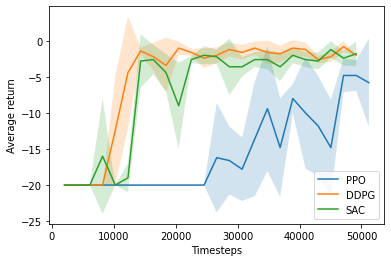

In [112]:
results = {'PPO': './logs/dam/ppo',
           'DDPG': './logs/dam/ddpg',
           'SAC': './logs/dam/sac'}
        
plot_results(results)